## Required Packages & Data Preparation

In [2]:
library(jsonlite)
library(httr)
library(data.table)
library(ggplot2)
library(ggcorrplot)
library(readr)
library(tsibble)
library(zoo)
library(forecast)
library(mgcv)
library(lubridate)
library(urca)
library(Metrics)
library(mgcv)
library(gratia)
options(repr.plot.width = 10, repr.plot.height = 4)

In [3]:
accu=function(actual,forecast){
  n=length(actual)
  error=actual-forecast
  mean=mean(actual)
  sd=sd(actual)
  CV=sd/mean
  FBias=sum(error)/sum(actual)
  MAPE=sum(abs(error/actual))/n
  RMSE=sqrt(sum(error^2)/n)
  MAD=sum(abs(error))/n
  MADP=sum(abs(error))/sum(abs(actual))
  WMAPE=MAD/mean
  l=data.frame(n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE)
  return(l)
}

get_token <- function(username, password, url_site){
  
  post_body = list(username=username,password=password)
  post_url_string = paste0(url_site,'/token/')
  result = POST(post_url_string, body = post_body)
  
  # error handling (wrong credentials)
  if(result$status_code==400){
    print('Check your credentials')
    return(0)
  }
  else if (result$status_code==201){
    output = content(result)
    token = output$key
  }
  
  return(token)
}

get_data <- function(start_date="1", token, url_site){
  
  post_body = list(start_date=start_date,username=username,password=password)
  post_url_string = paste0(url_site,'/dataset/')
  
  header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
  result = GET(post_url_string, header, body = post_body)
  output = content(result)
  data = data.table::rbindlist(output)
  data[,event_date:=as.Date(event_date)]
  data = data[order(product_content_id,event_date)]
  return(data)
}


In [4]:
subm_url = 'http://46.101.163.177'

u_name = "Group4"
p_word = "a4TStQDQYjpverak"
submit_now = FALSE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
data_son = get_data(token=token,url=subm_url)

ProjectRawData <- read_csv("C:/Users/kaan9/OneDrive/Masaüstü/ProjectRawData.csv", 
                           col_types = cols(event_date = col_date(format = "%Y-%m-%d")))
data <- data.table(ProjectRawData)
data <- data.table(rbind(data,data_son[event_date > max(data$event_date)]))[order(event_date)]


discount_dates <- as.Date(c("2021-03-10", "2021-03-11", "2021-03-12",
                            "2021-02-13", "2021-02-14", "2021-02-12",
                            "2020-12-31", "2020-12-30","2020-12-29",
                            "2020-11-25", "2020-11-26", "2020-11-27", "2020-11-28", "2020-11-29",
                            "2020-11-09", "2020-11-10","2020-11-11",
                            "2020-09-10", "2020-09-11", "2020-09-12",
                            "2020-06-18", "2020-06-19", "2020-06-20",
                            "2021-05-07","2021-05-08", "2021-05-09"))

data <- data[,special_days:=0]
data[data$event_date %in% discount_dates]$special_days <- 1
data$ratio <- data$category_sold / data$category_favored
dt <- data[event_date < "2021-06-05"]
test_set <- data[event_date >= "2021-06-05" & event_date <= "2021-06-11"]


In [5]:
train_start=as.Date('2020-05-25')
test_start=as.Date('2021-05-24')
test_end=as.Date('2021-05-31')
test_dates=seq(test_start,test_end,by='day')

In [6]:
#data seperation part
#Mont, ALTINYILDIZ CLASSICS
prod1 <- dt[product_content_id==48740784,]
prod1 <- prod1[order(event_date)]
test_set1 <- test_set[product_content_id==48740784,]
test_set1 <- test_set1[order(event_date)]
#Bikini Ustu 1, TRENDYOLMILLA
prod2 <- dt[product_content_id==73318567,]
prod2 <- prod2[order(event_date)]
test_set2 <- test_set[product_content_id==73318567,]
test_set2 <- test_set2[order(event_date)]
#Bikini Ustu 2, TRENDYOLMILLA
prod3 <- dt[product_content_id==32737302,]
prod3 <- prod3[order(event_date)]
test_set3 <- test_set[product_content_id==32737302,]
test_set3 <- test_set3[order(event_date)]
#Tayt, TRENDYOLMILLA
prod4 <- dt[product_content_id==31515569,]
prod4 <- prod4[order(event_date)]
test_set4 <- test_set[product_content_id==31515569,]
test_set4 <- test_set4[order(event_date)]
#Bluetooth Kulaklik, Xiaomi
prod5 <- dt[product_content_id==6676673,]
prod5 <- prod5[order(event_date)]
test_set5 <- test_set[product_content_id==6676673,]
test_set5 <- test_set5[order(event_date)]
#Dik Supurge, Fakir
prod6 <- dt[product_content_id==7061886,]
prod6 <- prod6[order(event_date)]
test_set6 <- test_set[product_content_id==7061886,]
test_set6 <- test_set6[order(event_date)]
#Yuz Temizleyici, La Roche Posay
prod7 <- dt[product_content_id==85004,]
prod7 <- prod7[order(event_date)]
test_set7 <- test_set[product_content_id==85004,]
test_set7 <- test_set7[order(event_date)]
#Bebek Islak Mendil, Sleepy
prod8 <- dt[product_content_id==4066298,]
prod8 <- prod8[order(event_date)]
test_set8 <- test_set[product_content_id==4066298,]
test_set8 <- test_set8[order(event_date)]
#Sarj Edebilir Dis Fircasi, Oral-B
prod9 <- dt[product_content_id==32939029,]
prod9 <- prod9[order(event_date)]
test_set9 <- test_set[product_content_id==32939029,]
test_set9 <- test_set9[order(event_date)]

## PROD9 | Sarj Edilebilir Dis Fircasi, Oral-B

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


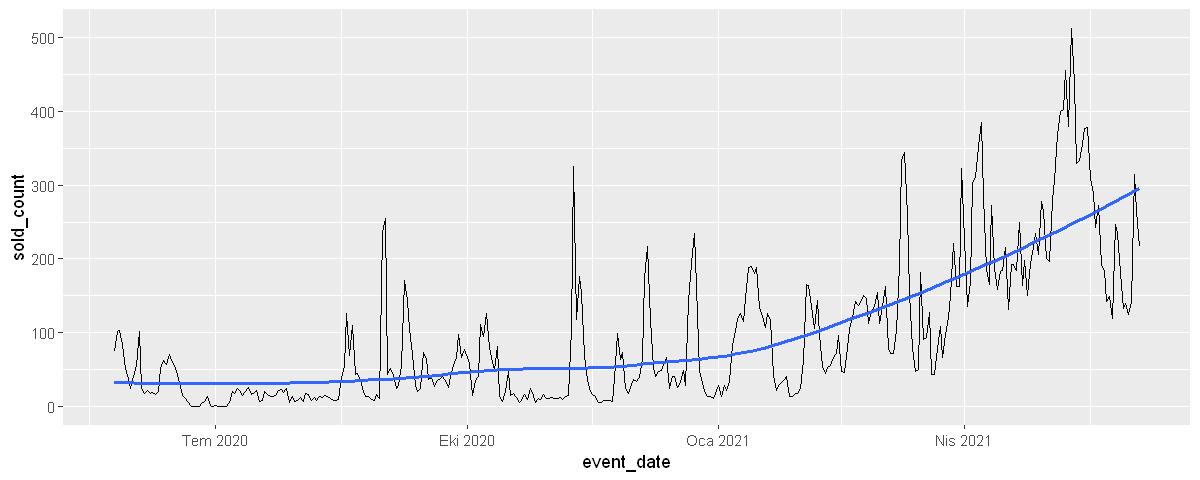

In [7]:
ggplot(prod9, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* By the blue line, it seems that there is a nonlinear increasing trend in the data. 
* Variance is not constant, it increases over time. 
* The mean is also not constant over time. 
* At the end of November 2020, there are jumping points due to the Black Friday discounts. (called as efsane gunler) 
* In the middle of March 2021, there are also jumping points because of the 'Super Mart' discounts. 
* There are some days with zero sales. 
* It appears that the data is not stationary. In the next steps, it will be analysed and decomposed. 

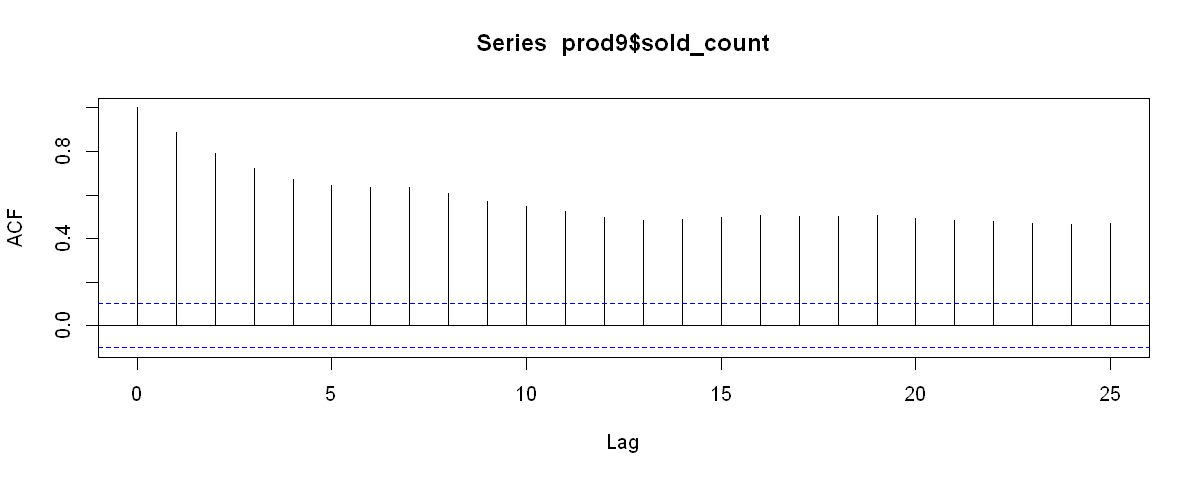

In [8]:
acf(prod9$sold_count) 

From the ACF tableau above, it seems that there is a trend. Also, there are peak points at lag 7 which indicates that there might be weekly seasonality. 

### Weekly Decomposition

Because the variance increases over time, the multiplicative decomposition method will be used. 

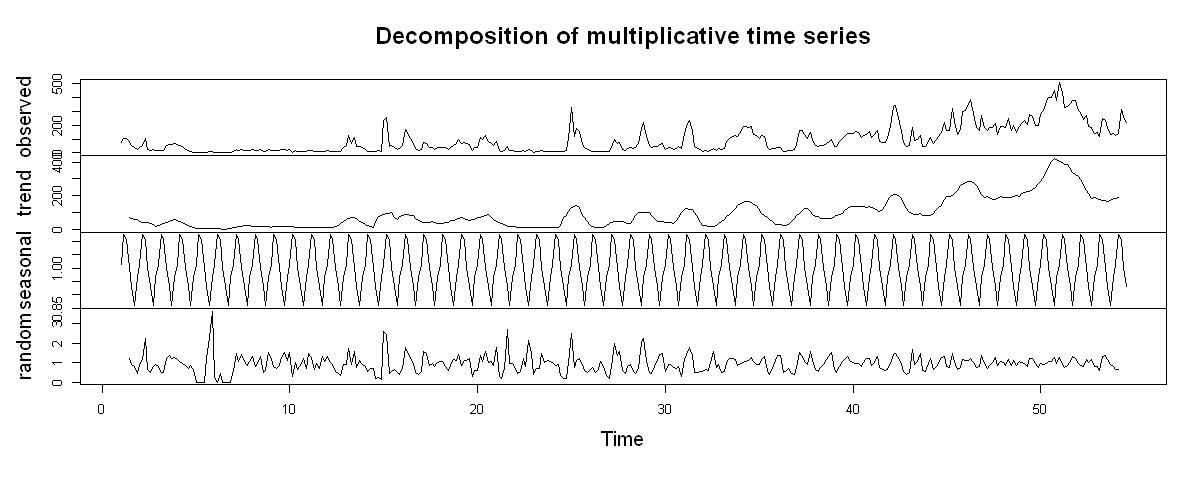

In [9]:
prod9_weekly_dec <- decompose(ts(prod9$sold_count, freq=7), type="multiplicative")
plot(prod9_weekly_dec)

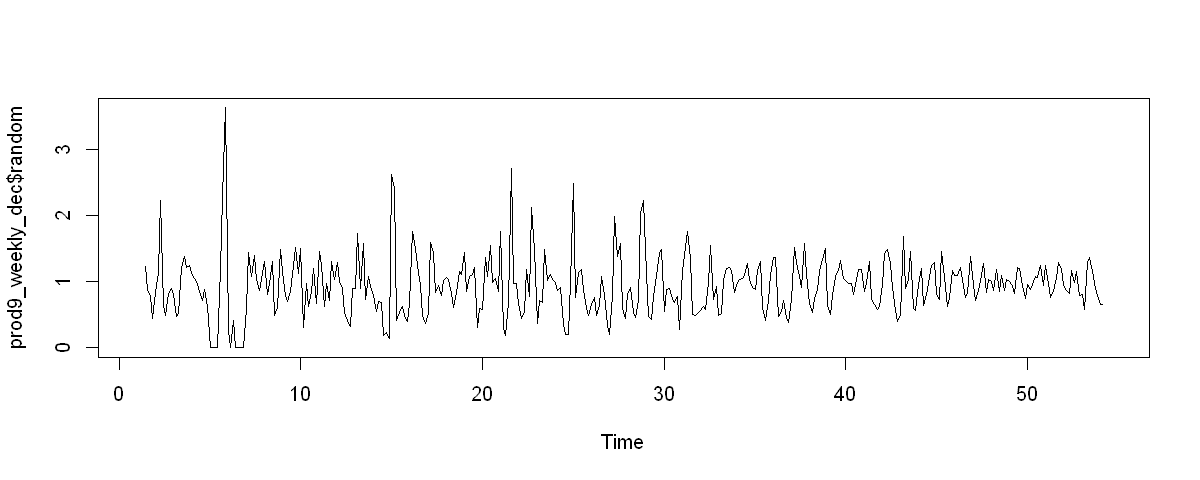

In [10]:
plot(prod9_weekly_dec$random)

* The variance is decreasing over time. 
* The mean seems to be constant. 
* There is a jumping point at the beginning of the data. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [11]:
u_test <- ur.kpss(prod9_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1754 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS test above, it can be said that the data is stationary. 

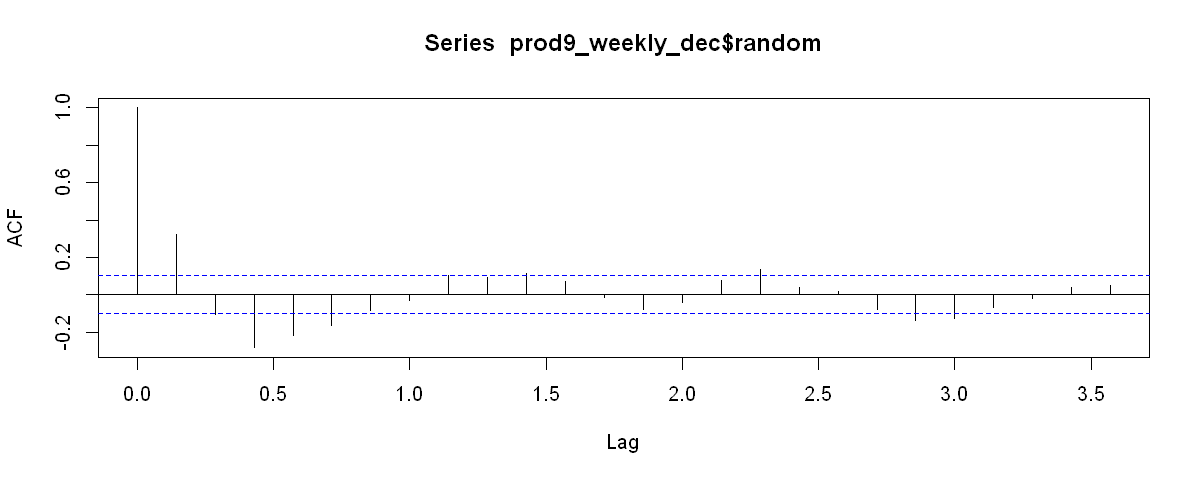

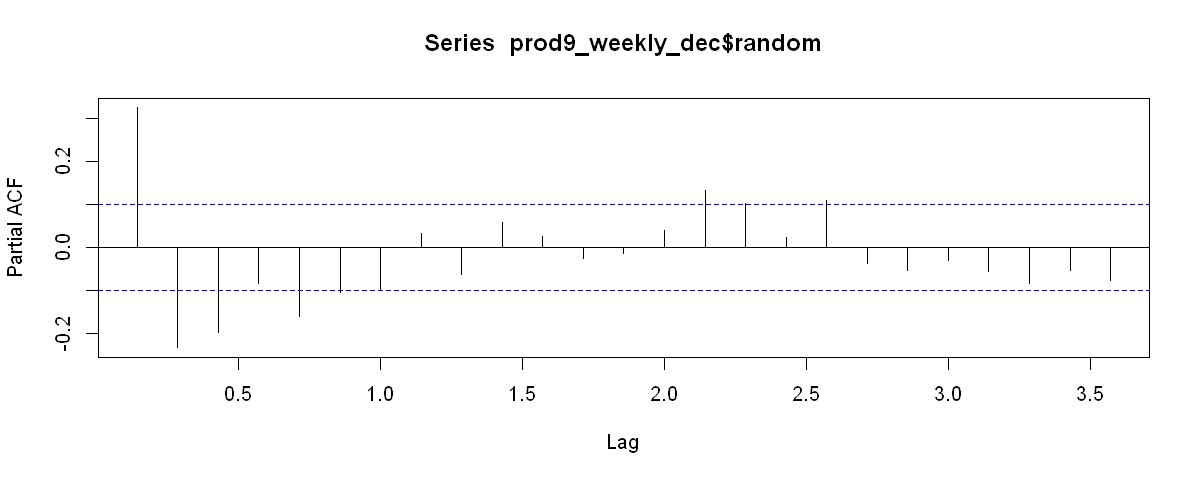

In [12]:
acf(prod9_weekly_dec$random, na.action=na.pass)
pacf(prod9_weekly_dec$random, na.action=na.pass)

There are slightly high autocorrelation at lag 1 and lag 3. From PACF above, it seems that there are low correlations with previous 3 observations in the weekly decomposed data, but the data is still stationary. 

### Monthly Decomposition

month,sold_count
2020 May,476
2020 Haz,824
2020 Tem,426
2020 Ağu,1020
2020 Eyl,1883
2020 Eki,1102
2020 Kas,1502
2020 Ara,2128
2021 Oca,2460
2021 Şub,2963


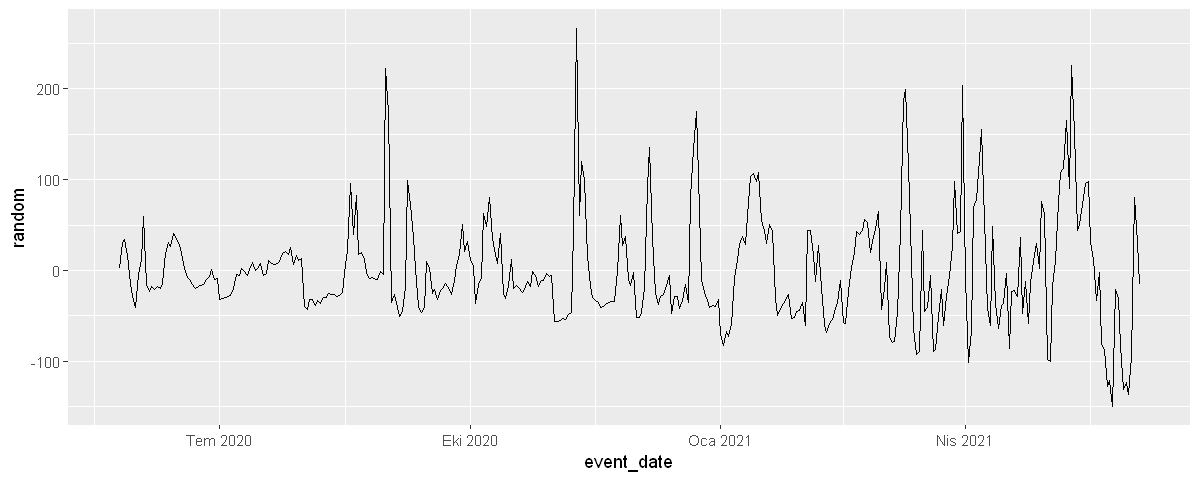

In [13]:
prod9_monthly <- prod9[, month:=yearmonth(event_date)]
prod9_monthly[, .(sold_count=sum(sold_count)), by=month]
prod9_monthly[, trend:=1:.N]

prod9_reg <- lm(sold_count~trend+as.factor(month), data=prod9_monthly)
prod9_monthly[, regOutput:=predict(prod9_reg, prod9_monthly)]

prod9_monthly[, random:=sold_count-regOutput]

ggplot(prod9_monthly, aes(x=event_date, y=random)) + geom_line()

* The variance is increasing over time. 
* The mean seems to be constant. 
* There is a jumping points in the middle of the data. 
 
Now, let's check whether the monthly detrended and deseasonalized data is stationary. 

In [14]:
u_test <- ur.kpss(prod9_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0193 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS unit test, we cannot reject the null hyphotesis. The data seems to be stationary.  

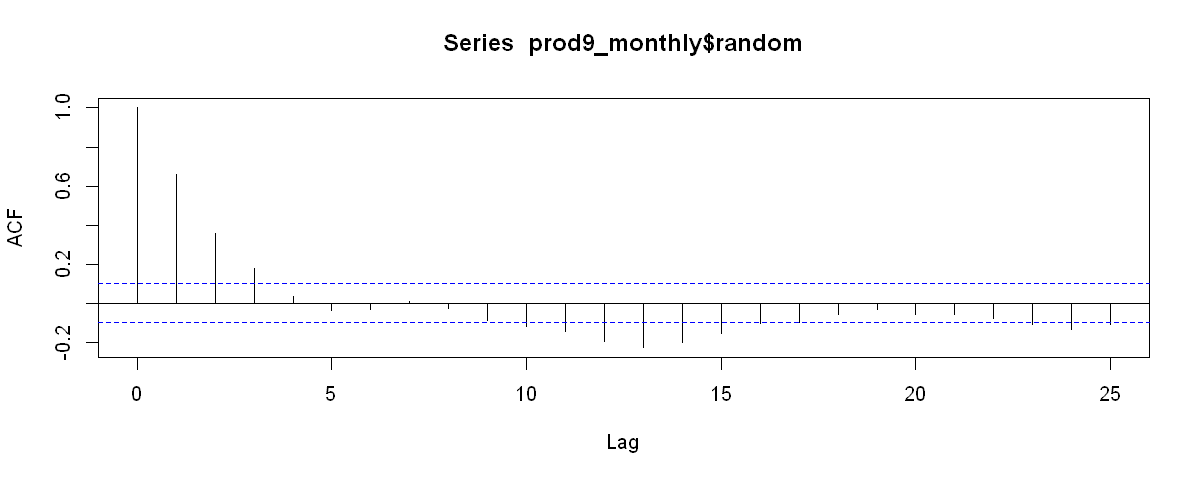

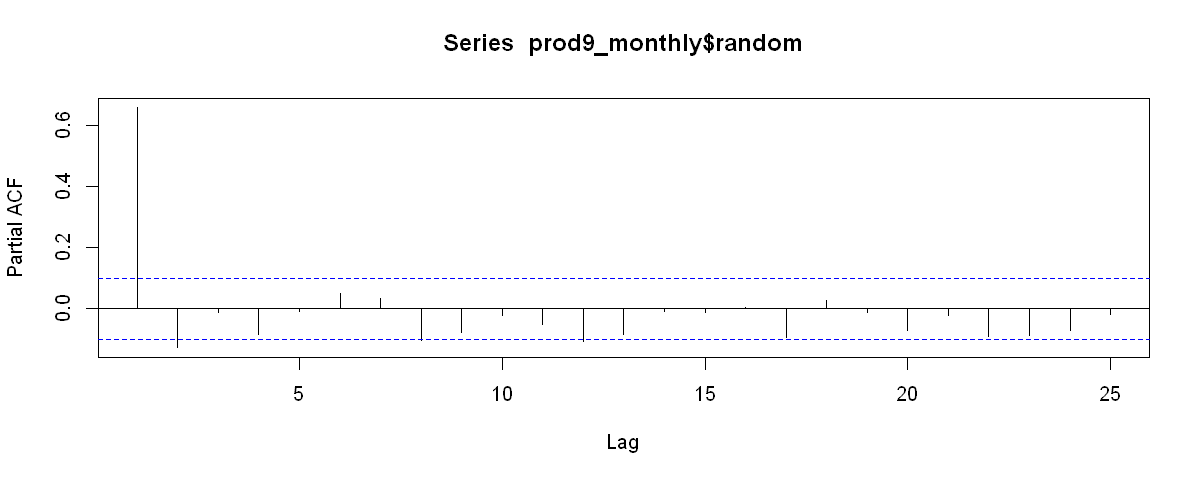

In [15]:
acf(prod9_monthly$random, na.action=na.pass)
pacf(prod9_monthly$random, na.action=na.pass)

From the PACF graph, there is a correlation with lag 1 in the data. 

### Building an ARIMA Model

In [16]:
disf <- data[product_content_id=="32939029",][order(event_date)]
disf_train <- disf[event_date<test_start,]
disf_ts <- ts(disf_train$sold_count,freq=7)

After the decomposition, it could be said that the chargable toothbrush has a weekly seasonality. Differencing could make the series stationary. 

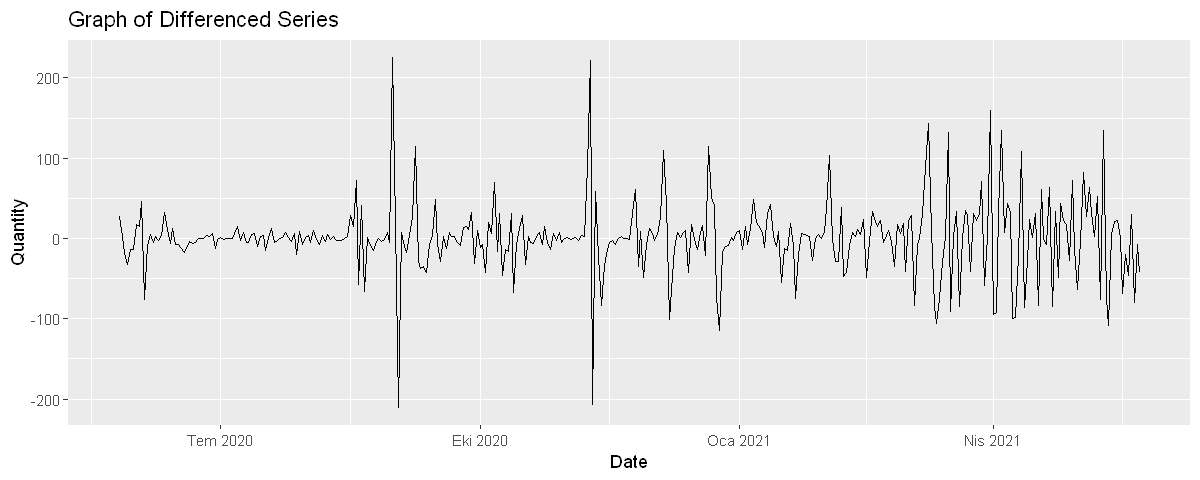

In [17]:
ggplot(disf_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(disf_train$sold_count,1))) + 
labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

After the differencing, the data seems stationary but it has some outliers and non-constant variance.

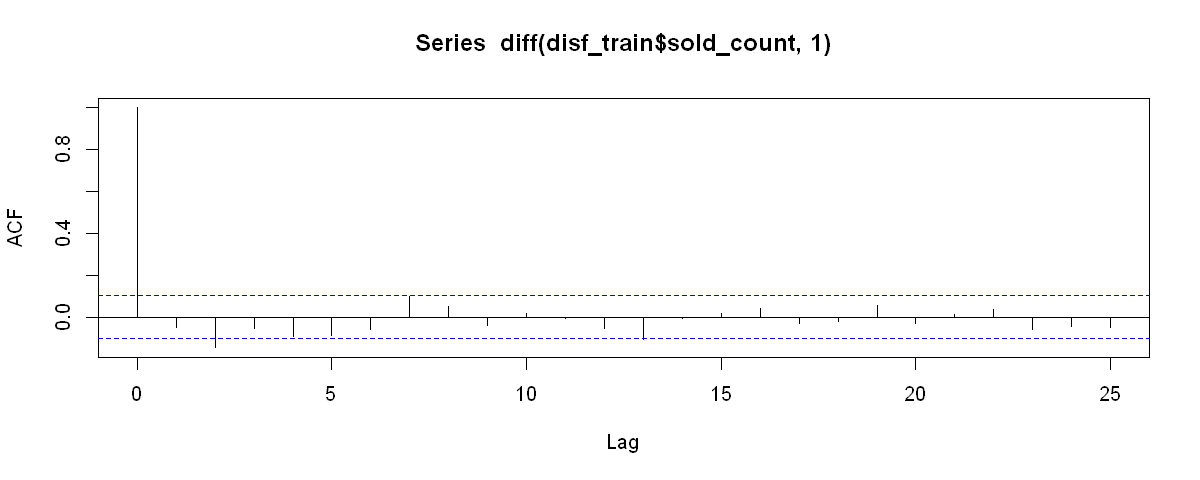

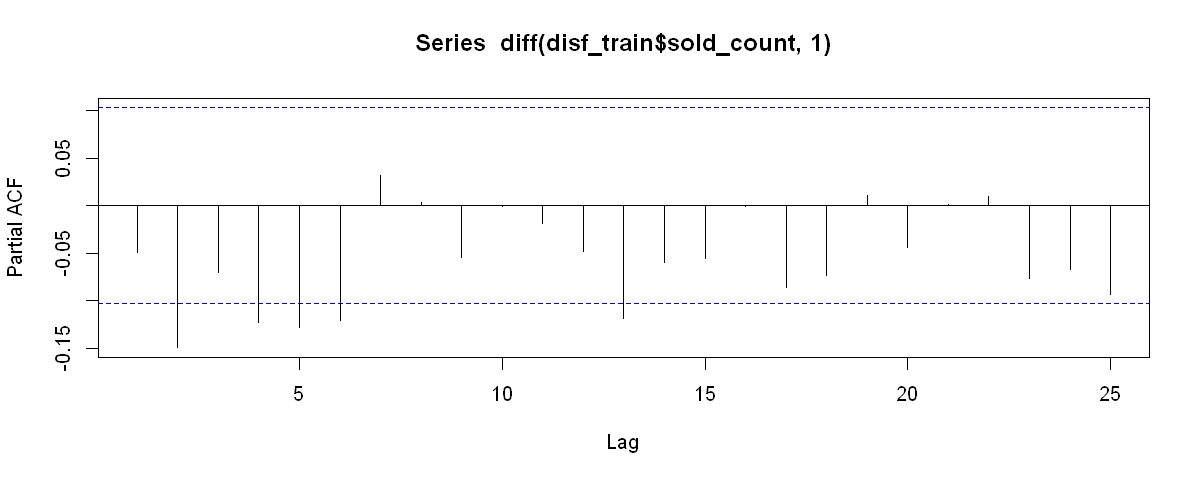

In [18]:
acf(diff(disf_train$sold_count,1))
pacf(diff(disf_train$sold_count,1))

At the ACF graph, there is a spike at lag 2 which indicates MA(2) model and also there is slighlty significant spike at lag 7 which is the seasonal MA(1). At the PACF graph, there is spikes at lag 2 and 4.  AR(2) and AR(4) models could be applied.

In [19]:
arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1))

Warning message in sqrt(diag(x$var.coef)):
"NaNs üretimi"


Call:
arima(x = disf_ts, order = c(2, 1, 2), seasonal = c(0, 0, 1))

Coefficients:
         ar1      ar2      ma1     ma2    sma1
      1.3107  -0.4577  -1.4713  0.4953  0.1189
s.e.     NaN      NaN      NaN     NaN  0.0500

sigma^2 estimated as 1820:  log likelihood = -1877.95,  aic = 3767.9

In [20]:
arima(disf_ts,order=c(4,1,2),seasonal=c(0,0,1))


Call:
arima(x = disf_ts, order = c(4, 1, 2), seasonal = c(0, 0, 1))

Coefficients:
         ar1      ar2     ar3      ar4      ma1      ma2    sma1
      0.7453  -0.0511  0.0472  -0.0567  -0.8901  -0.0581  0.1138
s.e.  0.9287   0.7544  0.1107   0.0563   0.9310   0.8899  0.0557

sigma^2 estimated as 1813:  log likelihood = -1877.28,  aic = 3770.55

In [21]:
auto.arima(disf_ts)

Series: disf_ts 
ARIMA(3,1,1)(0,0,1)[7] with drift 

Coefficients:
         ar1      ar2     ar3      ma1    sma1   drift
      0.8151  -0.0945  0.0117  -0.9693  0.1085  0.6398
s.e.  0.0549   0.0678  0.0548   0.0160  0.0551  0.3087

sigma^2 estimated as 1833:  log likelihood=-1876.37
AIC=3766.74   AICc=3767.06   BIC=3794.01

After trying some SARIMA models, auto.arima function gives the nearly same result with the SARIMA(2,1,2)(0,0,1). We could use our model to forecasting.


	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)(0,0,1)[7]
Q* = 9.9405, df = 9, p-value = 0.3553

Model df: 5.   Total lags used: 14



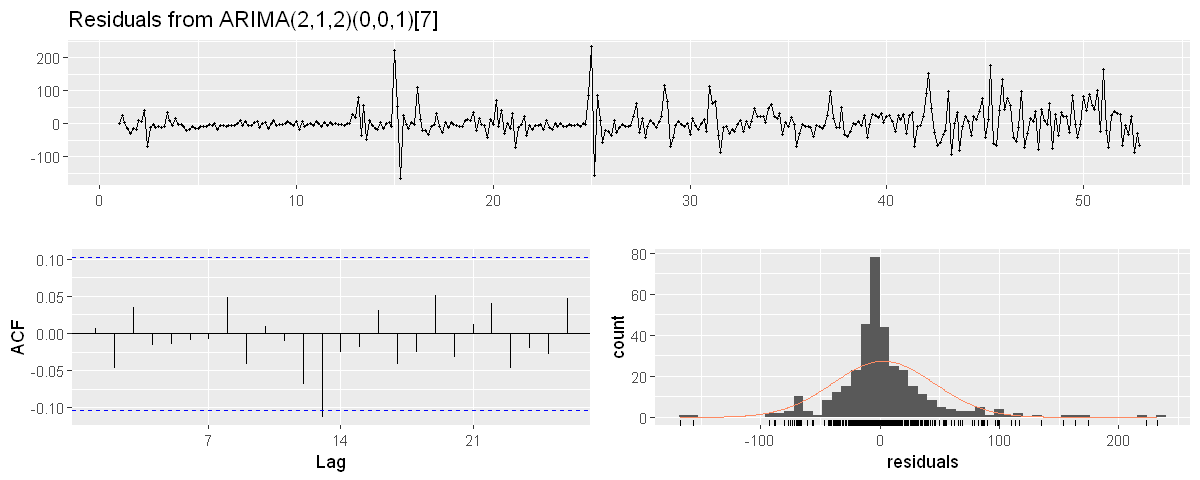

In [22]:
model_disf_sarima <- arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1))
checkresiduals(model_disf_sarima)

Residuals look stationary with constant mean at 0. Variance isn't constant but there is not any significant correlations at ACF graph. The distribution seems normal.

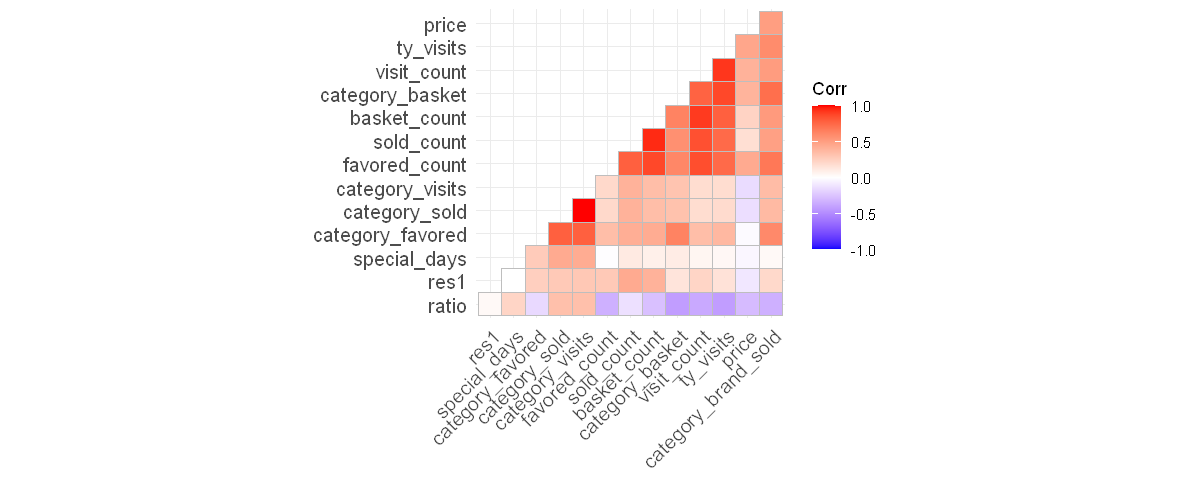

In [23]:
disf_train$res1 <- model_disf_sarima$residuals
corr <- cor(disf_train[!is.na(disf_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have highest correlation with basket_count which 0.4. Also it still has correlation with output variable which means there is still unexplained data in sold_count. We could add basket_count as a regressor.


Call:
arima(x = disf_ts, order = c(2, 1, 2), seasonal = c(0, 0, 1), xreg = disf_train$basket_count)

Coefficients:
         ar1     ar2      ma1     ma2    sma1  disf_train$basket_count
      0.6012  0.0651  -1.0415  0.0612  0.0240                   0.2016
s.e.  0.3804  0.2030   0.3799  0.3470  0.0614                   0.0080

sigma^2 estimated as 585.7:  log likelihood = -1672.57,  aic = 3359.13


	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)(0,0,1)[7]
Q* = 8.8349, df = 8, p-value = 0.3564

Model df: 6.   Total lags used: 14



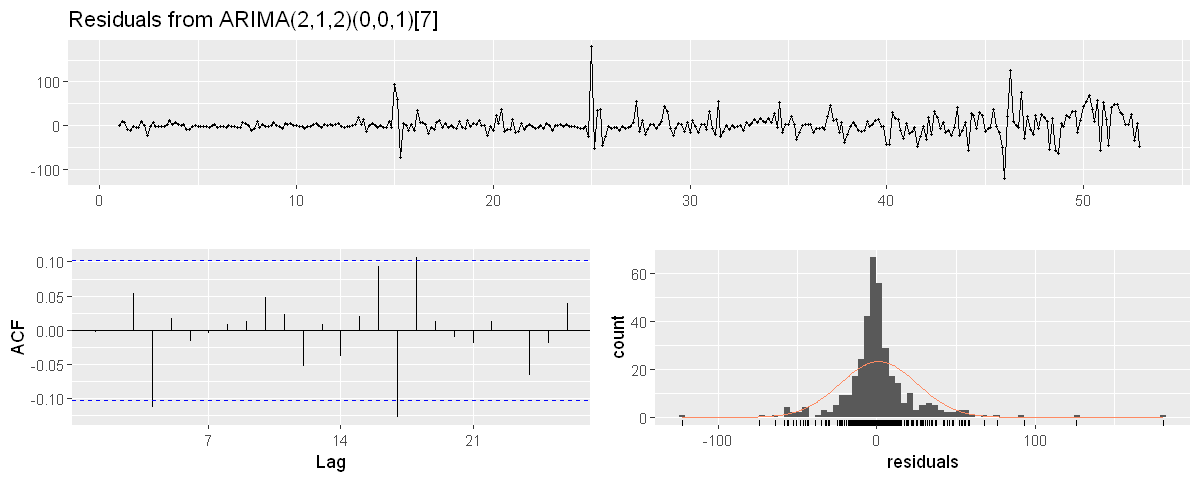

In [24]:
model_disf_sarimax <- arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1),xreg=disf_train$basket_count)
disf_train$res2 <- model_disf_sarimax$residuals
model_disf_sarimax
checkresiduals(model_disf_sarimax)

After the addition of the baskes_count as a regressor, AIC value is reduced to 3359 from 3767. Residuals didn't change much after the addition of the regressor.

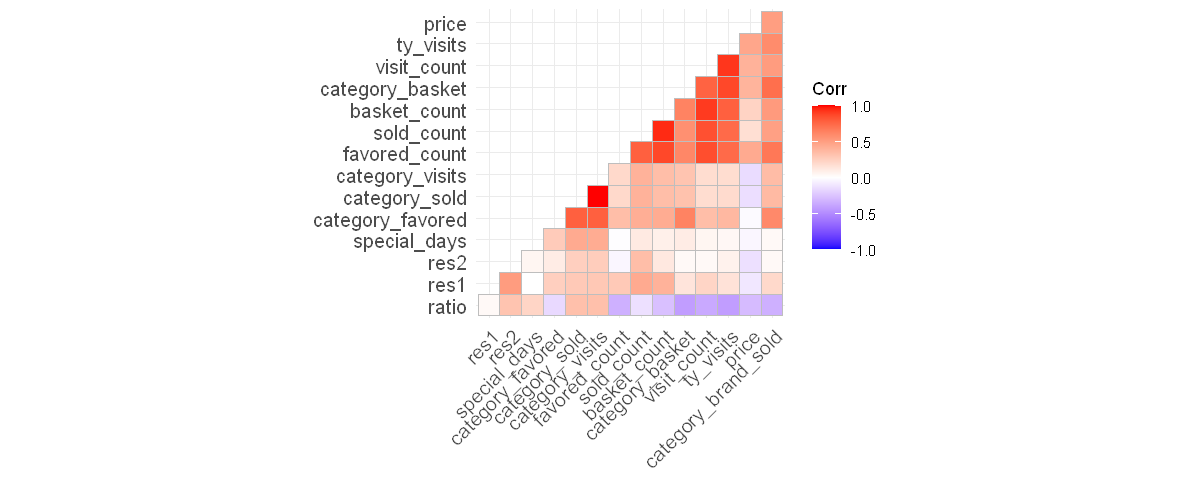

In [25]:
corr <- cor(disf_train[!is.na(disf_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals still have correlation with category_visits but not significantly, it could be added as a regressor.

In [26]:
model_disf_sarimax2 <- arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1),xreg=as.matrix(disf_train$basket_count,disf_train$category_visits))
disf_train$res3 <- model_disf_sarimax2$residuals
model_disf_sarimax2


Call:
arima(x = disf_ts, order = c(2, 1, 2), seasonal = c(0, 0, 1), xreg = as.matrix(disf_train$basket_count, 
    disf_train$category_visits))

Coefficients:
         ar1     ar2      ma1     ma2    sma1
      0.6012  0.0651  -1.0415  0.0612  0.0240
s.e.  0.3804  0.2030   0.3799  0.3470  0.0614
      as.matrix(disf_train$basket_count, disf_train$category_visits)
                                                              0.2016
s.e.                                                          0.0080

sigma^2 estimated as 585.7:  log likelihood = -1672.57,  aic = 3359.13

The addition of the new regressor didn't change the AIC value. So, the previous SARIMAX model could be use in forecasting.

In [27]:
forecast_data_disf <- data.table(event_date=disf[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=disf[event_date>=test_start&event_date<=test_end,]$sold_count)
sarima_fc <- numeric(0)
sarimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- disf[event_date<test_dates[i],]
  model_sarima <- Arima(train_dt$sold_count,order=c(2,1,2),seasonal=c(0,0,1))
  model_sarimax <- Arima(train_dt$sold_count,order=c(2,1,2),seasonal=c(0,0,1),xreg=train_dt$basket_count)
  newreg <- forecast(auto.arima(train_dt$basket_count),h=1)$mean[1]
  sarima_temp <- forecast(model_sarima)
  sarimax_temp <- forecast(model_sarimax,xreg=newreg)
  sarima_fc <- c(sarima_fc,sarima_temp$mean[1])
  sarimax_fc <- c(sarimax_fc,sarimax_temp$mean[1])
  
}
forecast_data_disf <- forecast_data_disf[,`:=`(sarima_p=sarima_fc,
                                     sarimax_p=sarimax_fc)]
accu(forecast_data_disf$sold_count,forecast_data_disf$sarima_p)
accu(forecast_data_disf$sold_count,forecast_data_disf$sarimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,166.125,50.10685,0.3016214,-0.1364043,0.2986378,54.73278,47.91314,0.2884162,0.2884162


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,166.125,50.10685,0.3016214,-0.1699127,0.3190137,54.8035,50.99846,0.3069885,0.3069885


After the applicaiton of the models on the test period, SARIMA model has WMAPE value of 0.288 while the SARIMAX model with basket_count as a regressor has WMAPE value of 0.307. It could be concluded that the SARIMA model is a better predictive model.

## PROD8 | Bebek Islak Mendil, Sleepy

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


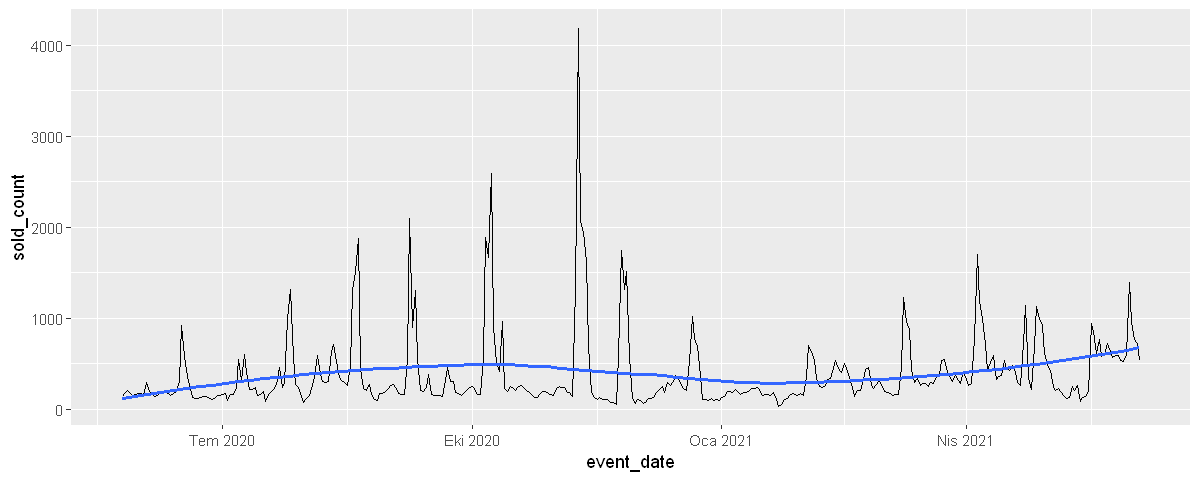

In [28]:
ggplot(prod8, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The variance is not constant over time. 
* The mean changes over time. There is a sinuate trend. We can see them by the blue line.  
* In the middle of the graph, there are jumping points. The discount days could cause them. 
* The data above is not stationary because of the non-constant variance and mean. 

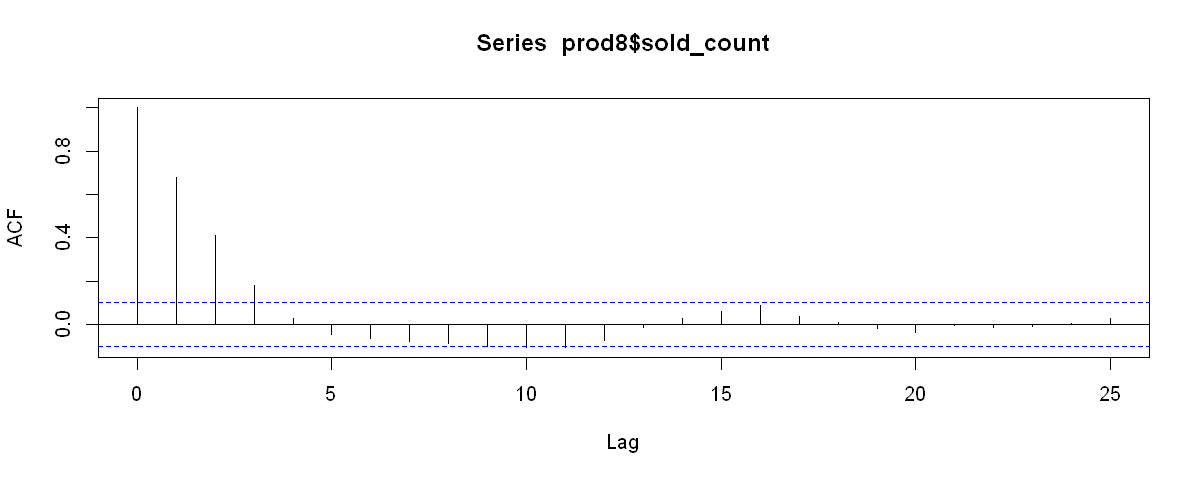

In [29]:
acf(prod8$sold_count)

The ACF graph is like sinus wave. Next steps below, the data will be decomposed at different levels. Because the variance is not increasing over time, additive decomposition will be used. 

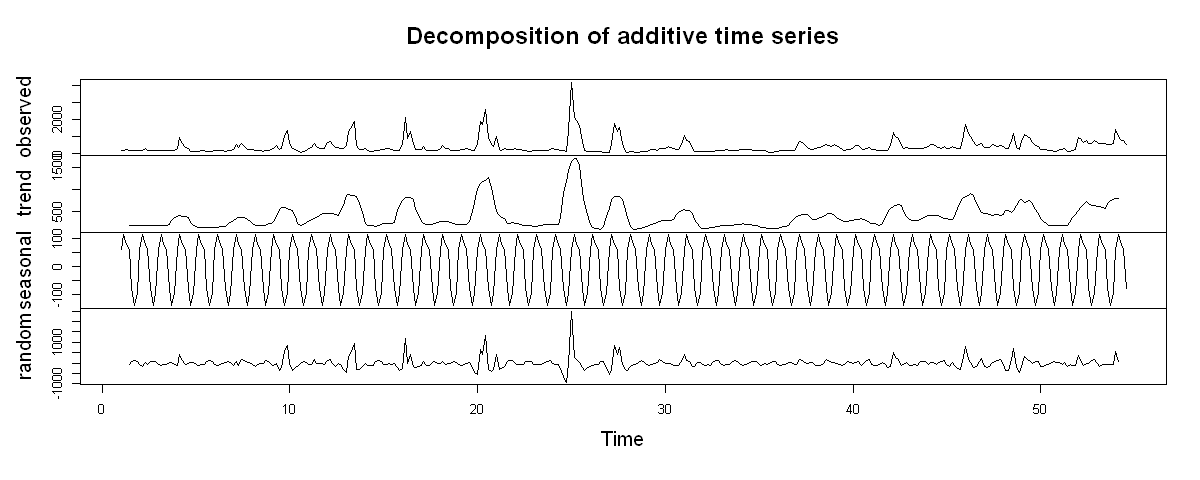

In [30]:
prod8_weekly_dec <- decompose(ts(prod8$sold_count, freq=7), type="additive")
plot(prod8_weekly_dec)

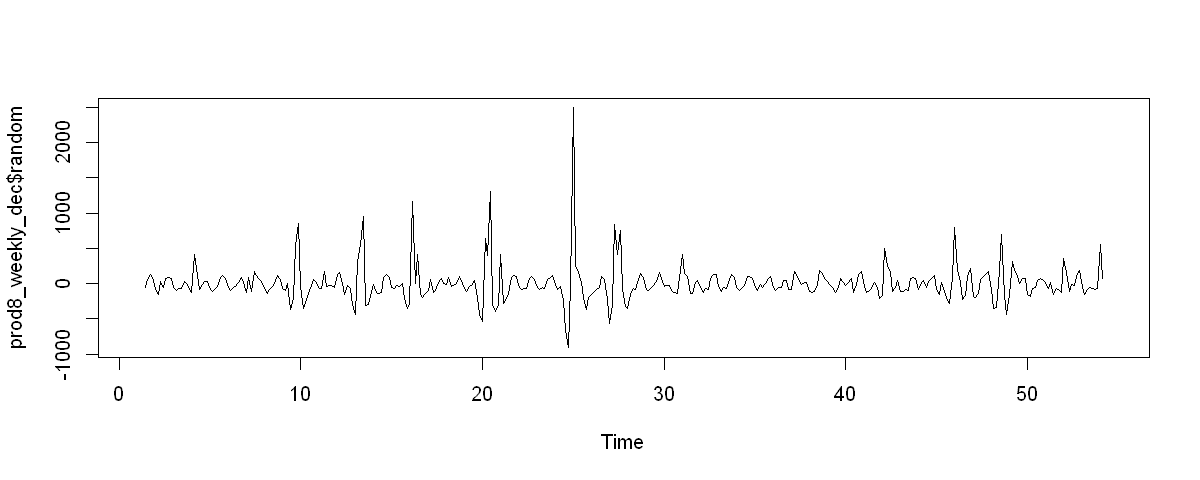

In [31]:
plot(prod8_weekly_dec$random)

* The mean is constant. 
* The variance seems not to be constant due to the jumping points. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [32]:
u_test <- ur.kpss(prod9_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1754 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


There is not enough evidence to reject the null hyphotesis. The data is stationary. 

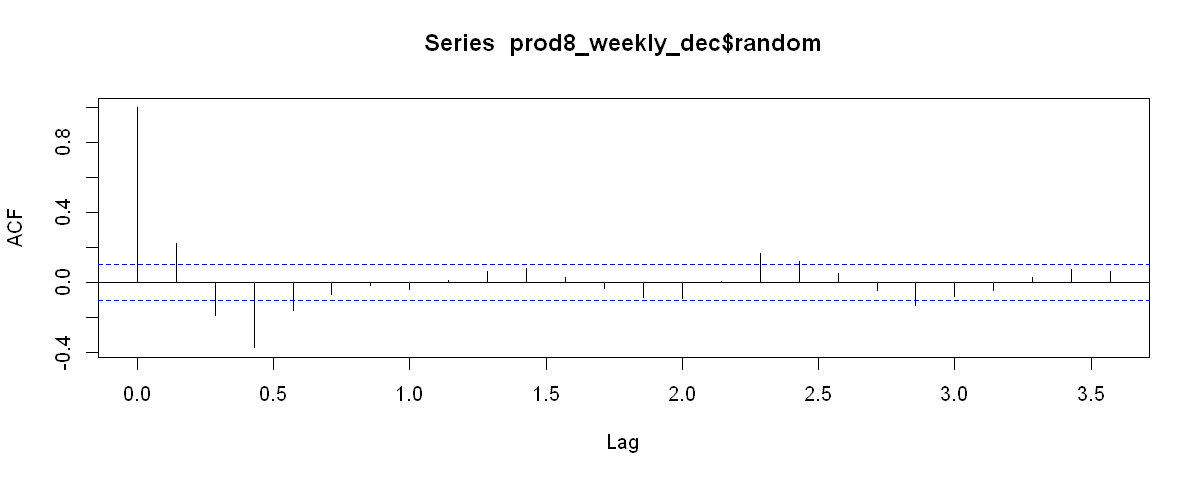

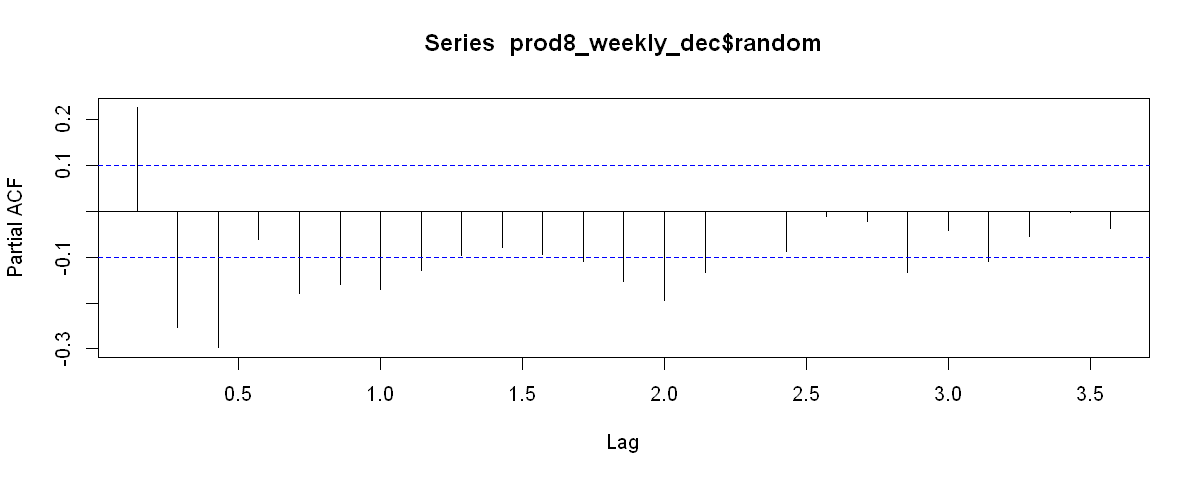

In [33]:
acf(prod8_weekly_dec$random, na.action=na.pass)
pacf(prod8_weekly_dec$random, na.action=na.pass)

The correlation values are not high. From the ACF, it can be said that the data is correlated with its previous three observations. 

### Monthly Decomposition

month,sold_count
2020 May,1181
2020 Haz,6379
2020 Tem,9588
2020 Ağu,13341
2020 Eyl,10967
2020 Eki,14086
2020 Kas,20286
2020 Ara,7932
2021 Oca,5088
2021 Şub,10201


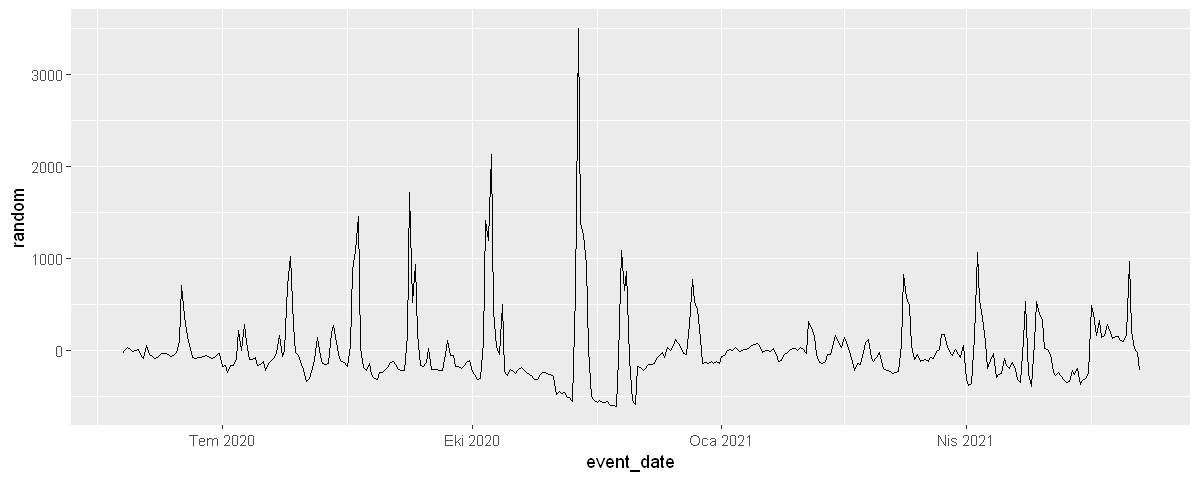

In [34]:
prod8_monthly <- prod8[, month:=yearmonth(event_date)]
prod8_monthly[, .(sold_count=sum(sold_count)), by=month]
prod8_monthly[, trend:=1:.N]

prod8_reg <- lm(sold_count~trend+as.factor(month), data=prod8_monthly)
prod8_monthly[, regOutput:=predict(prod8_reg, prod8_monthly)]

prod8_monthly[, random:=sold_count-regOutput]

ggplot(prod8_monthly, aes(x=event_date, y=random)) + geom_line()

* The mean slightly changes over time. 
* The variance is not constant. 

In [35]:
u_test <- ur.kpss(prod9_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0193 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Although the mean and variance are not constant over time, the test says that the data above is stationary. 

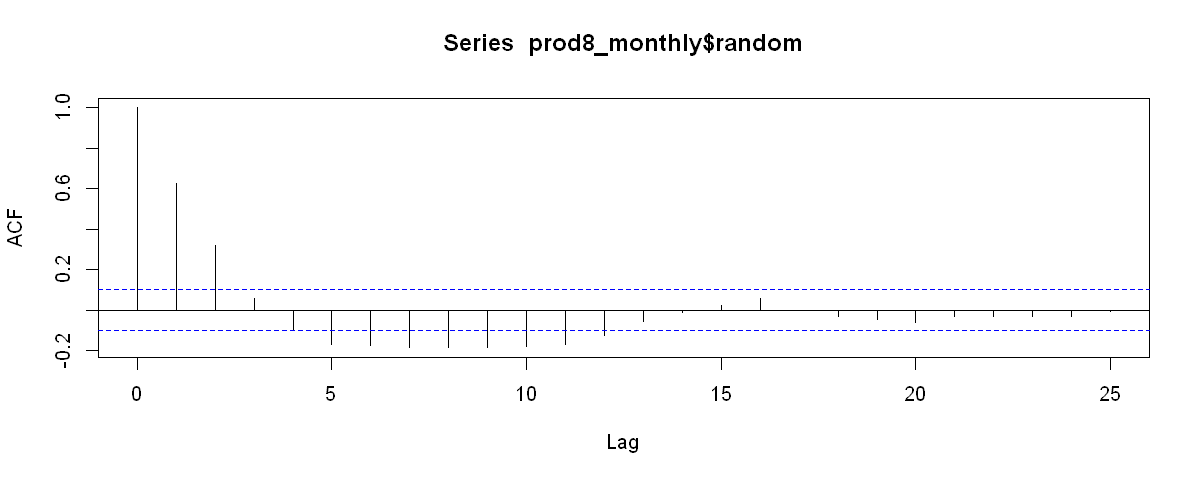

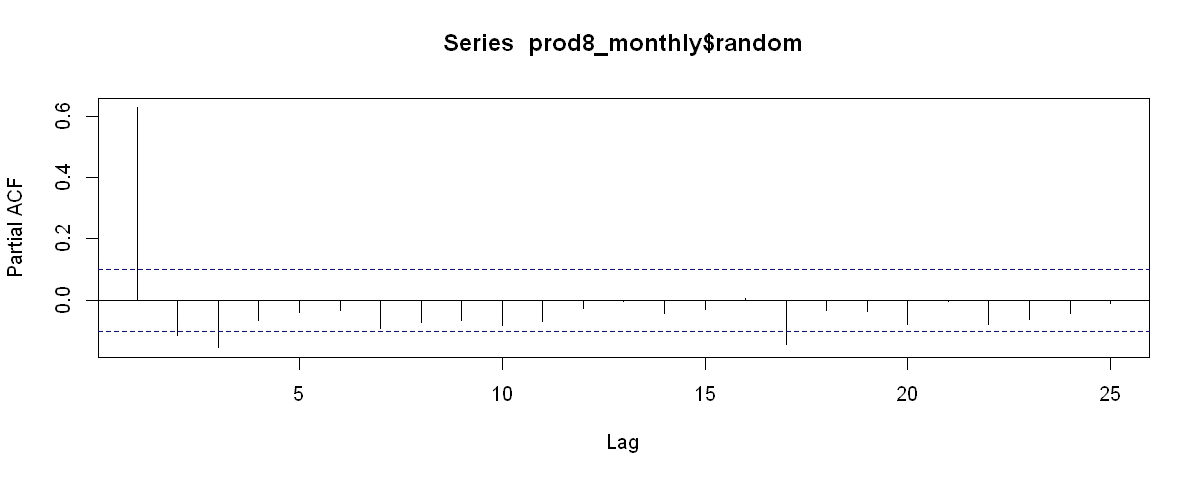

In [36]:
acf(prod8_monthly$random, na.action=na.pass)
pacf(prod8_monthly$random, na.action=na.pass)

There is a high correlation with lag 1. 

### Building an ARIMA Model

In [37]:
mendil <- data[product_content_id=="4066298",][order(event_date)]
mendil_train <- mendil[event_date<test_start,]
mendil_ts <- ts(mendil_train$sold_count)

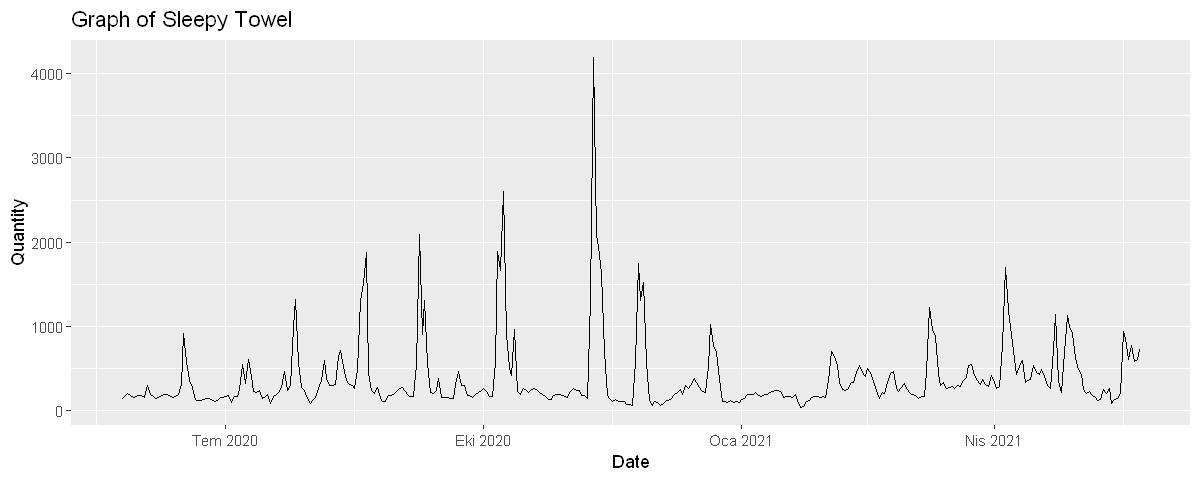

In [38]:
ggplot(mendil_train,aes(x=event_date,y=sold_count)) + geom_line() +
labs(title= "Graph of Sleepy Towel", x= "Date", y="Quantity")

There are a lot of outliers in the data, mean isn't constant and also variance varies through time. Differencing should be applied to the series.

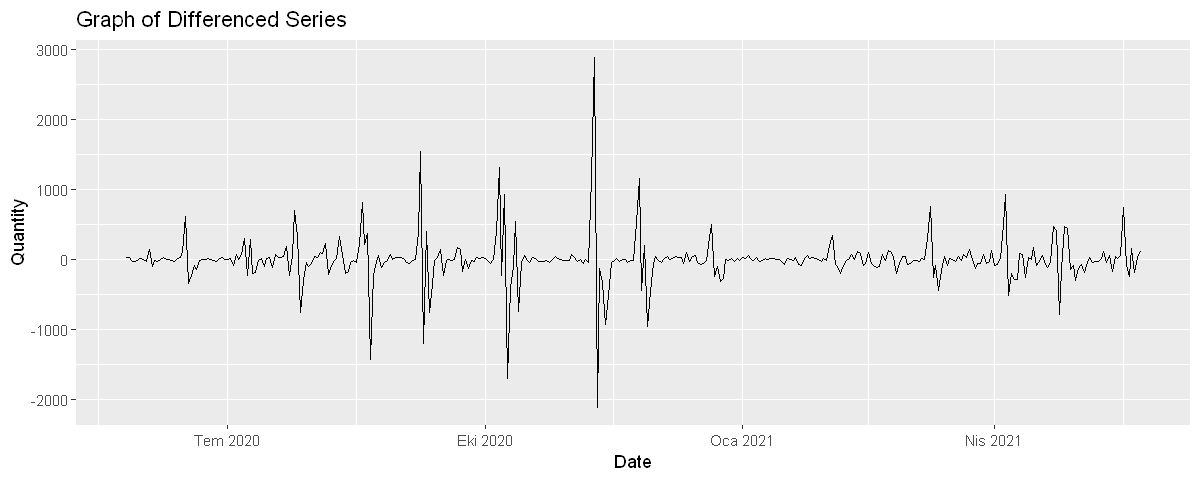

In [39]:
ggplot(mendil_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(mendil_train$sold_count,1))) + 
labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

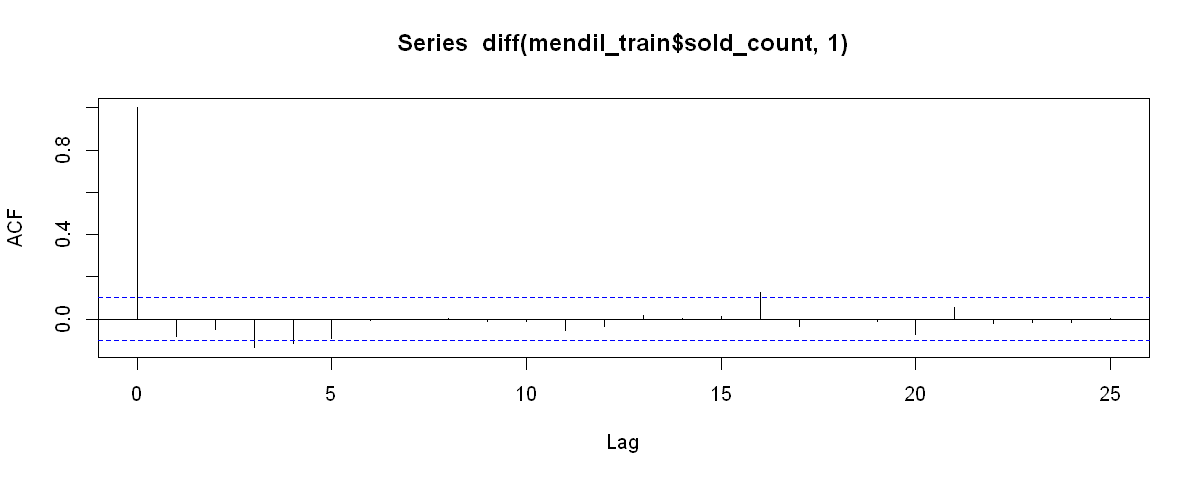

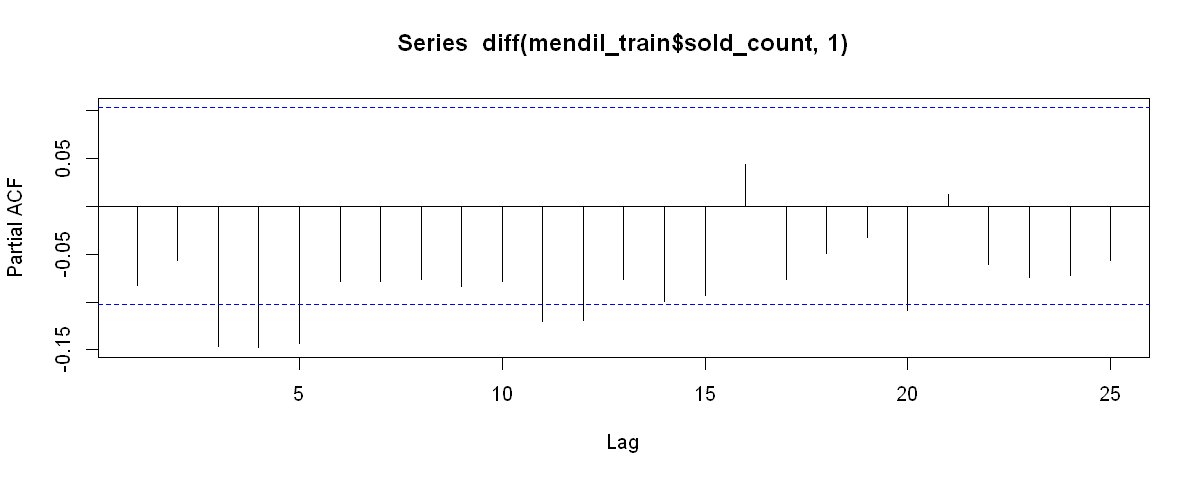

In [40]:
acf(diff(mendil_train$sold_count,1))
pacf(diff(mendil_train$sold_count,1))

At the ACF graph, there is a spike at lags 3 and 4 which could be MA(3) or MA(4) model. Also, there is spikes at PACF graph at lags 3 and 4 which indicates AR(3) OR AR(4) models. Seasonality is not occured in the decomposition steps so, ARIMA model could be consturcted.

In [41]:
arima(mendil_ts,order=c(3,1,3))


Call:
arima(x = mendil_ts, order = c(3, 1, 3))

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3
      0.7057  0.4394  -0.4075  -0.9812  -0.4544  0.4375
s.e.  0.6850  1.1309   0.5036   0.7044   1.3465  0.7162

sigma^2 estimated as 94410:  log likelihood = -2596.25,  aic = 5206.51

In [42]:
arima(mendil_ts,order=c(3,1,4))


Call:
arima(x = mendil_ts, order = c(3, 1, 4))

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3     ma4
      0.6086  0.8500  -0.6224  -0.8778  -0.9195  0.7762  0.0312
s.e.  0.2369  0.2744   0.1485   0.2550   0.3378  0.2496  0.0907

sigma^2 estimated as 94467:  log likelihood = -2595.53,  aic = 5207.07

In [43]:
arima(mendil_ts,order=c(4,1,3))

Warning message in sqrt(diag(x$var.coef)):
"NaNs üretimi"


Call:
arima(x = mendil_ts, order = c(4, 1, 3))

Coefficients:
         ar1     ar2      ar3      ar4      ma1      ma2     ma3
      0.5787  0.6222  -0.4751  -0.0042  -0.8520  -0.6791  0.5335
s.e.  0.1869     NaN   0.3468   0.1086   0.1529      NaN  0.5175

sigma^2 estimated as 94438:  log likelihood = -2596.25,  aic = 5208.51

In [44]:
arima(mendil_ts,order=c(4,1,4))


Call:
arima(x = mendil_ts, order = c(4, 1, 4))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3     ma4
      1.7154  -1.2244  0.6442  -0.2206  -1.9902  1.4996  -0.8841  0.3816
s.e.  0.6911   1.4612  1.1530   0.3548   0.6808  1.6200   1.3726  0.4425

sigma^2 estimated as 94329:  log likelihood = -2595.24,  aic = 5208.47

In [45]:
auto.arima(mendil_ts)

Series: mendil_ts 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ma1      mean
      1.4723  -0.5966  -0.7424  378.8350
s.e.  0.1322   0.0830   0.1458   33.3619

sigma^2 estimated as 95166:  log likelihood=-2601.16
AIC=5212.33   AICc=5212.49   BIC=5231.81

The best ARIMA model is (3,1,4) with the lowest AIC value of 5207.07.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,4)
Q* = 2.4983, df = 3, p-value = 0.4756

Model df: 7.   Total lags used: 10



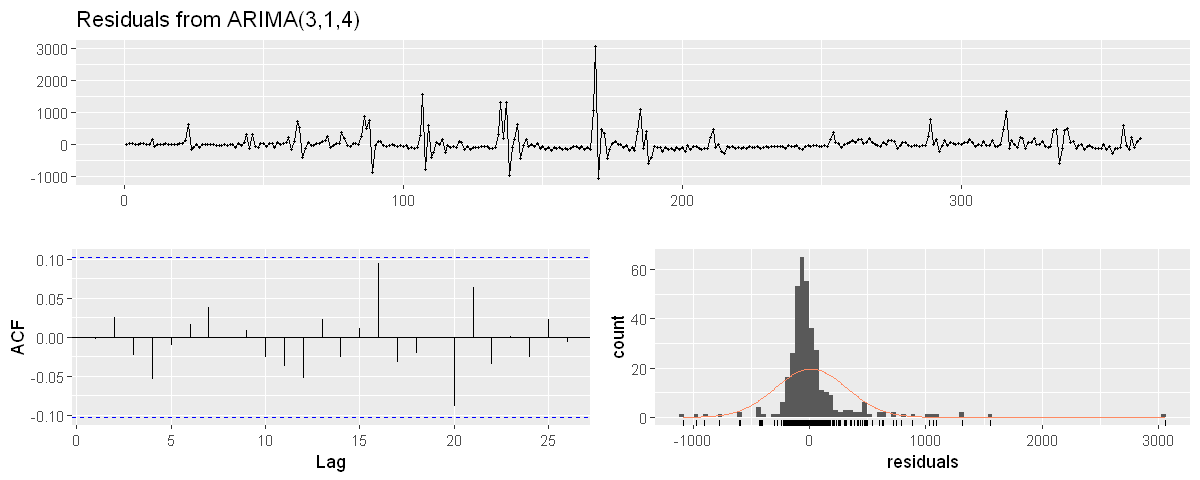

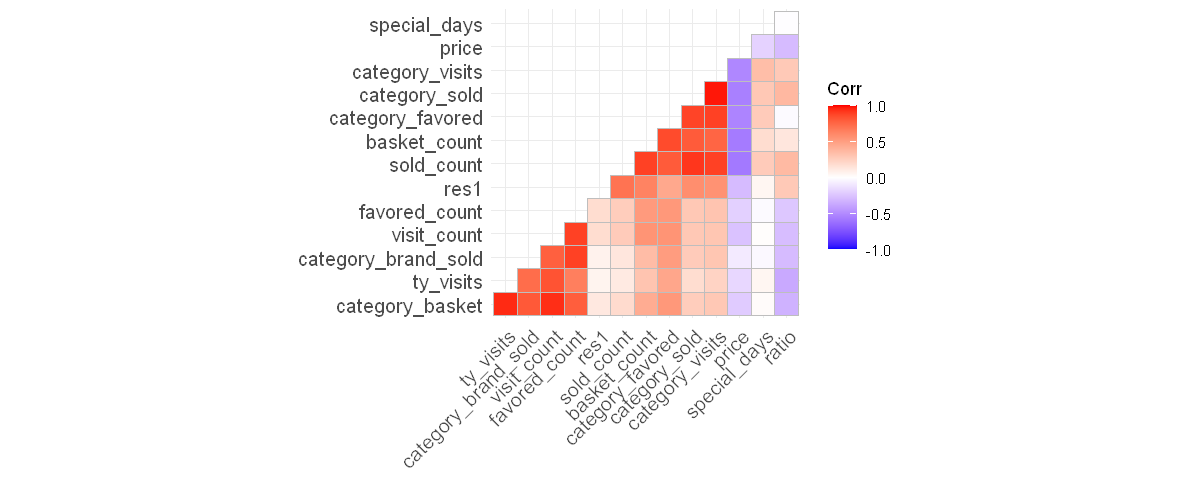

In [46]:
model_mendil_arima <- arima(mendil_ts,order=c(3,1,4))
checkresiduals(model_mendil_arima)
mendil_train$res1 <- model_mendil_arima$residuals
corr <- cor(mendil_train[!is.na(mendil_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Redisuals of the first model isn't autocorrelated and mean is constant at 0. Variance is mostly constant through time. Distribution looks normal but slightly right skewed. Residuals still correlated with sold_count which is output variable and also with basket_count.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


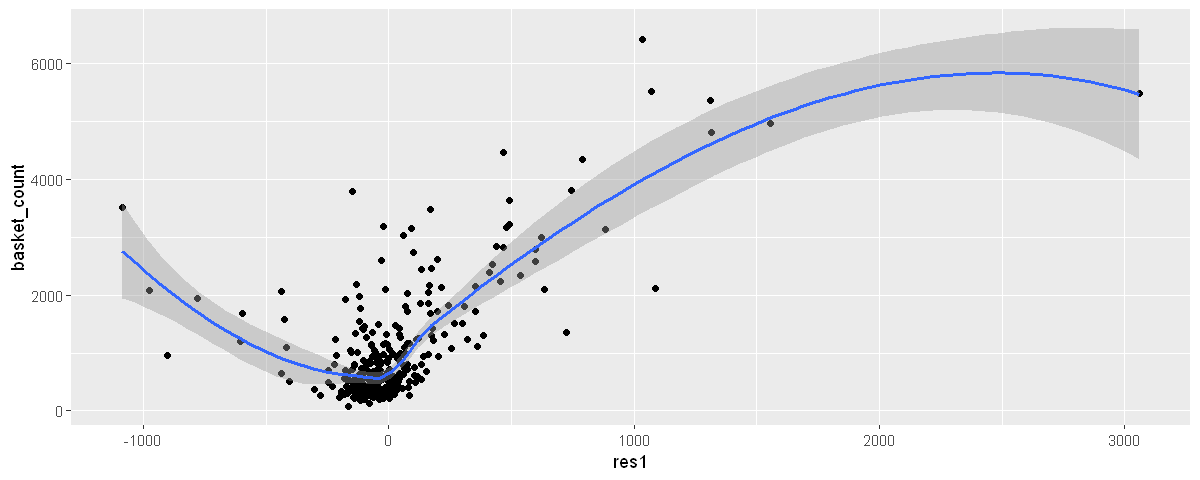

In [47]:
ggplot(mendil_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


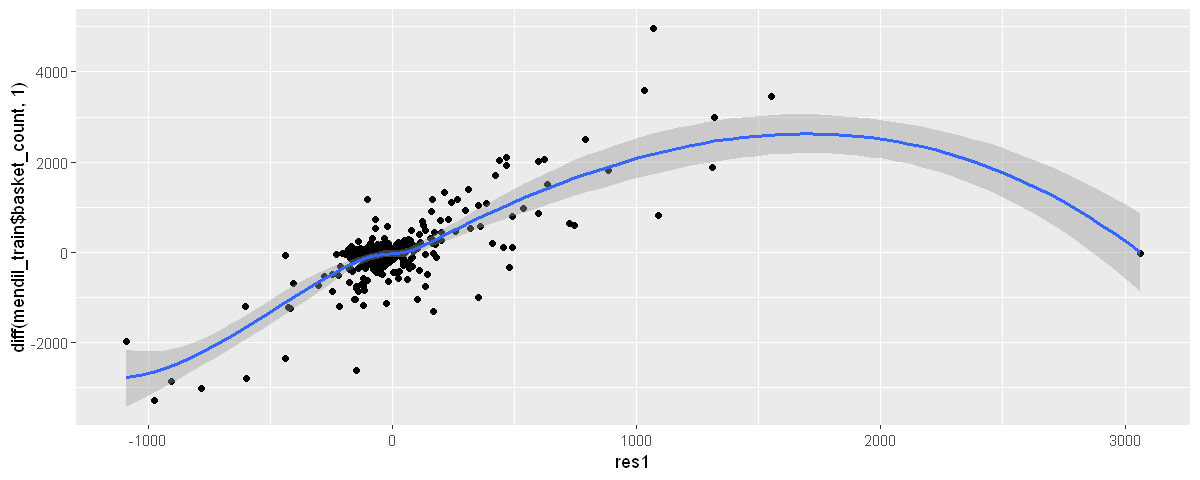

In [48]:
ggplot(mendil_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(mendil_train$basket_count,1))) +
geom_smooth(aes(y=diff(mendil_train$basket_count,1)))

In [49]:
cor(mendil_train[2:.N]$res1,diff(mendil_train$basket_count,1))
mendil_train$diff_basket <- c(NA,diff(mendil_train$basket_count,1))
mendil$diff_basket <- c(0,diff(mendil$basket_count,1))

[1] 0.6779306

The correlation between residuals and basket_count is non-linear but differencing the basket_count make this relation linear and with a correlation 0.678. We could add differenced basket_count as a regressor.

In [50]:
arima(mendil_ts,order=c(3,1,4),xreg=mendil_train$diff_basket)


Call:
arima(x = mendil_ts, order = c(3, 1, 4), xreg = mendil_train$diff_basket)

Coefficients:
         ar1      ar2      ar3      ma1      ma2      ma3      ma4
      0.4360  -0.0152  -0.0642  -0.5982  -0.1516  -0.0616  -0.1872
s.e.  0.4048   0.4732   0.2687   0.4020   0.5100   0.3229   0.0945
      mendil_train$diff_basket
                        0.1374
s.e.                    0.0143

sigma^2 estimated as 76502:  log likelihood = -2551.23,  aic = 5120.45

After the addition of regressor, AIC value is reduced slightly. 


	Ljung-Box test

data:  Residuals from ARIMA(3,1,4)
Q* = 3.3234, df = 3, p-value = 0.3444

Model df: 8.   Total lags used: 11



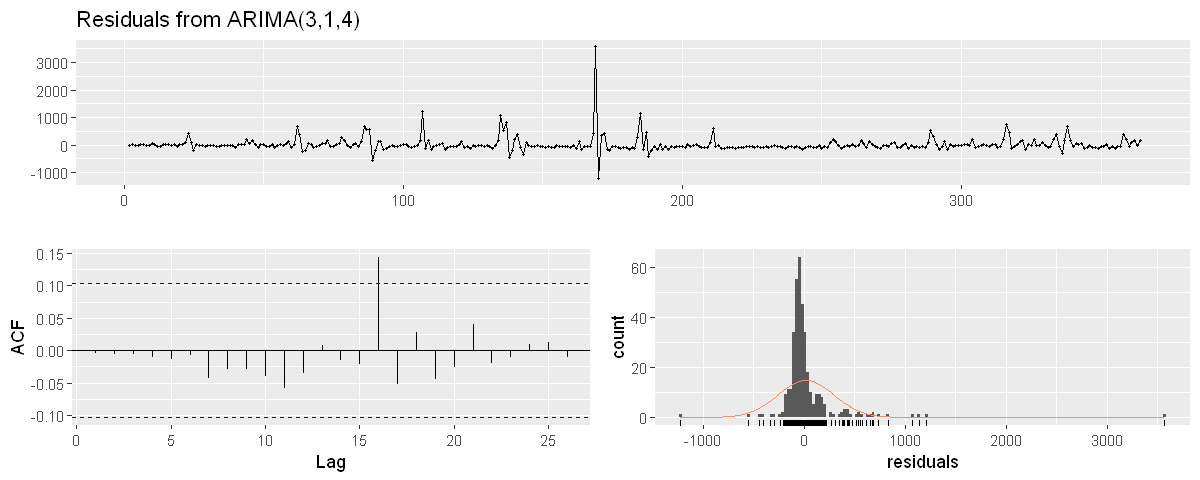

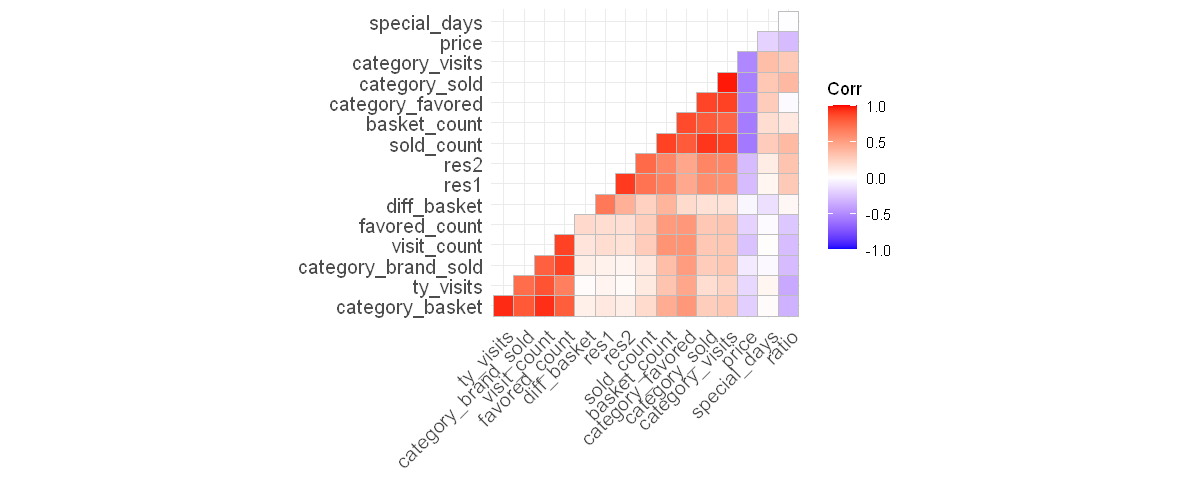

In [51]:
model_mendil_arimax <- arima(mendil_ts,order=c(3,1,4),xreg=mendil_train$diff_basket)
checkresiduals(model_mendil_arimax)
mendil_train$res2 <- model_mendil_arimax$residuals
corr <- cor(mendil_train[!is.na(mendil_train$price)& !is.na(mendil_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals are more stationary than the previous model. Variance looks more constant and the distribution have mean near to the zero.

In [52]:
forecast_data_mendil <- data.table(event_date=mendil[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=mendil[event_date>=test_start&event_date<=test_end,]$sold_count)
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- mendil[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(3,1,4))
  model_arimax <- Arima(train_dt$sold_count,order=c(3,1,4),xreg=train_dt$diff_basket)
  newreg <- forecast(auto.arima(train_dt$diff_basket),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  
}
forecast_data_mendil <- forecast_data_mendil[,`:=`(arima_p=arima_fc,
                                     arimax_p=arimax_fc)]
accu(forecast_data_mendil$sold_count,forecast_data_mendil$arima_p)
accu(forecast_data_mendil$sold_count,forecast_data_mendil$arimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,679.875,292.0638,0.4295846,0.2416599,0.1759965,313.3546,164.977,0.2426579,0.2426579


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,679.875,292.0638,0.4295846,0.2301436,0.1791047,312.9684,167.4289,0.2462642,0.2462642


While ARIMA model has WMAPE value of 0.242, ARIMAX model has 0.246 WMAPE. Although there is no significant difference, ARIMA model is selected as a final model. 

## PROD7 | Yuz Temizleyici, La Roche Posay

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


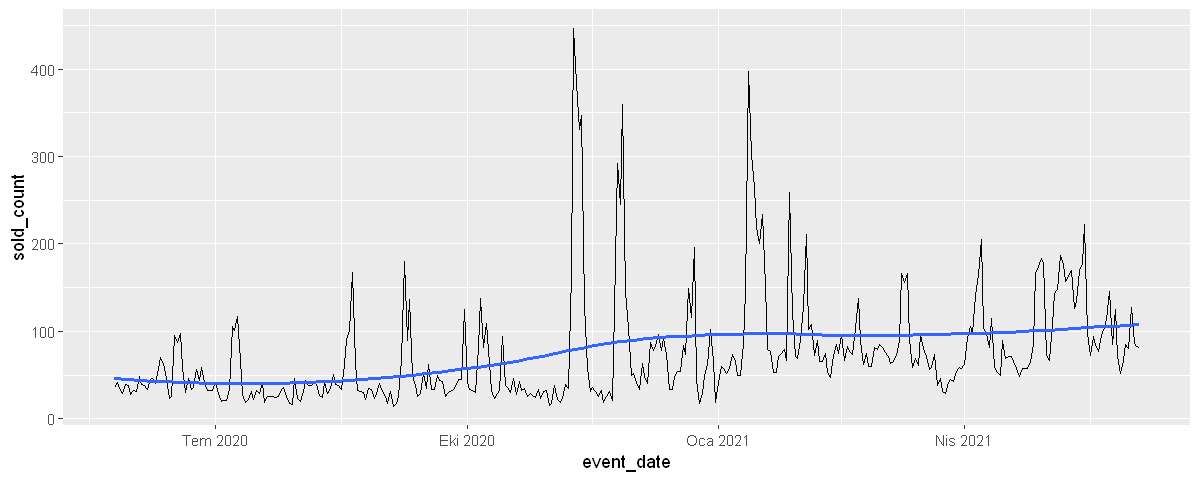

In [53]:
ggplot(prod7, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The variance is not constant over time. 
* By the blue line, it seems that there is a slightly increasing trend. 
* The mean changes over time. The data is not stationary. 
* Between November 2020 and December 2020, there are high number of sales. Also, there is a jumping point in the middle of January 2021. 

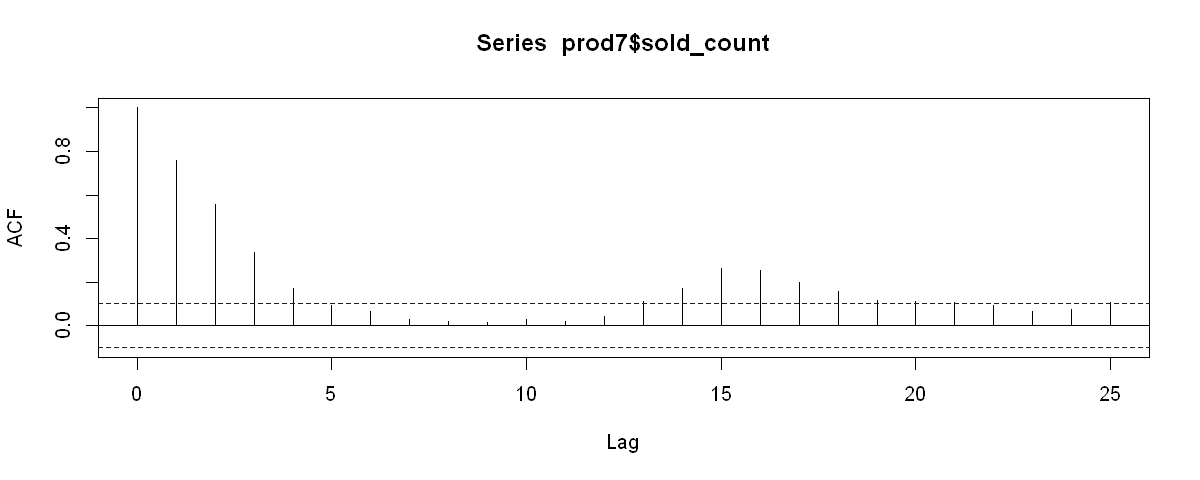

In [54]:
acf(prod7$sold_count)

First three lags and lag 15 have high correlation values. Now let's decompose the data. 

### Weekly Decomposition

Because the variance does not increase over time, additive decomposition will be used. 

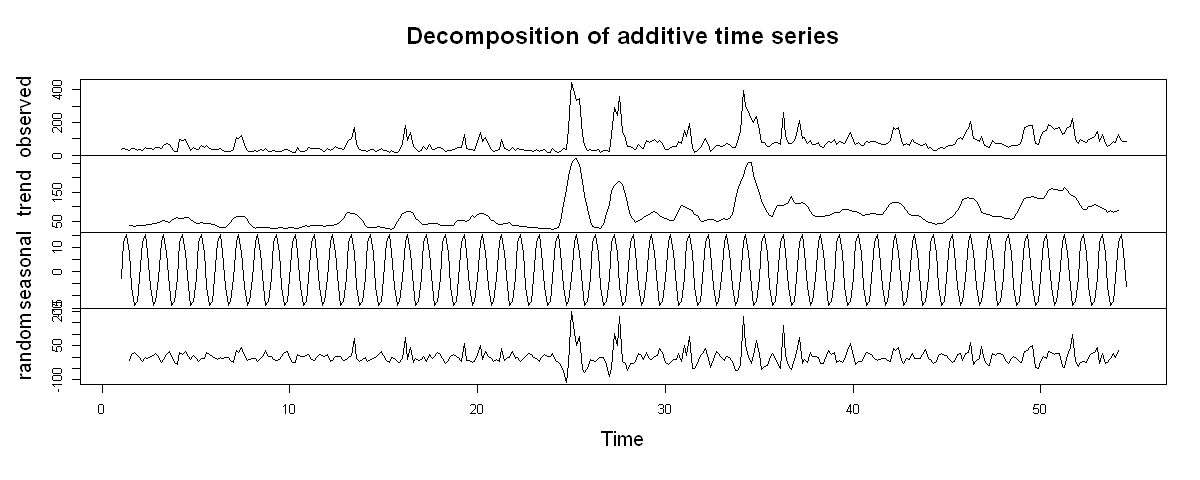

In [55]:
prod7_weekly_dec <- decompose(ts(prod7$sold_count, freq=7), type="additive")
plot(prod7_weekly_dec)

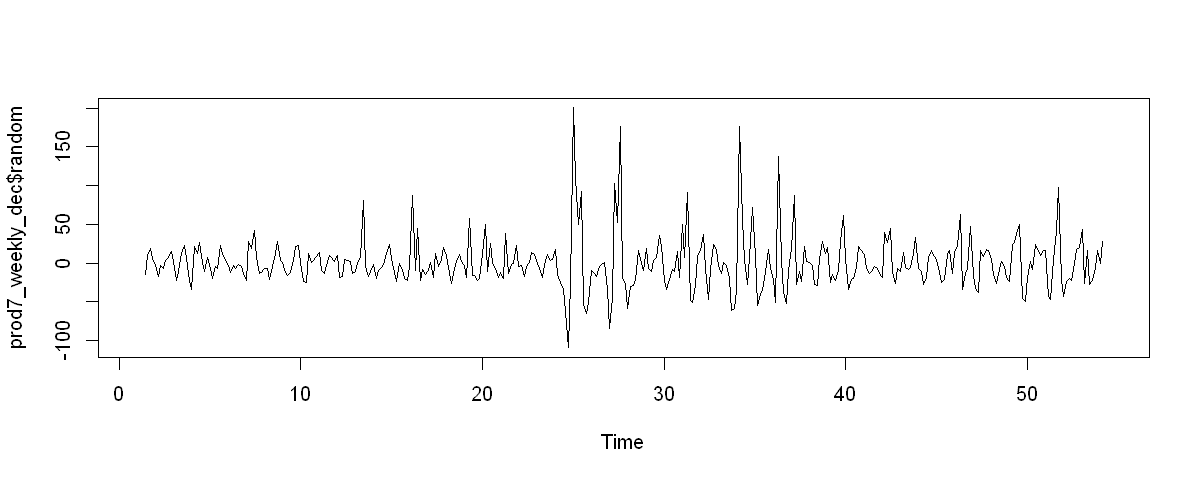

In [56]:
plot(prod7_weekly_dec$random)

* The variance changes over time. 
* The mean seems to be constant. 
* There are jumping points in the middle of the data. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [57]:
u_test <- ur.kpss(prod7_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0067 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the test results, it can be said that the data is stationary. 

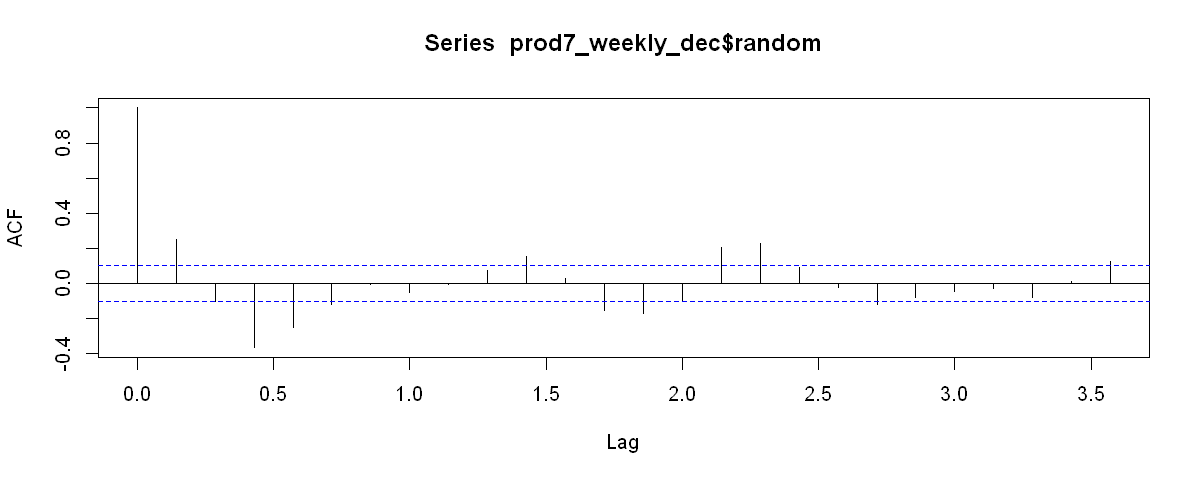

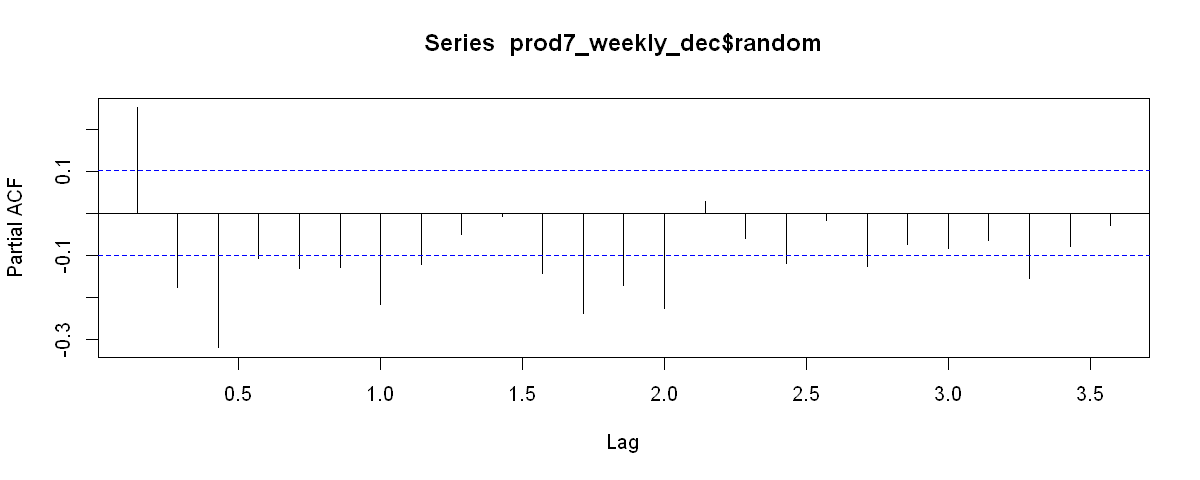

In [58]:
acf(prod7_weekly_dec$random, na.action=na.pass)
pacf(prod7_weekly_dec$random, na.action=na.pass)

The ACF graph is like a sinus wave. There are still correlatinons at different level of lags. 

### Monthly Decomposition

month,sold_count
2020 May,247
2020 Haz,1416
2020 Tem,1125
2020 Ağu,1360
2020 Eyl,1471
2020 Eki,1349
2020 Kas,3624
2020 Ara,2098
2021 Oca,3671
2021 Şub,2392


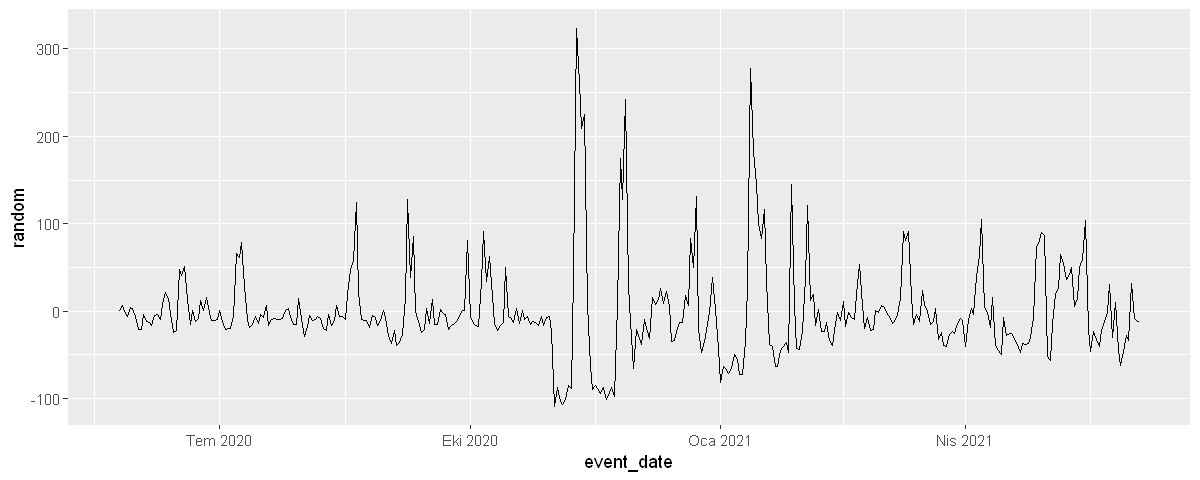

In [59]:
prod7_monthly <- prod7[, month:=yearmonth(event_date)]
prod7_monthly[, .(sold_count=sum(sold_count)), by=month]
prod7_monthly[, trend:=1:.N]

prod7_reg <- lm(sold_count~trend+as.factor(month), data=prod7_monthly)
prod7_monthly[, regOutput:=predict(prod7_reg, prod7_monthly)]

prod7_monthly[, random:=sold_count-regOutput]

ggplot(prod7_monthly, aes(x=event_date, y=random)) + geom_line()

* The mean seems to be constant over time. 
* The variance is not constant. 
 
Let's check the unit test result in order to see whether the data is stationary. 

In [60]:
u_test <- ur.kpss(prod7_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0098 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the KPSS test result, the data is stationary. 

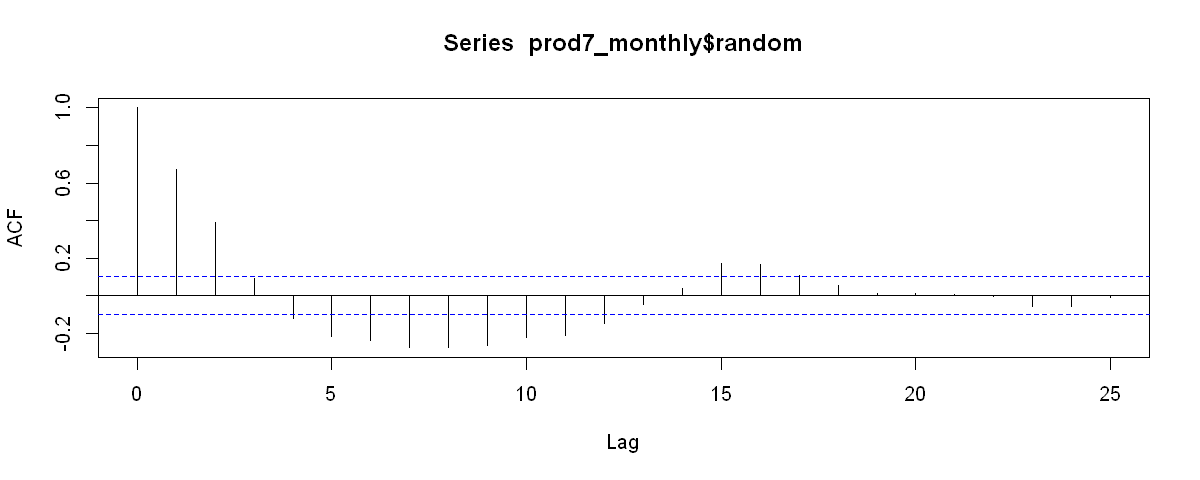

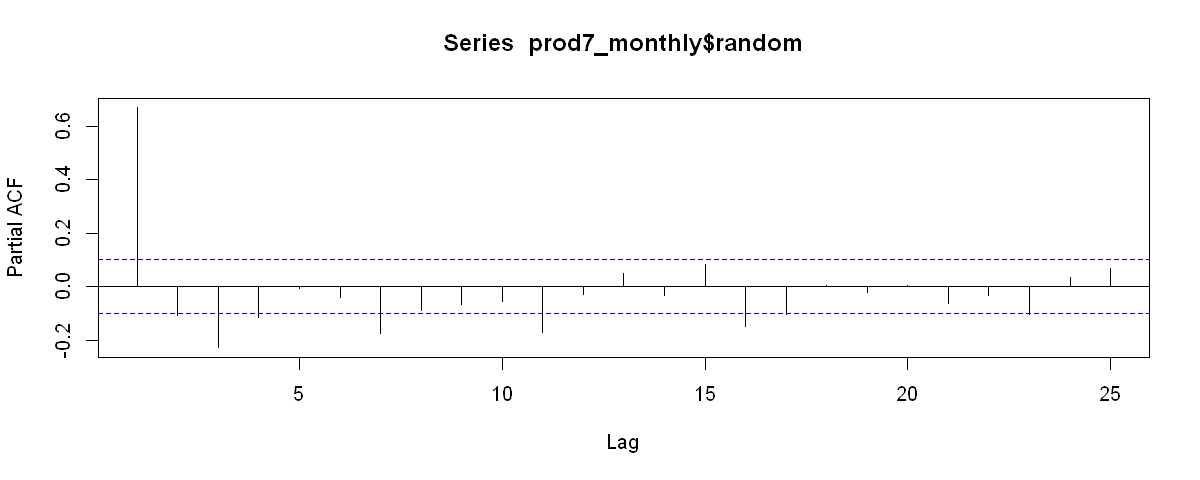

In [61]:
acf(prod7_monthly$random, na.action=na.pass)
pacf(prod7_monthly$random, na.action=na.pass)

It seems that there is a correlation at lag 1. 

### Building an ARIMA Model

In [62]:
jel <- data[product_content_id=="85004",][order(event_date)]
jel_train <- jel[event_date<test_start,]
jel_ts <- ts(jel_train$sold_count)

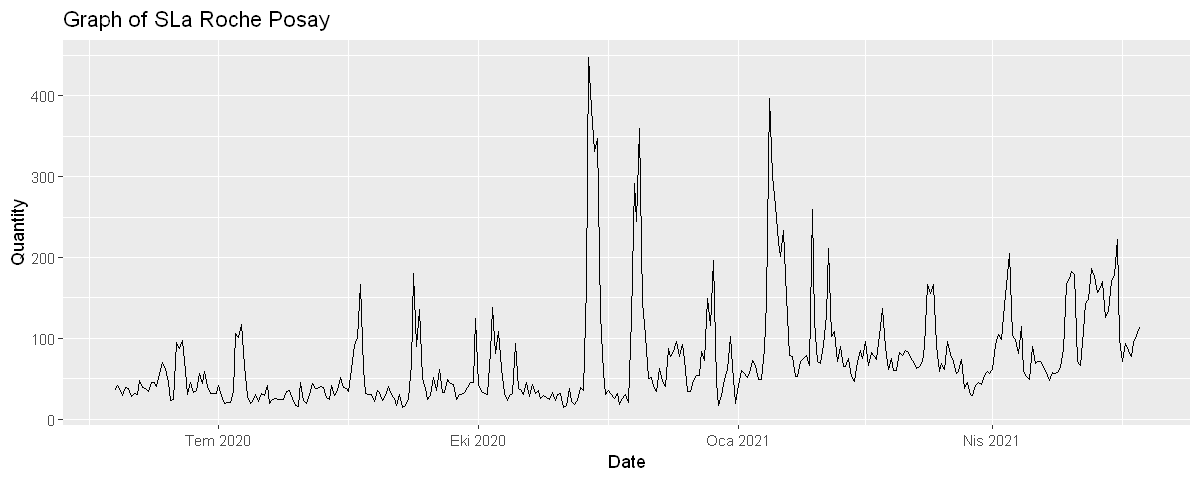

In [63]:
ggplot(jel_train,aes(x=event_date,y=sold_count)) + geom_line() +
labs(title= "Graph of SLa Roche Posay", x= "Date", y="Quantity")

Again, series are not stationariy. Analysis could start with differencing to make it stationary.

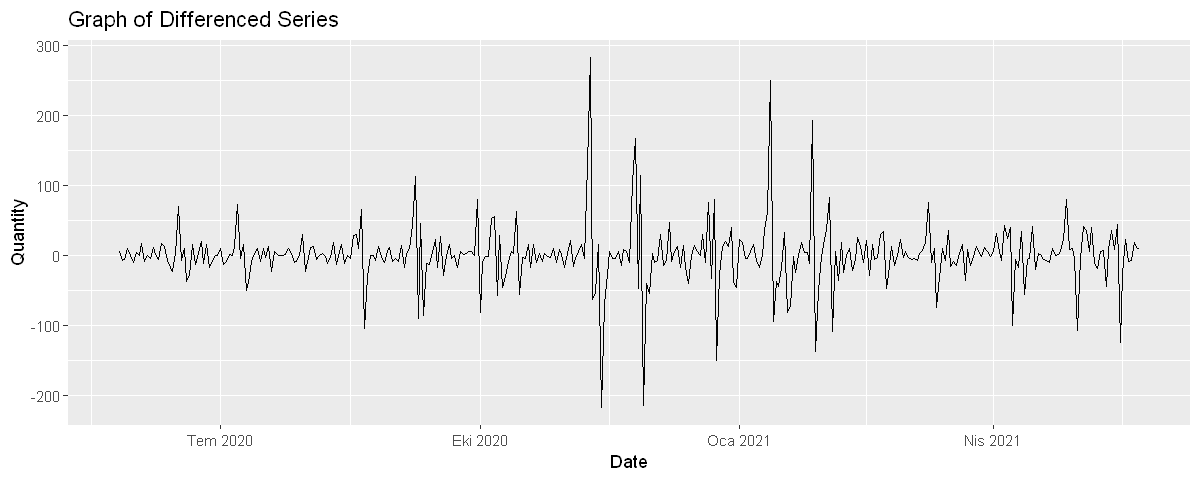

In [64]:
ggplot(jel_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(jel_train$sold_count,1))) + 
labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

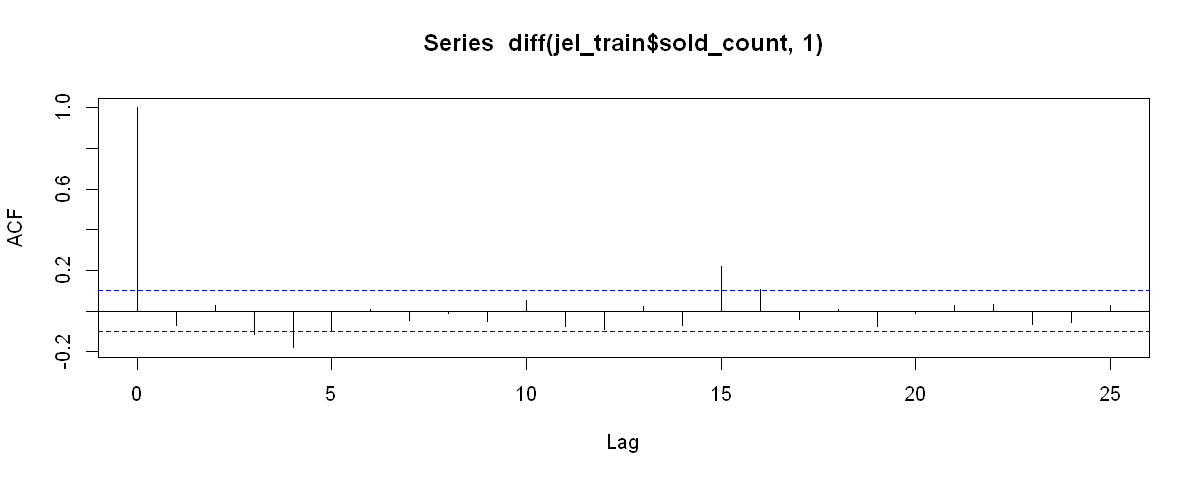

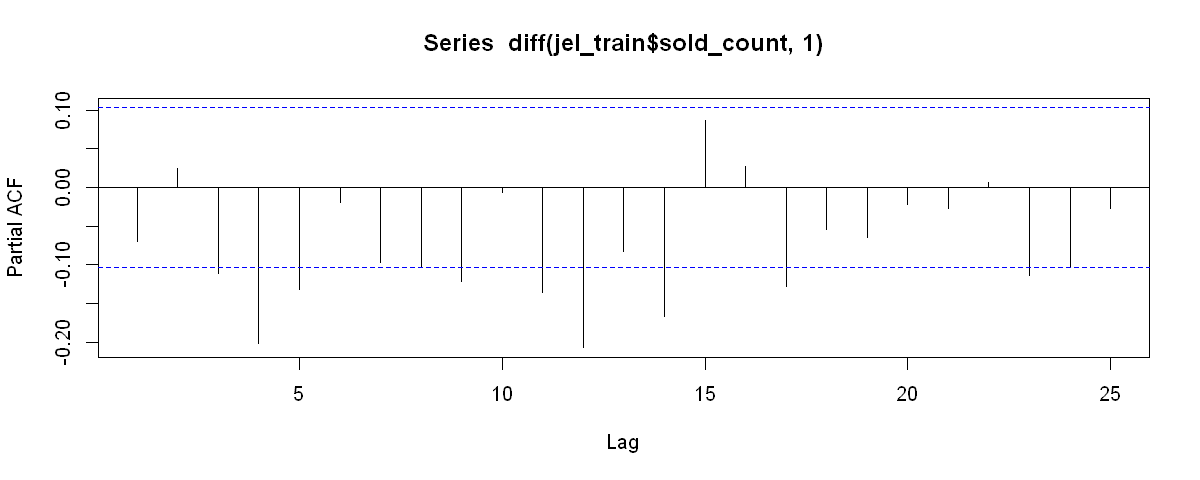

In [65]:
acf(diff(jel_train$sold_count,1))
pacf(diff(jel_train$sold_count,1))

In the ACF graph there is spikes at lag 3 and 4. Pacf graph shows spikes at lag 3 and 4 also. Decomposition tells there is no seasonality, so an ARIMA model could be constructed.

In [66]:
arima(jel_ts,order=c(3,1,3))


Call:
arima(x = jel_ts, order = c(3, 1, 3))

Coefficients:
         ar1      ar2     ar3      ma1     ma2      ma3
      0.9719  -0.7748  0.3516  -1.2006  0.9363  -0.7084
s.e.  0.1453   0.2380  0.1409   0.1262  0.2284   0.1383

sigma^2 estimated as 1606:  log likelihood = -1855.88,  aic = 3725.75

In [67]:
arima(jel_ts,order=c(4,1,3))


Call:
arima(x = jel_ts, order = c(4, 1, 3))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3
      0.8446  -0.6518  0.3707  -0.0791  -1.0604  0.7562  -0.6639
s.e.  0.2142   0.2993  0.1500   0.0770   0.2070  0.3244   0.1647

sigma^2 estimated as 1602:  log likelihood = -1855.34,  aic = 3726.67

In [68]:
arima(jel_ts,order=c(3,1,4))


Call:
arima(x = jel_ts, order = c(3, 1, 4))

Coefficients:
         ar1      ar2     ar3      ma1     ma2      ma3      ma4
      0.7270  -0.5483  0.2528  -0.9454  0.6316  -0.5392  -0.1122
s.e.  0.3479   0.3872  0.1933   0.3469  0.4561   0.2550   0.1310

sigma^2 estimated as 1603:  log likelihood = -1855.5,  aic = 3727

In [69]:
arima(jel_ts,order=c(4,1,4))

Warning message in sqrt(diag(x$var.coef)):
"NaNs üretimi"


Call:
arima(x = jel_ts, order = c(4, 1, 4))

Coefficients:
         ar1     ar2      ar3     ar4      ma1     ma2      ma3      ma4
      0.2176  -0.044  -0.2196  0.2537  -0.4453  0.0309  -0.0125  -0.5252
s.e.     NaN     NaN      NaN     NaN      NaN     NaN      NaN      NaN

sigma^2 estimated as 1606:  log likelihood = -1855.87,  aic = 3729.74

In [70]:
auto.arima(jel_ts)

Series: jel_ts 
ARIMA(0,1,0) 

sigma^2 estimated as 1929:  log likelihood=-1888.04
AIC=3778.07   AICc=3778.08   BIC=3781.97

The best model is ARIMA(3,1,3) with an AIC of 3725.75. Thus, we could use it in forecast steps.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)
Q* = 5.1167, df = 4, p-value = 0.2755

Model df: 6.   Total lags used: 10



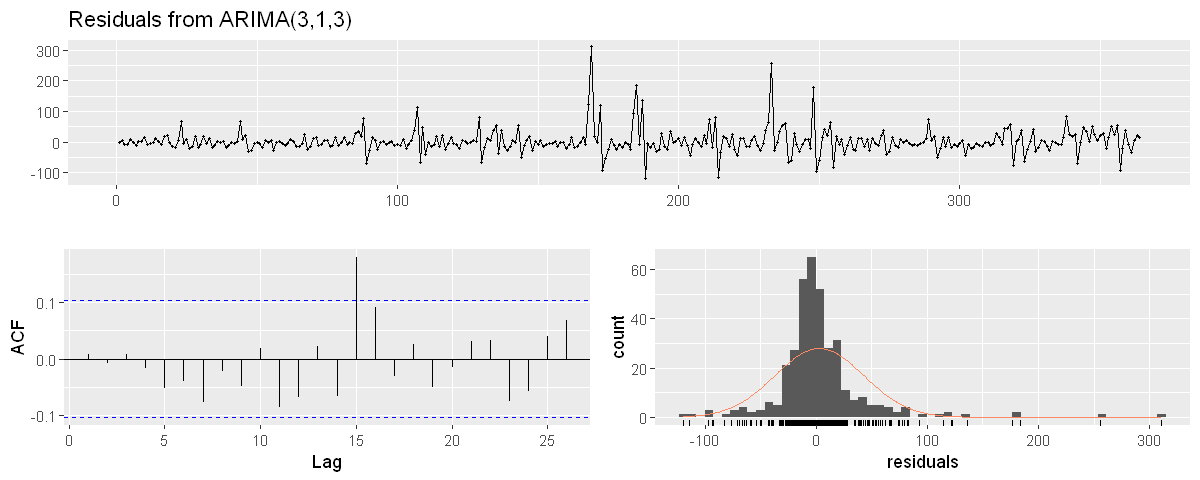

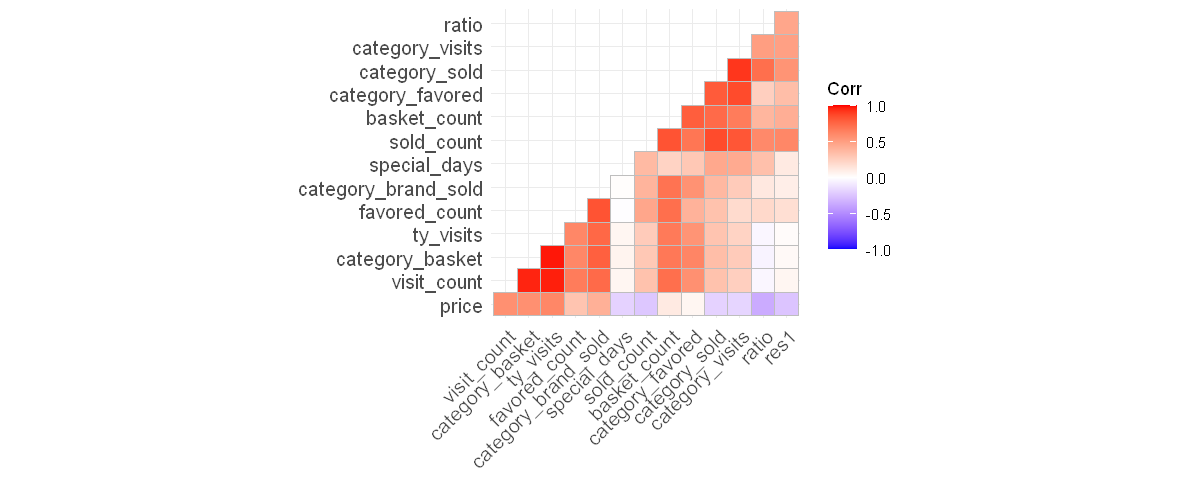

In [71]:
model_jel_arima <- arima(jel_ts,order=c(3,1,3))
checkresiduals(model_jel_arima)
jel_train$res1 <- model_jel_arima$residuals
corr <- cor(jel_train[!is.na(jel_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have constant mean at 0 and variance looks constant although there is some outliers. There is not lags with correlation. Distribution is slightly right skewed. Residuals are correlated with category_visits.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


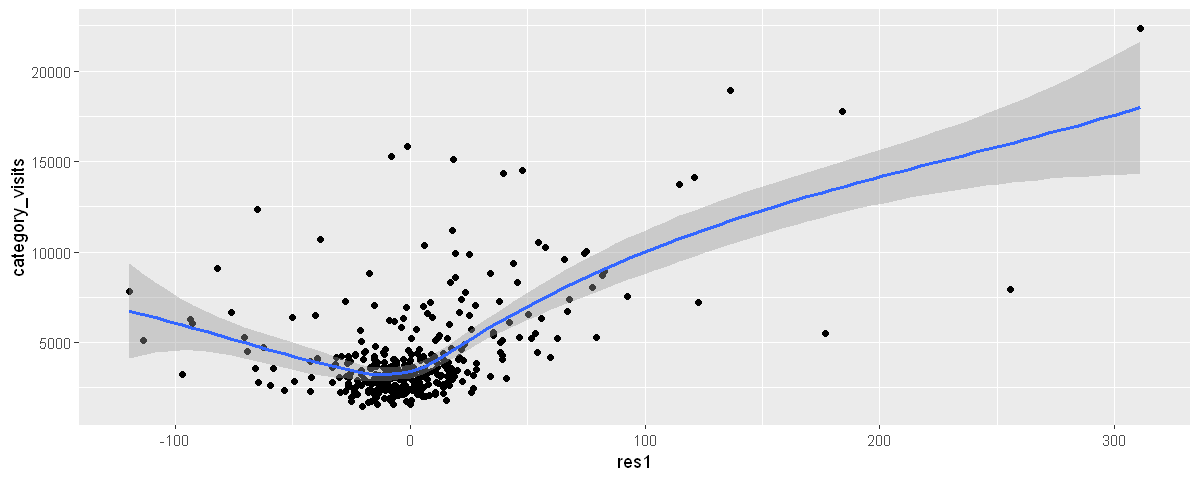

In [72]:
ggplot(jel_train,aes(x=res1,y=category_visits)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


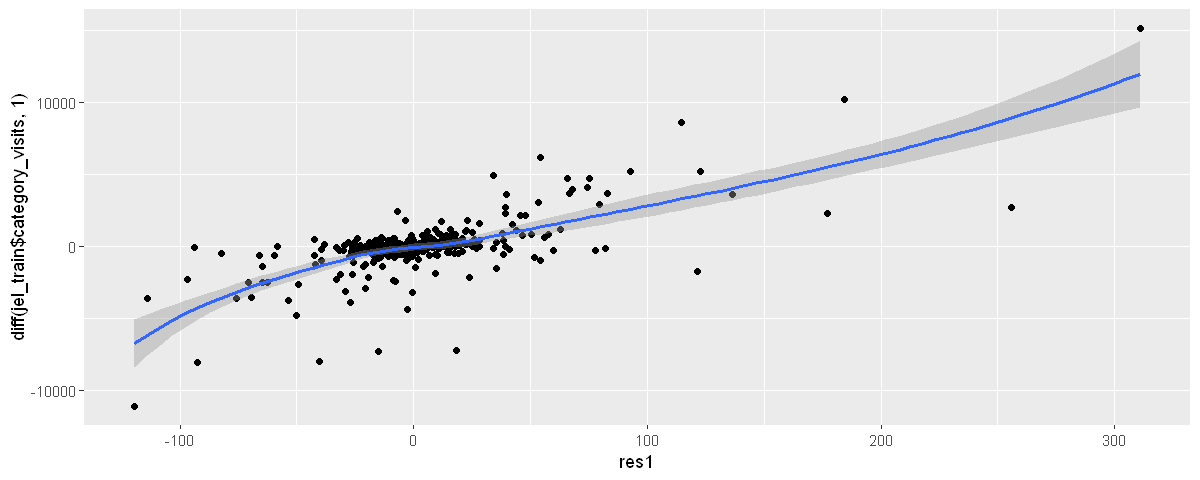

In [73]:
ggplot(jel_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(jel_train$category_visits,1))) +
geom_smooth(aes(y=diff(jel_train$category_visits,1)))

In [74]:
cor(jel_train[2:.N]$res1,diff(jel_train$category_visits,1))
jel_train$diff_visits <- c(NA,diff(jel_train$category_visits,1))
jel$diff_visits <- c(NA,diff(jel$category_visits,1))

[1] 0.6982217

Differenced category_visits is highlt correlated with residuals with a value of 0.694. We could add it as a regressor.

In [75]:
arima(jel_ts,order=c(3,1,3),xreg=jel_train$diff_visits)


Call:
arima(x = jel_ts, order = c(3, 1, 3), xreg = jel_train$diff_visits)

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3  jel_train$diff_visits
      0.5580  0.4449  -0.3778  -0.5677  -0.5776  0.1745                 0.0096
s.e.  0.2634  0.3364   0.1783   0.2739   0.3501  0.1982                 0.0007

sigma^2 estimated as 1112:  log likelihood = -1784.21,  aic = 3584.42

In [76]:
auto.arima(jel_ts,xreg=jel_train$diff_visits)

Series: jel_ts 
Regression with ARIMA(1,1,0) errors 

Coefficients:
         ar1    xreg
      0.1368  0.0095
s.e.  0.0520  0.0007

sigma^2 estimated as 1318:  log likelihood=-1813.45
AIC=3632.89   AICc=3632.96   BIC=3644.57


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)
Q* = 3.8304, df = 3, p-value = 0.2804

Model df: 7.   Total lags used: 10



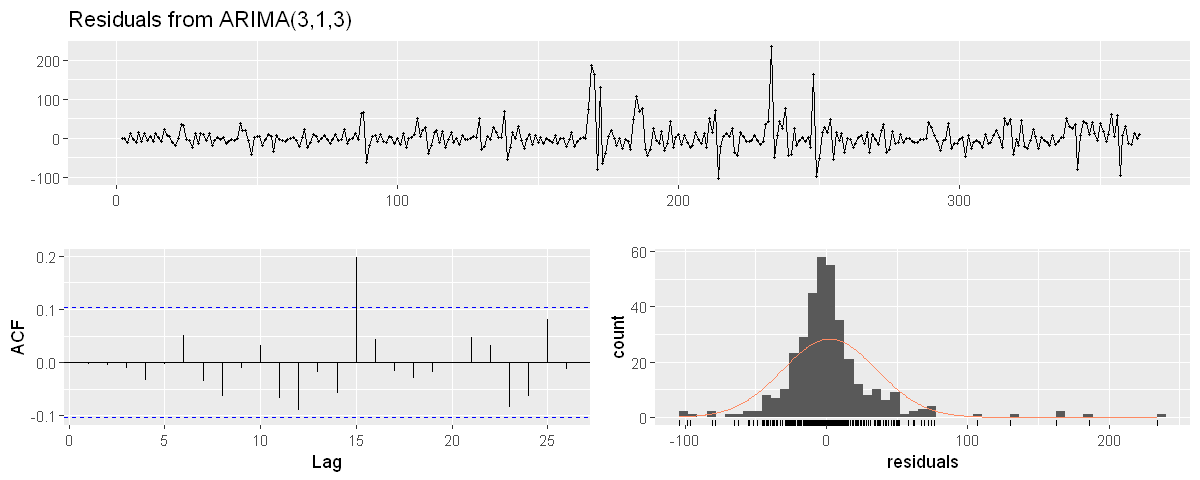

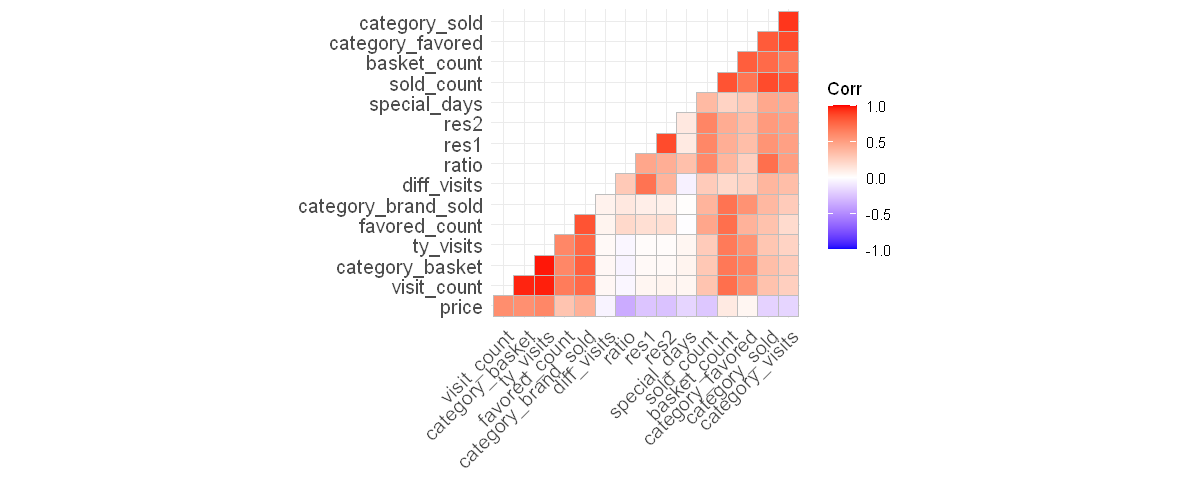

In [77]:
model_jel_arimax <- arima(jel_ts,order=c(3,1,3),xreg=jel_train$diff_visits)
checkresiduals(model_jel_arimax)
jel_train$res2 <- model_jel_arimax$residuals
corr <- cor(jel_train[!is.na(jel_train$price)& !is.na(jel_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals don't look changed much in the stationary manner. However, we could see its success in the test period.

In [78]:
forecast_data_jel <- data.table(event_date=jel[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=jel[event_date>=test_start&event_date<=test_end,]$sold_count)
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- jel[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(3,1,4))
  model_arimax <- Arima(train_dt$sold_count,order=c(3,1,4),xreg=train_dt$diff_visits)
  newreg <- forecast(auto.arima(train_dt$diff_visits),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  
}
forecast_data_jel <- forecast_data_jel[,`:=`(arima_p=arima_fc,
                                     arimax_p=arimax_fc)]
accu(forecast_data_jel$sold_count,forecast_data_jel$arima_p)
accu(forecast_data_jel$sold_count,forecast_data_jel$arimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,88.875,31.24757,0.3515901,-0.08071422,0.3223797,31.68339,26.8465,0.3020704,0.3020704


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,88.875,31.24757,0.3515901,0.006840122,0.4777621,46.18615,38.85239,0.4371577,0.4371577


ARIMA model gives significantly better results with a WMAPE value of 0.302, thus ARIMA model is selected as the final model.

## PROD6 | Dik Supurge, Fakir

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


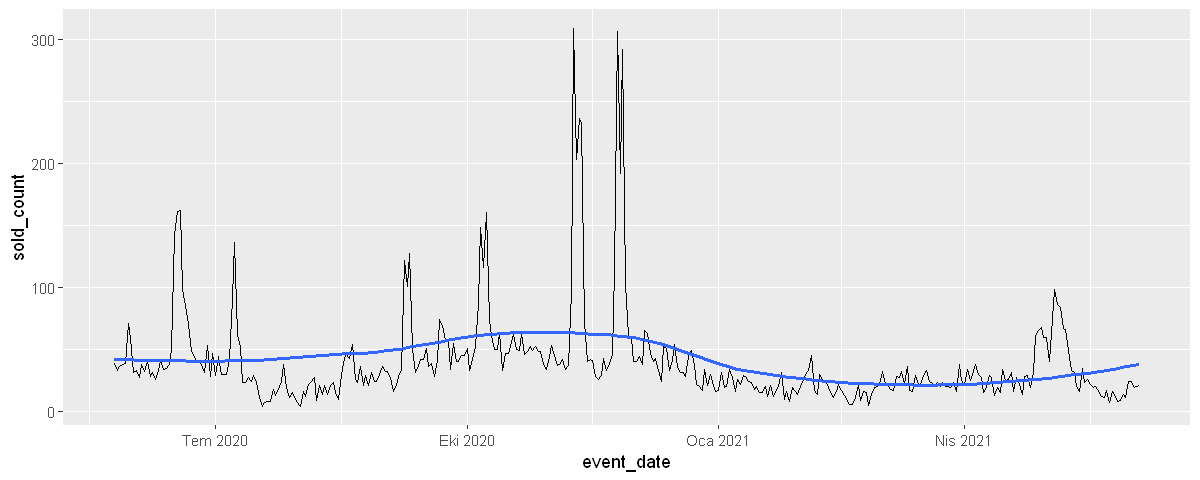

In [79]:
ggplot(prod6, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* By the blue line, it seems that there is a sinus wave shaped trend in the data. The mean is not constant over time.  
* The variance changes. 
* Between November 2020 and December 2020, there are high sales. 
* The data seems not to be stationary. 

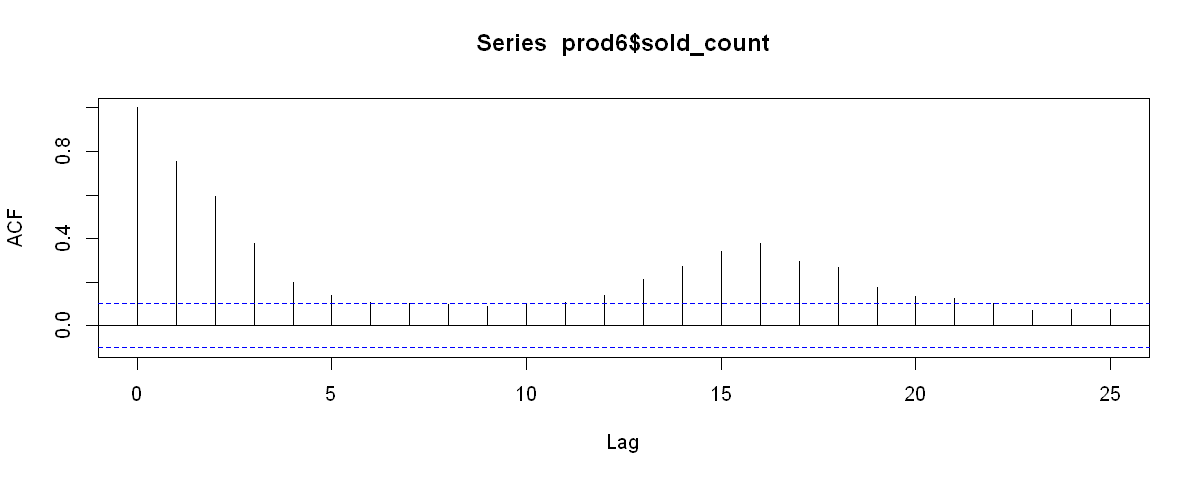

In [80]:
acf(prod6$sold_count)

On the graph above, there is a peak point at lag 16. 

### Weekly Decomposition

Additive decomposition will be used due to the non-increasing variance. 

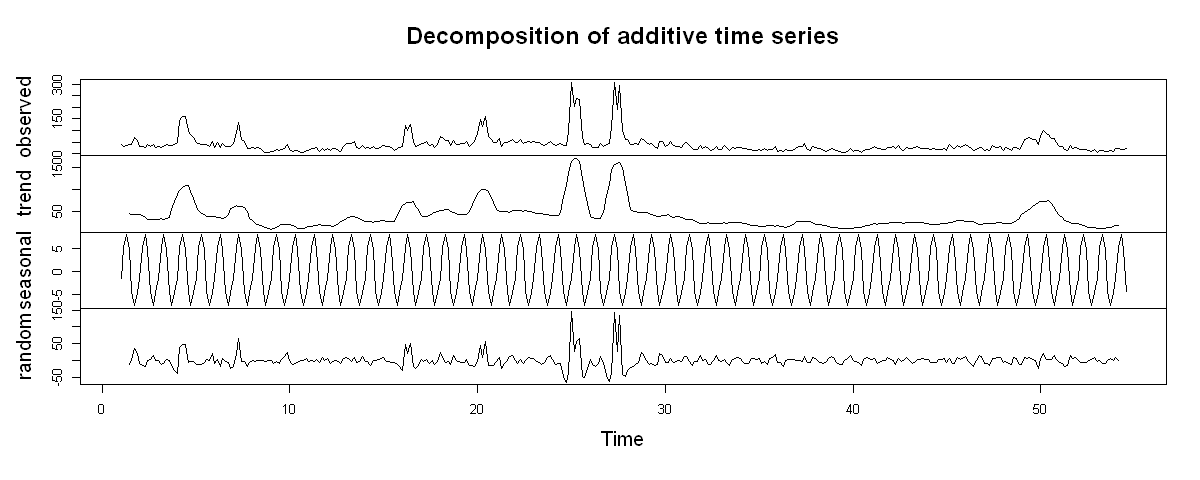

In [81]:
prod6_weekly_dec <- decompose(ts(prod6$sold_count, freq=7), type="additive")
plot(prod6_weekly_dec)

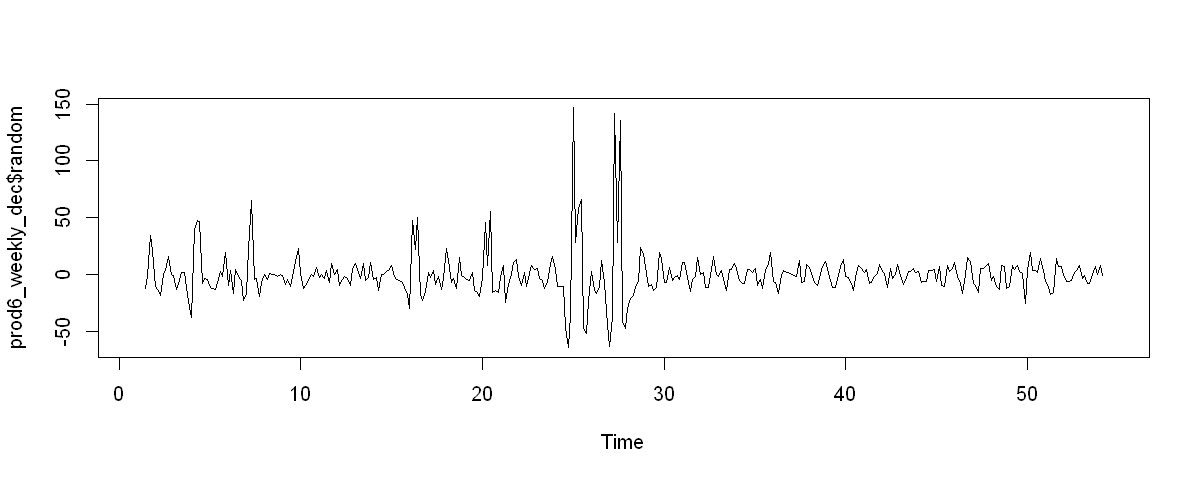

In [82]:
plot(prod6_weekly_dec$random)

* The mean is constant. 
* The variance slightly changes over time. 

In [83]:
u_test <- ur.kpss(prod6_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0066 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS test above, it can be said that the data is stationary. 

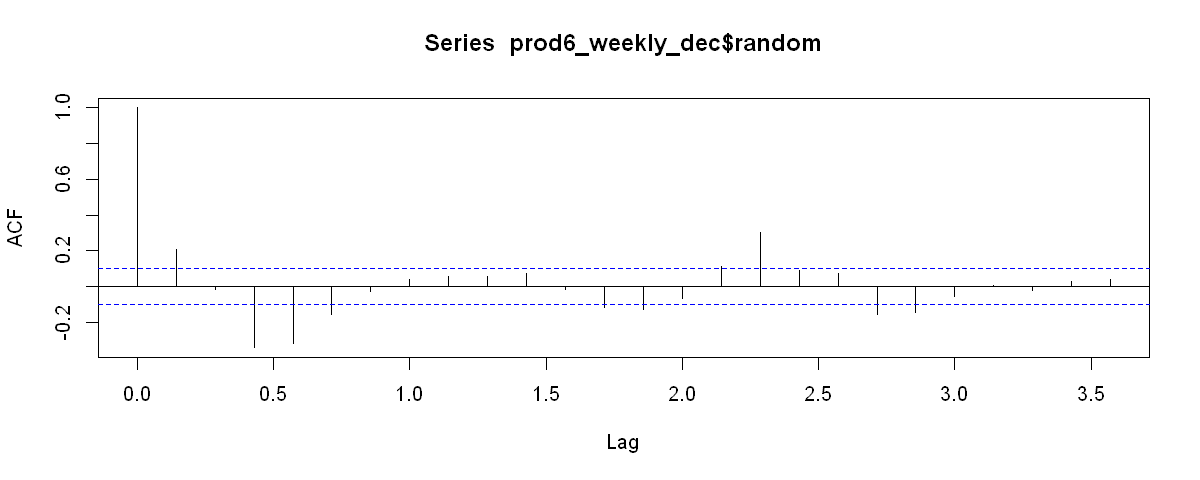

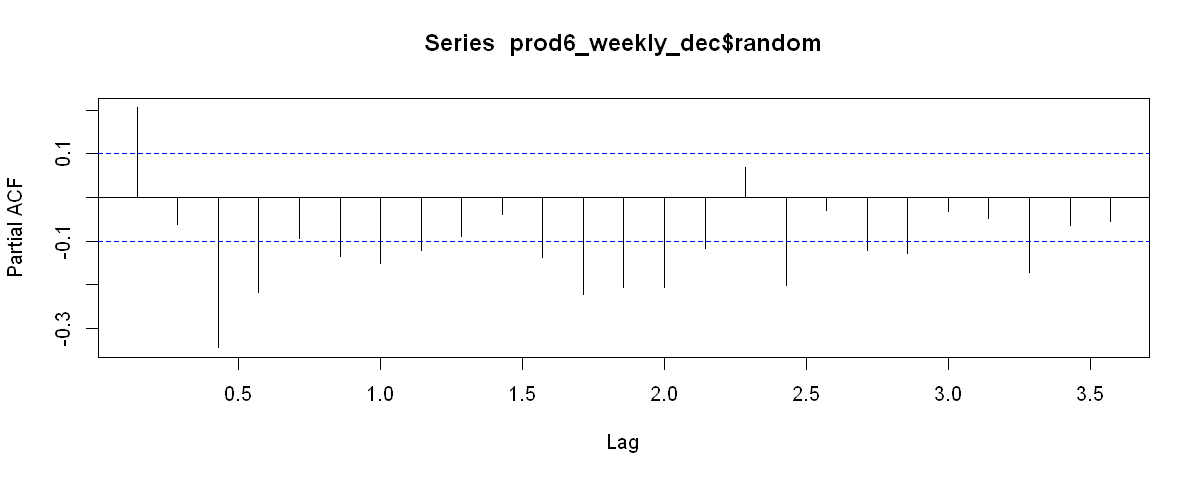

In [84]:
acf(prod6_weekly_dec$random, na.action=na.pass)
pacf(prod6_weekly_dec$random, na.action=na.pass)

There are slightly correlations at different level of lags. 

### Monthly Decomposition

month,sold_count
2020 May,315
2020 Haz,1608
2020 Tem,908
2020 Ağu,770
2020 Eyl,1451
2020 Eki,1850
2020 Kas,2931
2020 Ara,1145
2021 Oca,621
2021 Şub,512


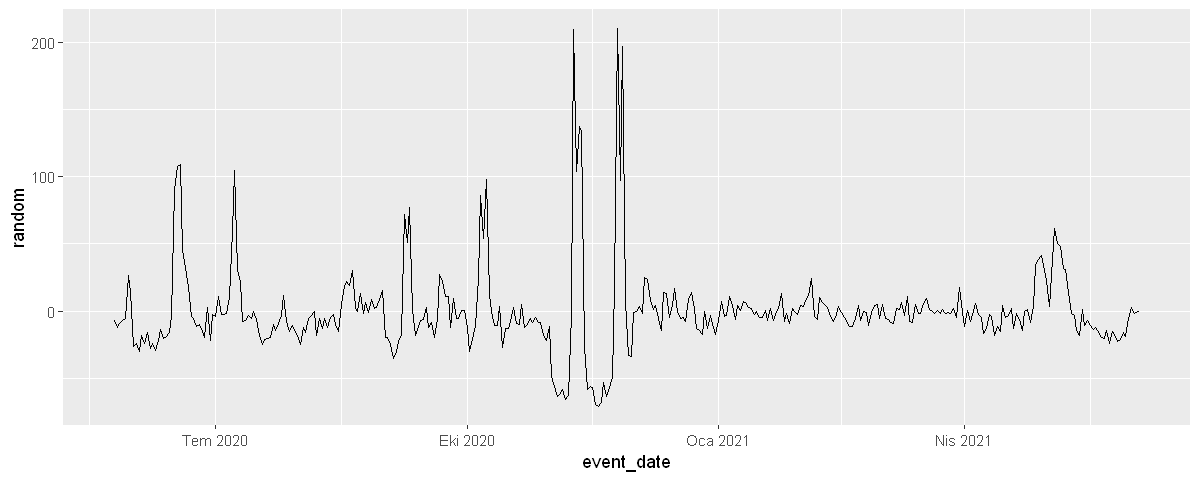

In [85]:
prod6_monthly <- prod6[, month:=yearmonth(event_date)]
prod6_monthly[, .(sold_count=sum(sold_count)), by=month]
prod6_monthly[, trend:=1:.N]

prod6_reg <- lm(sold_count~trend+as.factor(month), data=prod6_monthly)
prod6_monthly[, regOutput:=predict(prod6_reg, prod6_monthly)]

prod6_monthly[, random:=sold_count-regOutput]

ggplot(prod6_monthly, aes(x=event_date, y=random)) + geom_line()

* The mean is constant. 
* The variance seems to be non-constant. 

In [86]:
u_test <- ur.kpss(prod6_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0139 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The test result says that monthly decomposed data is stationary. 

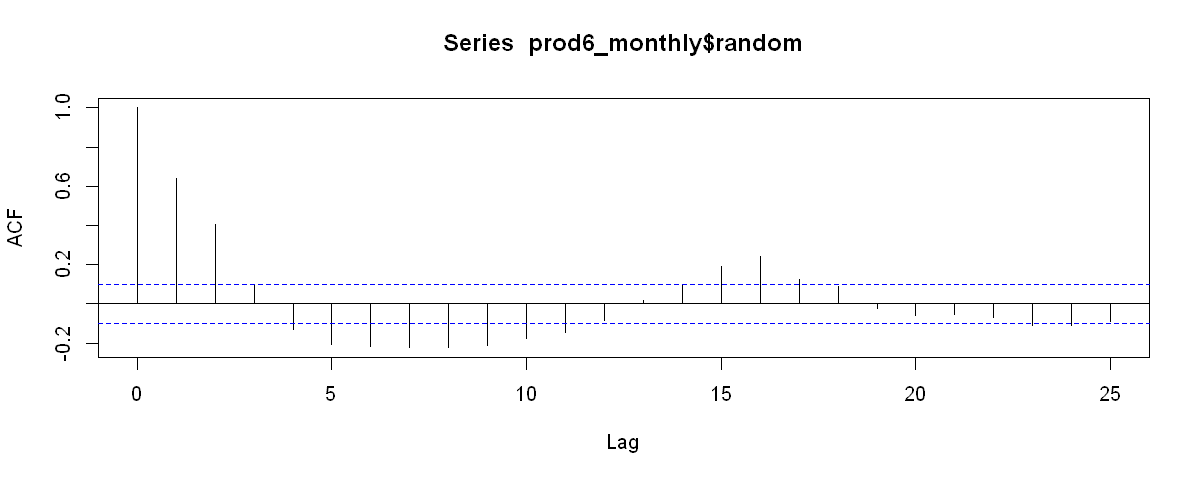

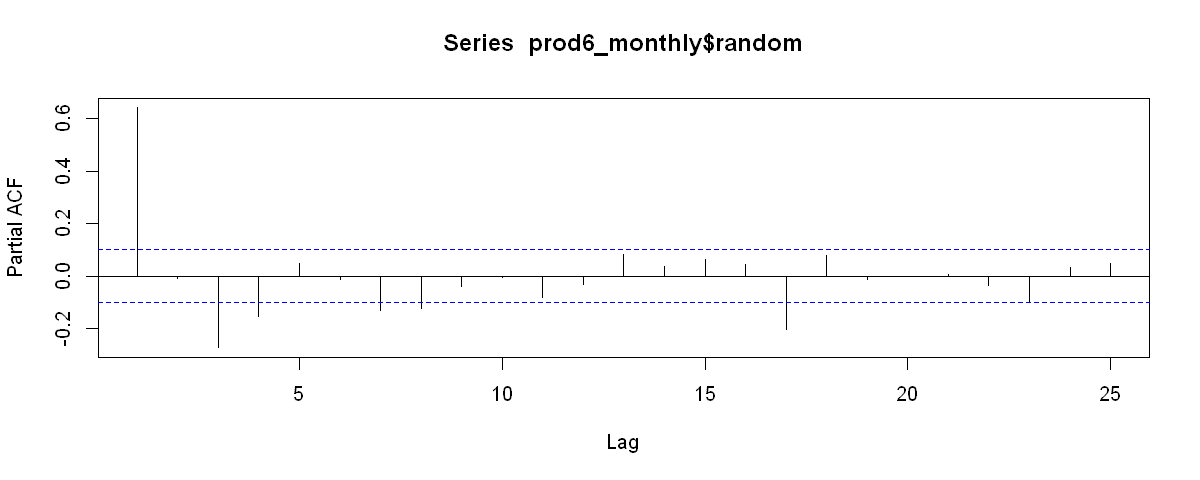

In [87]:
acf(prod6_monthly$random)
pacf(prod6_monthly$random)

The ACF graph is  like sinus wave with a peak value at lag 16. Also a high correlation with lag 1 can be seen on the PACF graph. 

### Building an ARIMA Model

In [88]:
fakir <- data[product_content_id=="7061886",][order(event_date)]
fakir_train <- fakir[event_date<test_start,]
fakir_ts <- ts(fakir_train$sold_count)

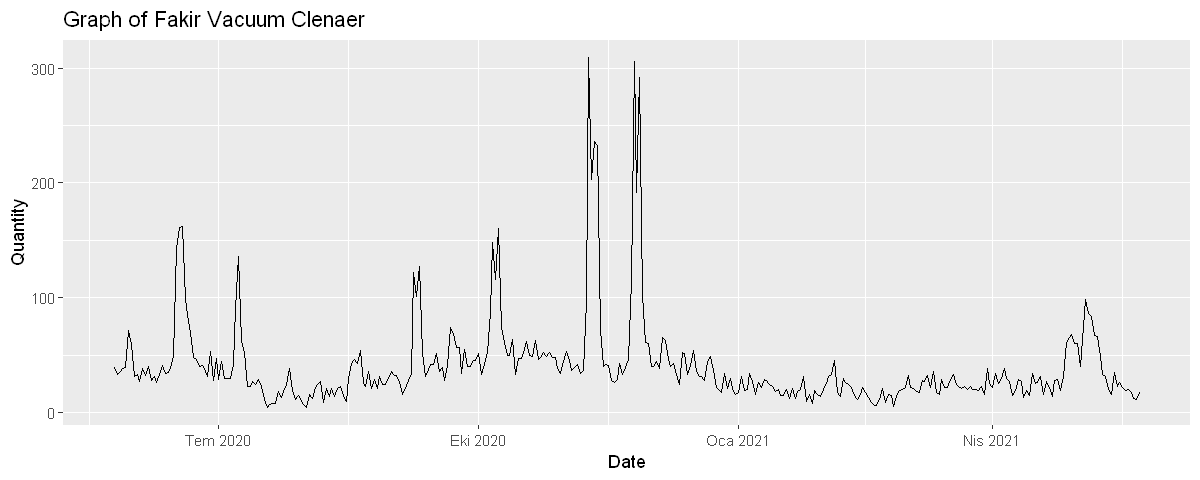

In [89]:
ggplot(fakir_train,aes(x=event_date,y=sold_count)) + geom_line() +
labs(title= "Graph of Fakir Vacuum Clenaer", x= "Date", y="Quantity")

Fakir vacuum cleaner data is not stationary, because of the trend and outliers.

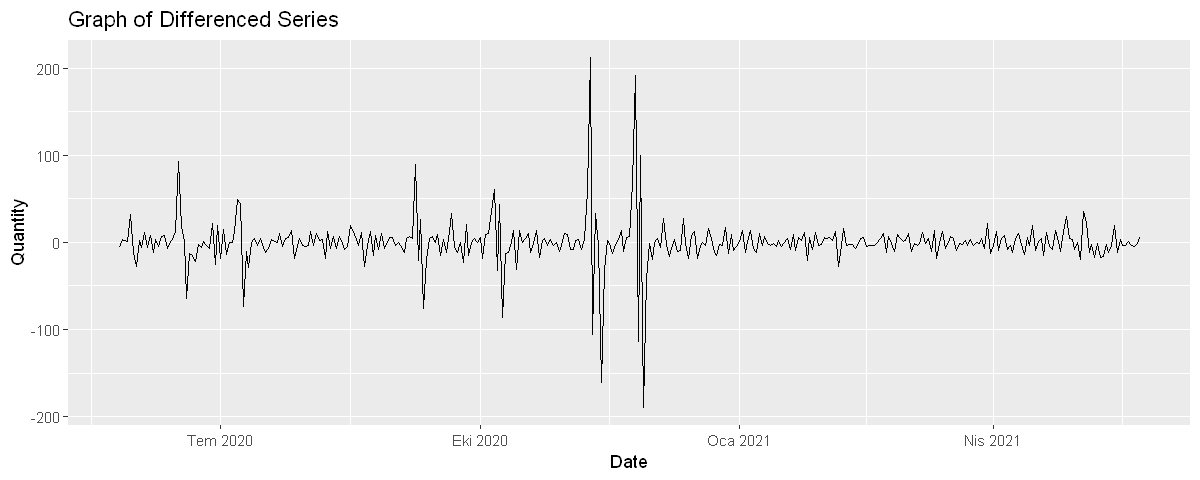

In [90]:
ggplot(fakir_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(fakir_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

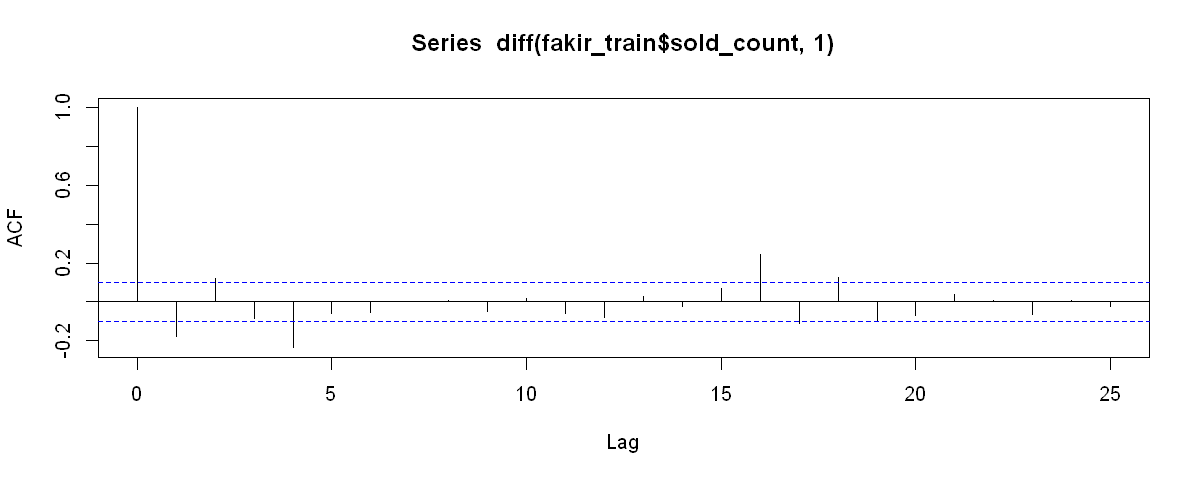

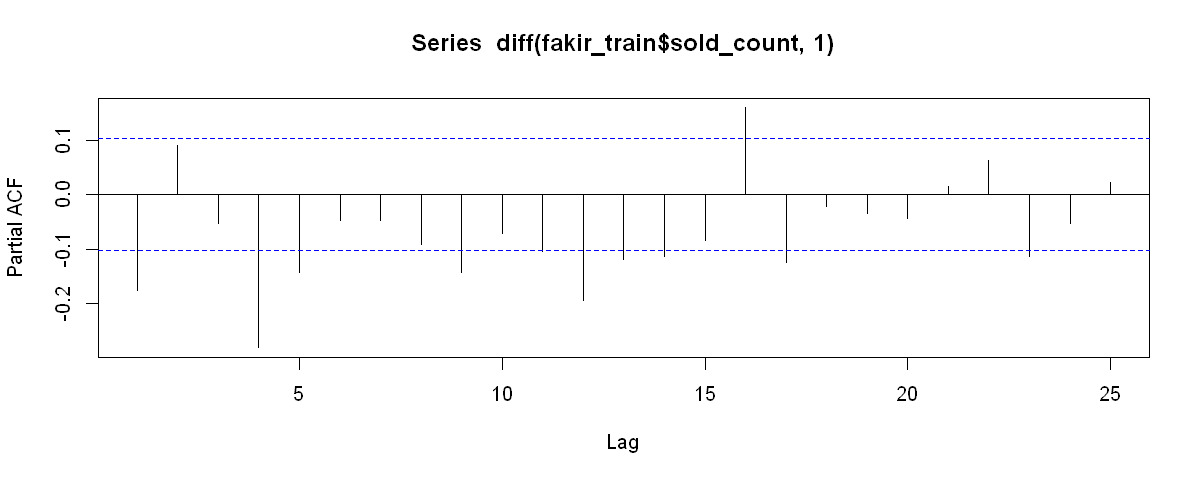

In [91]:
acf(diff(fakir_train$sold_count,1))
pacf(diff(fakir_train$sold_count,1))

After analyzing the ACF and PACF graphs of the differenced series, AR(1), AR(4), MA(1) and MA(4) models could be tried as a ARIMA model.

In [92]:
arima(fakir_ts,order=c(1,1,1))


Call:
arima(x = fakir_ts, order = c(1, 1, 1))

Coefficients:
          ar1     ma1
      -0.4583  0.2851
s.e.   0.1590  0.1671

sigma^2 estimated as 744.4:  log likelihood = -1715.27,  aic = 3436.55

In [93]:
arima(fakir_ts,order=c(4,1,1))


Call:
arima(x = fakir_ts, order = c(4, 1, 1))

Coefficients:
         ar1     ar2      ar3      ar4      ma1
      0.6148  0.2201  -0.1482  -0.1645  -0.9247
s.e.  0.0571  0.0604   0.0602   0.0543   0.0283

sigma^2 estimated as 625.1:  log likelihood = -1684.24,  aic = 3380.49

In [94]:
arima(fakir_ts,order=c(1,1,4))


Call:
arima(x = fakir_ts, order = c(1, 1, 4))

Coefficients:
         ar1      ma1     ma2      ma3      ma4
      0.3032  -0.5997  0.1549  -0.2172  -0.2531
s.e.  0.1266   0.1244  0.0791   0.0609   0.0737

sigma^2 estimated as 615.5:  log likelihood = -1681.49,  aic = 3374.99

In [95]:
arima(fakir_ts,order=c(4,1,4))


Call:
arima(x = fakir_ts, order = c(4, 1, 4))

Coefficients:
         ar1     ar2      ar3      ar4      ma1     ma2      ma3      ma4
      0.2539  0.1229  -0.0803  -0.0434  -0.5499  0.0180  -0.1092  -0.2597
s.e.  0.4365  0.3870   0.2501   0.1614   0.4348  0.5031   0.3670   0.3018

sigma^2 estimated as 614.4:  log likelihood = -1681.17,  aic = 3380.35

In [96]:
auto.arima(fakir_ts)

Series: fakir_ts 
ARIMA(0,1,5) 

Coefficients:
          ma1     ma2      ma3      ma4      ma5
      -0.3009  0.0561  -0.2064  -0.3117  -0.1085
s.e.   0.0514  0.0531   0.0542   0.0522   0.0516

sigma^2 estimated as 624.7:  log likelihood=-1681.66
AIC=3375.32   AICc=3375.56   BIC=3398.69

The best model is ARIMA(1,1,4) with the AIC value of 3374.99


	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)
Q* = 1.8327, df = 5, p-value = 0.8718

Model df: 5.   Total lags used: 10



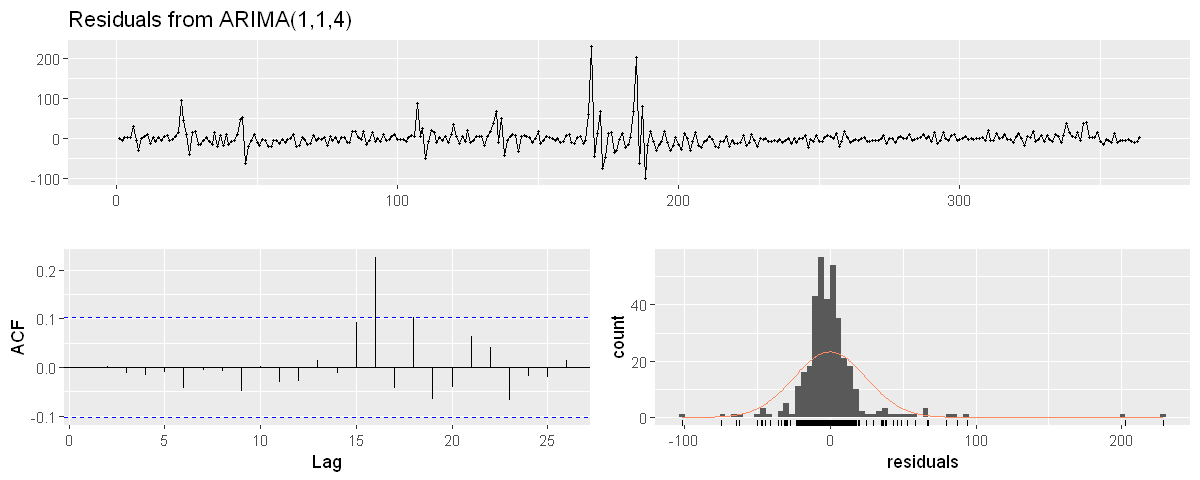

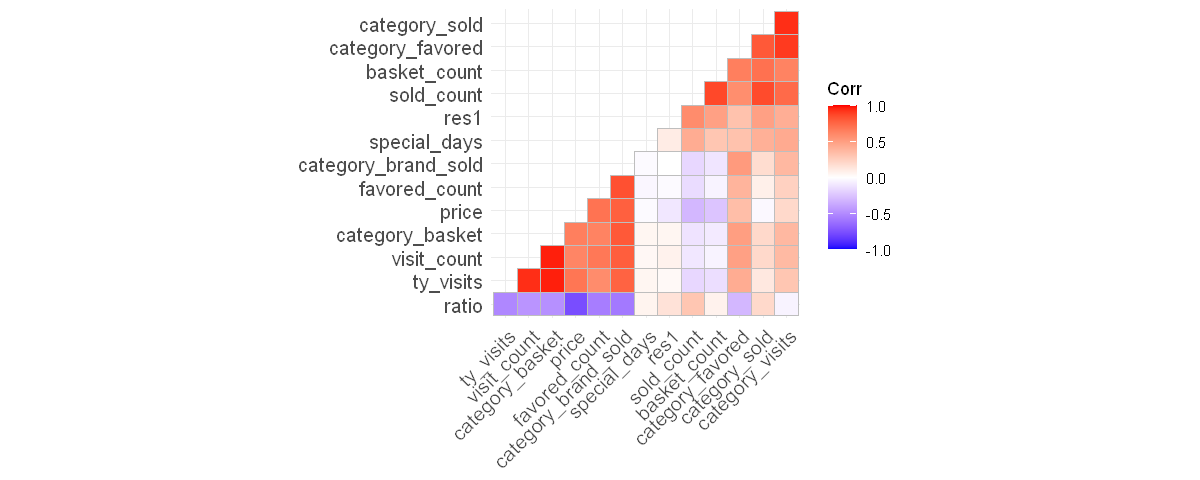

In [97]:
model_fakir_arima <- arima(fakir_ts,order=c(1,1,4))
checkresiduals(model_fakir_arima)
fakir_train$res1 <- model_fakir_arima$residuals
corr <- cor(fakir_train[!is.na(fakir_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals seem stationary with a constant mean of 0 and nearly constant variance. Histogram of the residuals look as a normal distribution. Category_sold attribute is correlated with the residuals.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


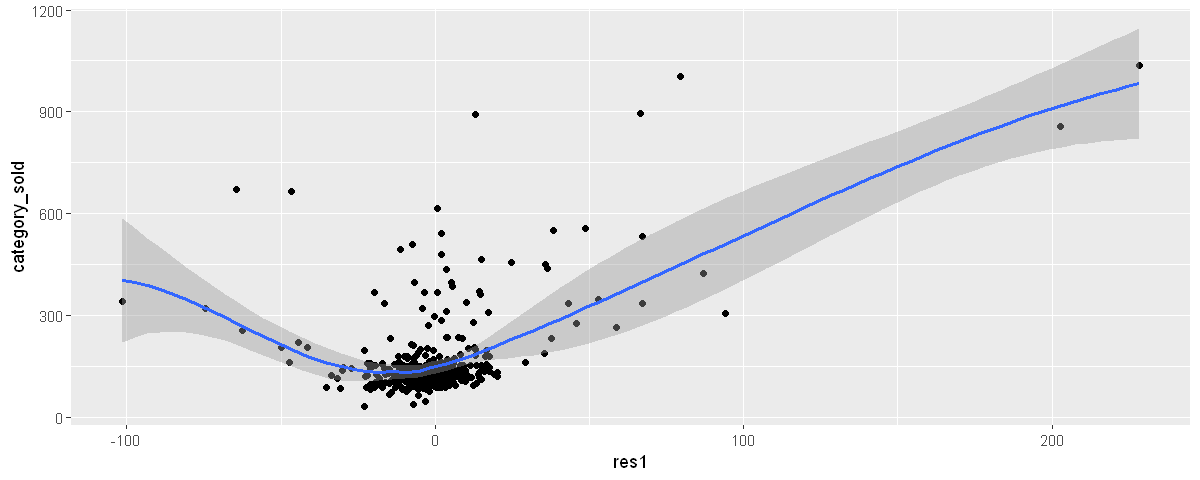

In [98]:
ggplot(fakir_train,aes(x=res1,y=category_sold)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


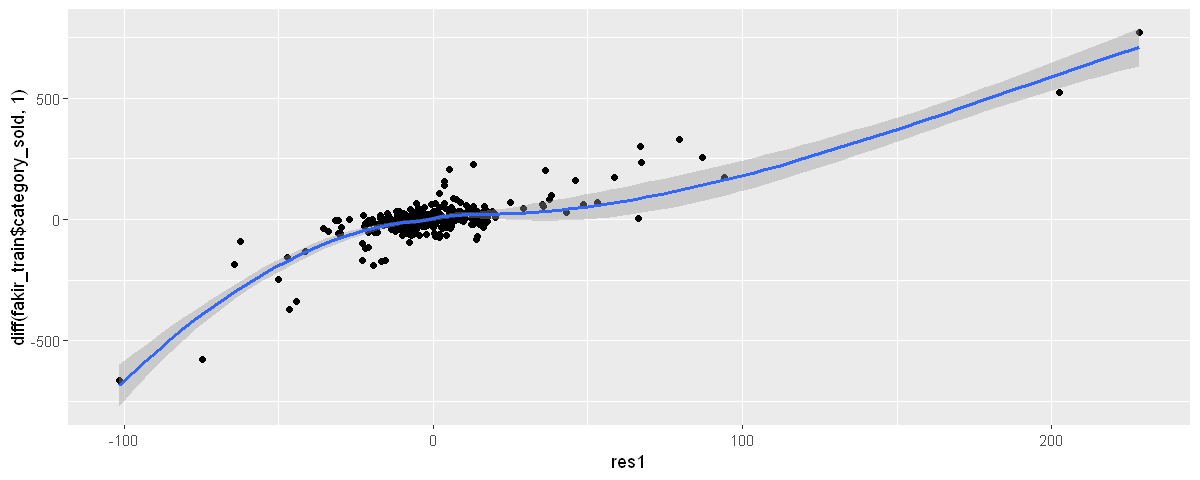

In [99]:
ggplot(fakir_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(fakir_train$category_sold,1))) +
geom_smooth(aes(y=diff(fakir_train$category_sold,1)))

In [100]:
cor(fakir_train[2:.N]$res1,diff(fakir_train$category_sold,1))
fakir_train$diff_sold <- c(NA,diff(fakir_train$category_sold,1))
fakir$diff_sold <- c(NA,diff(fakir$category_sold,1))

[1] 0.8116989

In [101]:
arima(fakir_ts,order=c(1,1,4),xreg=fakir_train$diff_sold)


Call:
arima(x = fakir_ts, order = c(1, 1, 4), xreg = fakir_train$diff_sold)

Coefficients:
         ar1      ma1      ma2      ma3      ma4  fakir_train$diff_sold
      0.5105  -0.4731  -0.0739  -0.1072  -0.2695                 0.1427
s.e.  0.0866   0.0867   0.0568   0.0555   0.0601                 0.0071

sigma^2 estimated as 328:  log likelihood = -1562.86,  aic = 3139.72

New regressor give better AIC value which is 3139.72 and better than the previous model.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)
Q* = 3.531, df = 4, p-value = 0.4732

Model df: 6.   Total lags used: 10



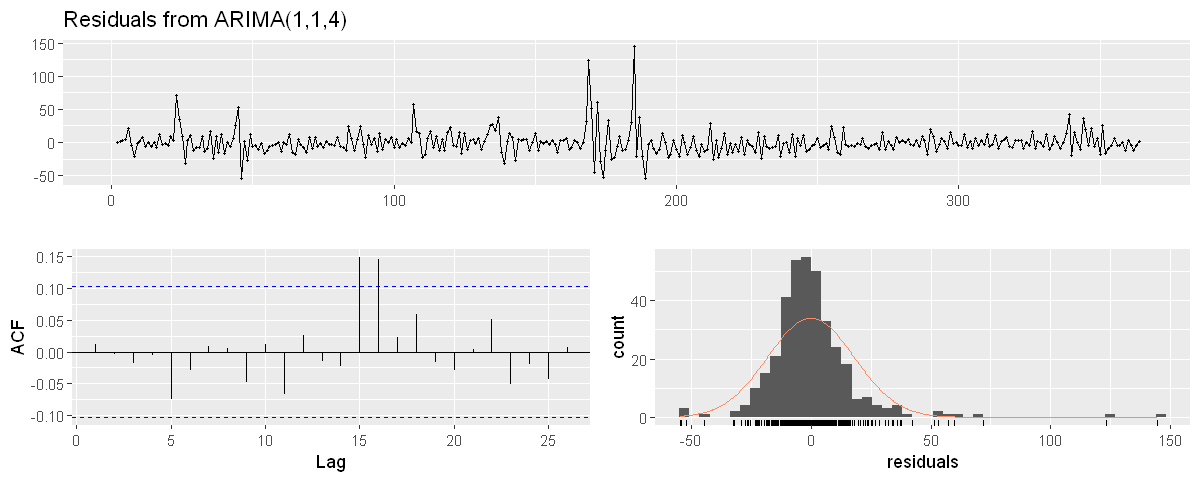

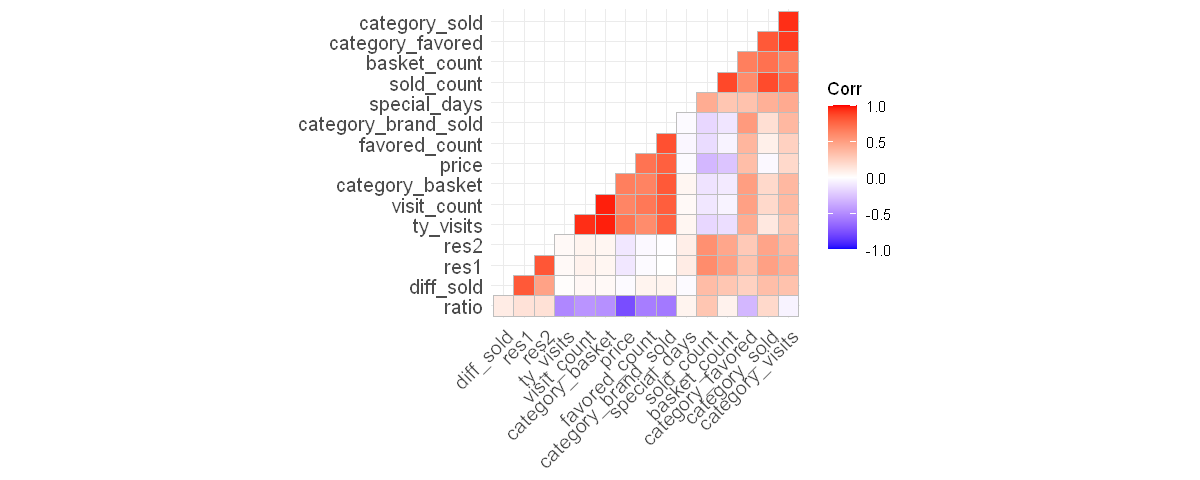

In [102]:
model_fakir_arimax <- arima(fakir_ts,order=c(1,1,4),xreg=fakir_train$diff_sold)
checkresiduals(model_fakir_arimax)
fakir_train$res2 <- model_fakir_arimax$residuals
corr <- cor(fakir_train[!is.na(fakir_train$price)& !is.na(fakir_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals are more stationary now. We should apply the new model to the test period.

In [103]:
forecast_data_fakir <- data.table(event_date=fakir[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=fakir[event_date>=test_start&event_date<=test_end,]$sold_count)
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- fakir[event_date<test_dates[i],]
  model_arima <- arima(train_dt$sold_count,order=c(1,1,4))
  model_arimax <- Arima(train_dt$sold_count,order=c(1,1,4),xreg=train_dt$diff_sold)
  newreg <- forecast(auto.arima(train_dt$diff_sold),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  
}
forecast_data_fakir <- forecast_data_fakir[,`:=`(arima_p=arima_fc,
                                     arimax_p=arimax_fc)]
accu(forecast_data_fakir$sold_count,forecast_data_fakir$arima_p)
accu(forecast_data_fakir$sold_count,forecast_data_fakir$arimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,12.625,5.501623,0.4357721,-0.3901986,0.6961818,7.737695,6.508355,0.5155132,0.5155132


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,12.625,5.501623,0.4357721,0.8431368,1.727254,38.01849,18.65543,1.477658,1.477658


ARIMAX model is somehow problematic on this product, so the final model is ARIMA model with a 0.515 WMAPE value.

## PROD5 |  Bluetooth Kulaklik, Xiaomi

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


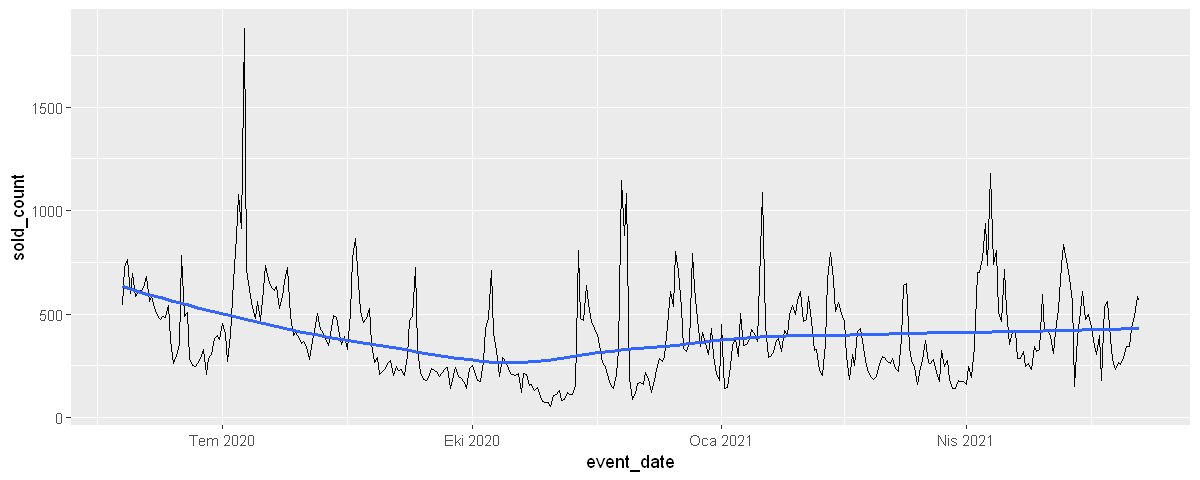

In [104]:
ggplot(prod5, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The mean changes over time. 
* The variance seems to be constant. 
* At the beginning of the July 2020, the highest sale value has been reached. 
* It appears that the data is not stationary due to the non-constant mean. 

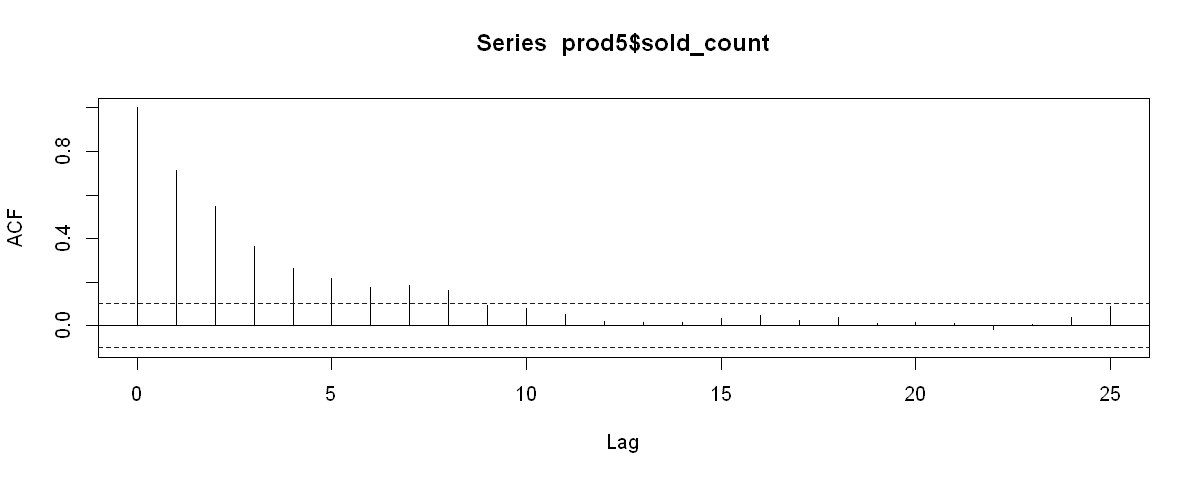

In [105]:
acf(prod5$sold_count)

From the ACF graph, there is a trend. Also, there is a little increase at lag 7, which may lead to weekly seasonality. 

### Weekly Decomposition

The variance stays same over time, so additive decomposition will be used again. 

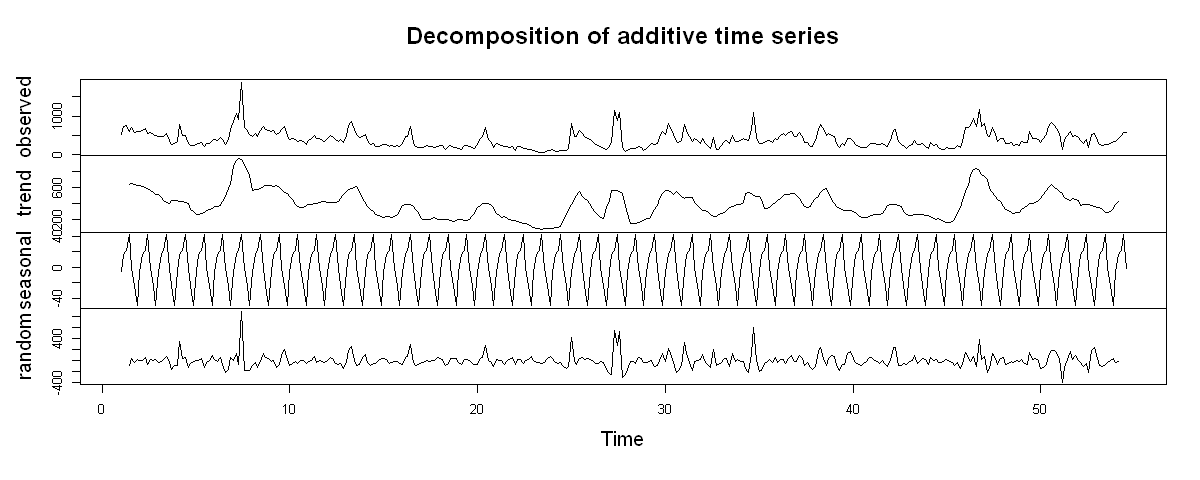

In [106]:
prod5_weekly_dec <- decompose(ts(prod5$sold_count, freq=7), type="additive")
plot(prod5_weekly_dec)

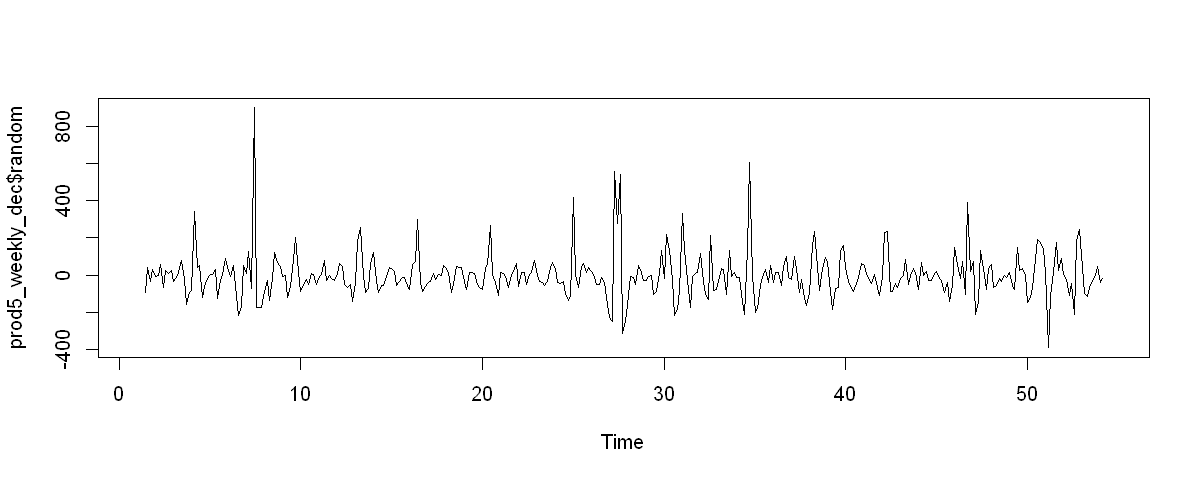

In [107]:
plot(prod5_weekly_dec$random)

* The variance slightly changes over time. 
* The mean seems is constant over time. 

In [108]:
u_test <- ur.kpss(prod5_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0079 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the test result above, we can say that the data is stationary. 

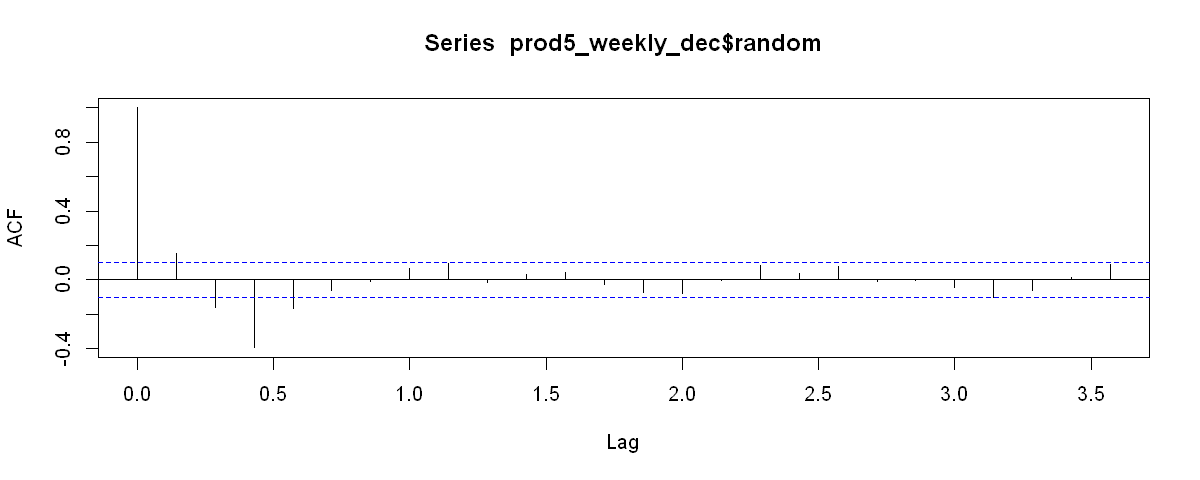

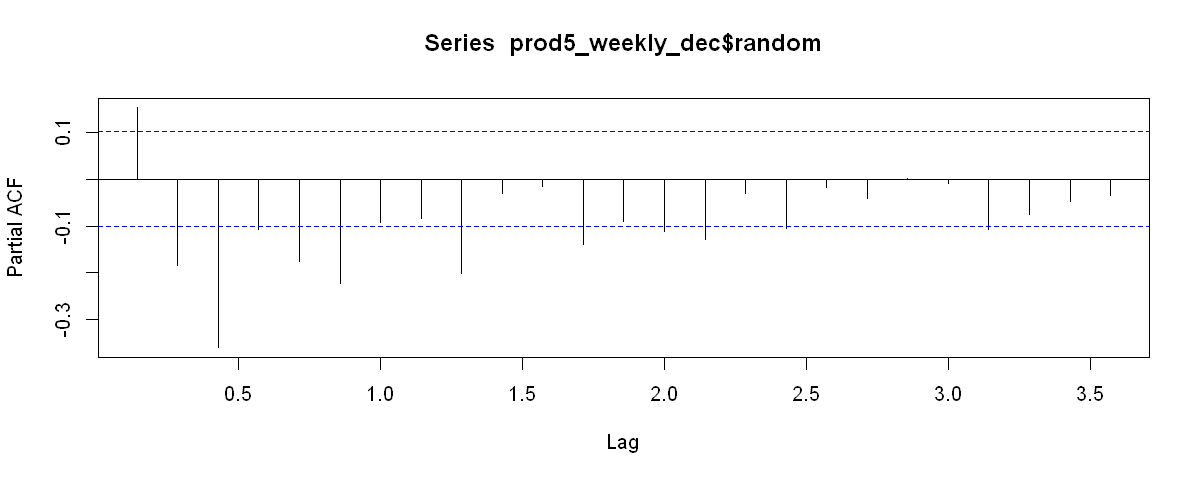

In [109]:
acf(prod5_weekly_dec$random, na.action=na.pass)
pacf(prod5_weekly_dec$random, na.action=na.pass)

From the ACF, the high correlation at lag 3 is seen. Also there is a sinus wave on the ACF graph. The high correlation at lag 3 also can be seen on the PACF graph. 

### Monthly Decomposition

month,sold_count
2020 May,4515
2020 Haz,12746
2020 Tem,19116
2020 Ağu,12981
2020 Eyl,7565
2020 Eki,6917
2020 Kas,10553
2020 Ara,11358
2021 Oca,12948
2021 Şub,10668


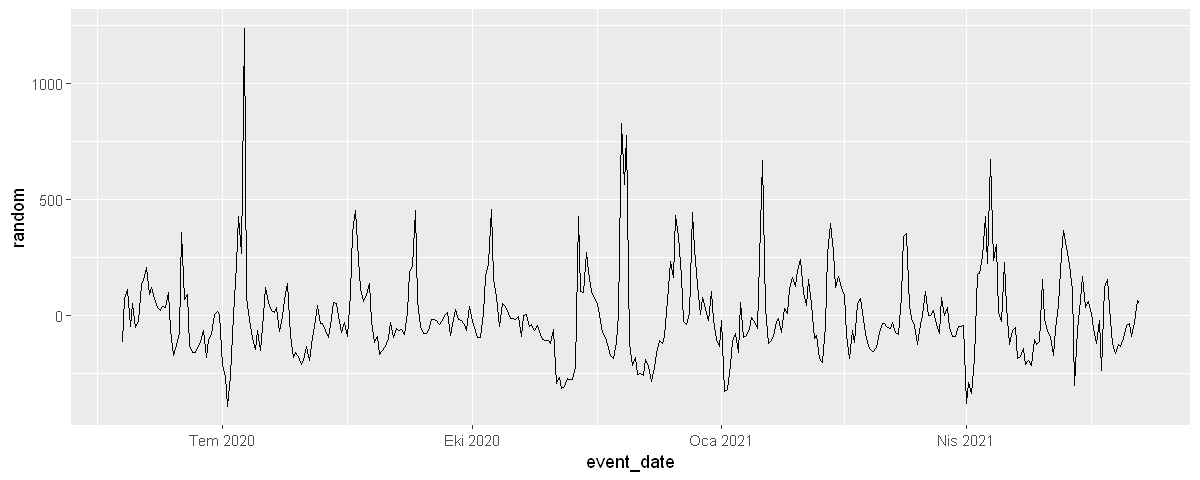

In [110]:
prod5_monthly <- prod5[, month:=yearmonth(event_date)]
prod5_monthly[, .(sold_count=sum(sold_count)), by=month]
prod5_monthly[, trend:=1:.N]

prod5_reg <- lm(sold_count~trend+as.factor(month), data=prod5_monthly)
prod5_monthly[, regOutput:=predict(prod5_reg, prod5_monthly)]

prod5_monthly[, random:=sold_count-regOutput]

ggplot(prod5_monthly, aes(x=event_date, y=random)) + geom_line()

* Although there are jumping and falling points, the variance seems to be constant. 
* It can be said that the mean is also constant. 

In [111]:
u_test <- ur.kpss(prod5_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0176 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


We cannot reject the null hyphothesis which means that the data is stationary. 

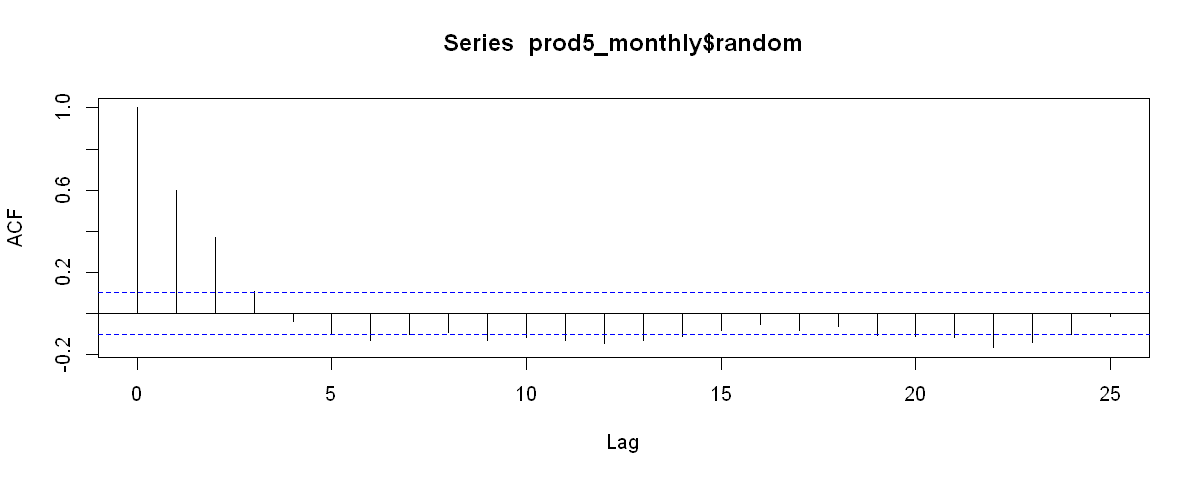

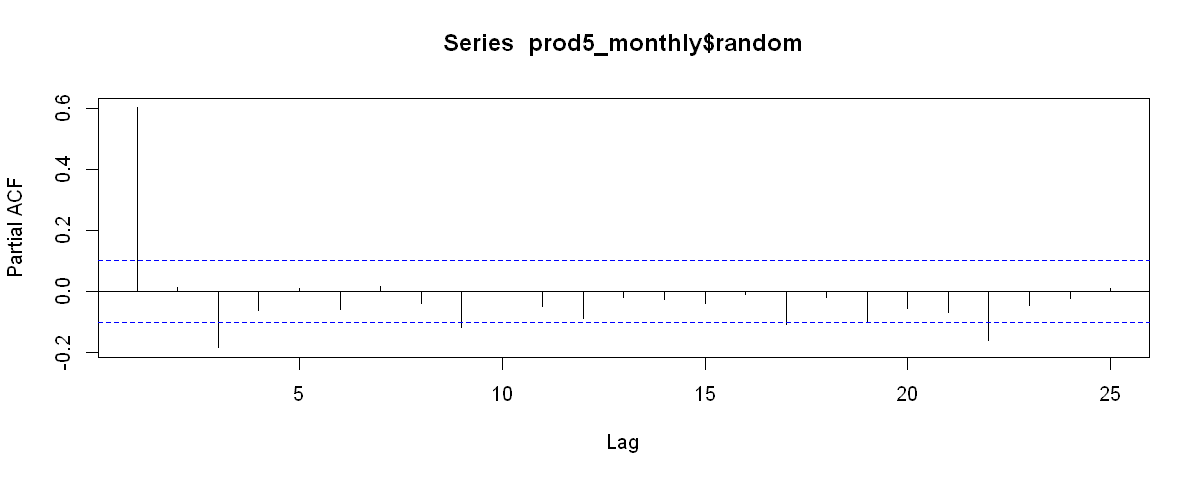

In [112]:
acf(prod5_monthly$random)
pacf(prod5_monthly$random)

At lag 1, there is correlation. Differencing may be required. 

### Building an ARIMA Model

In [113]:
xaomi <- data[product_content_id=="6676673",][order(event_date)]
xaomi_train <- xaomi[event_date<test_start,]
xaomi_ts <- ts(xaomi_train$sold_count,freq=7)

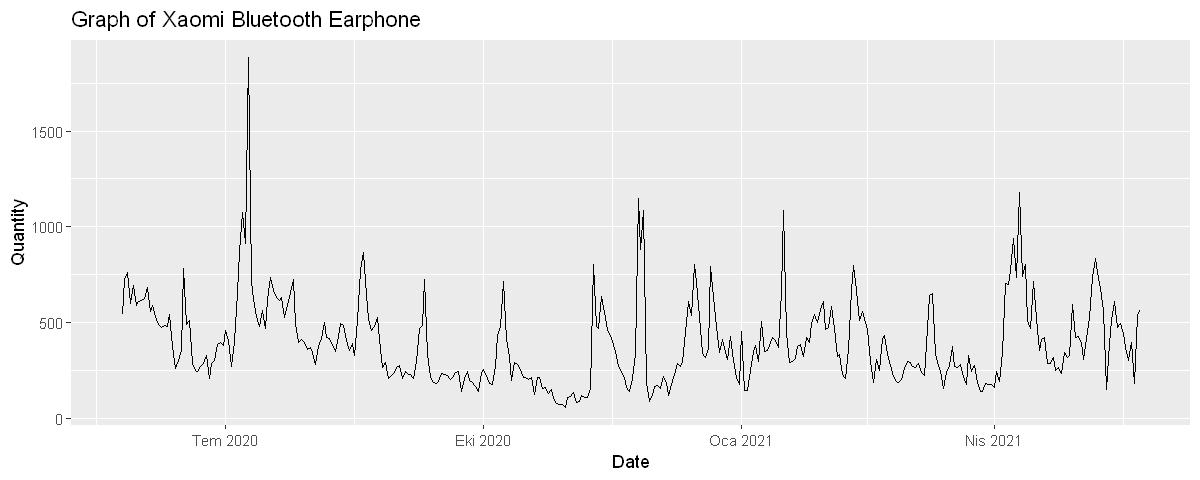

In [114]:
ggplot(xaomi_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Xaomi Bluetooth Earphone", x= "Date", y="Quantity")

Xaomi sold_count series is not stationary due to the non constant mean and variance.

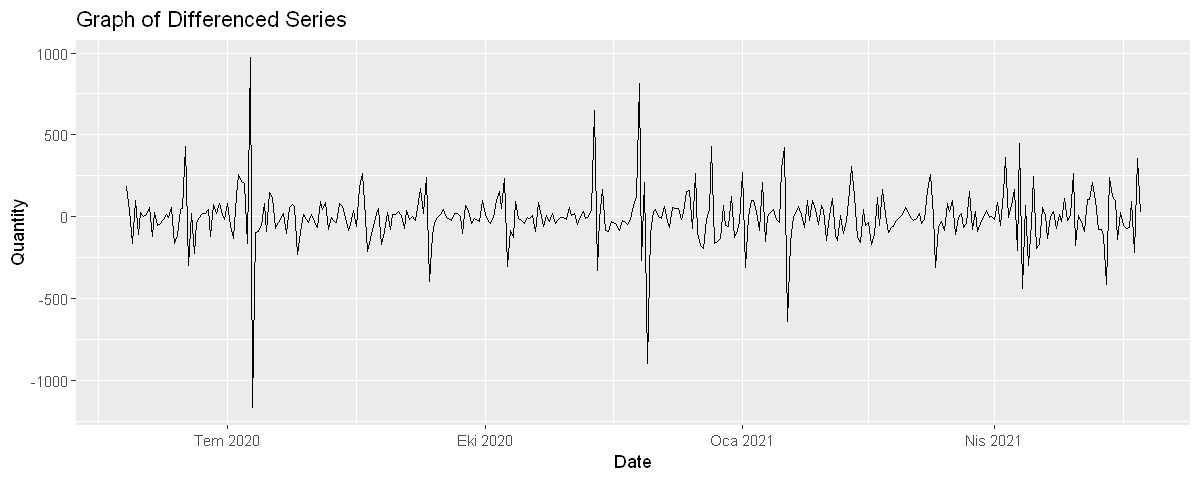

In [115]:
ggplot(xaomi_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(xaomi_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

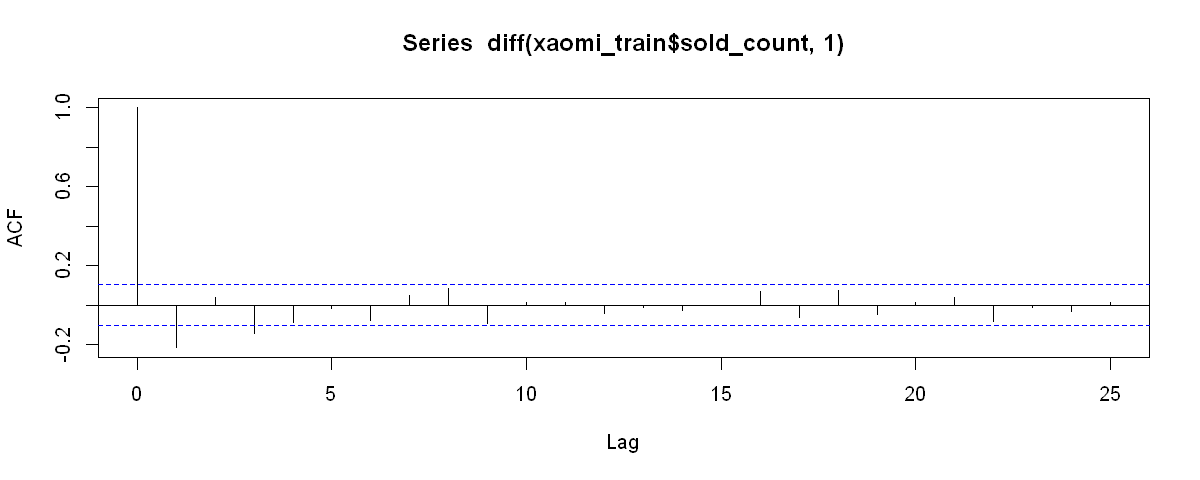

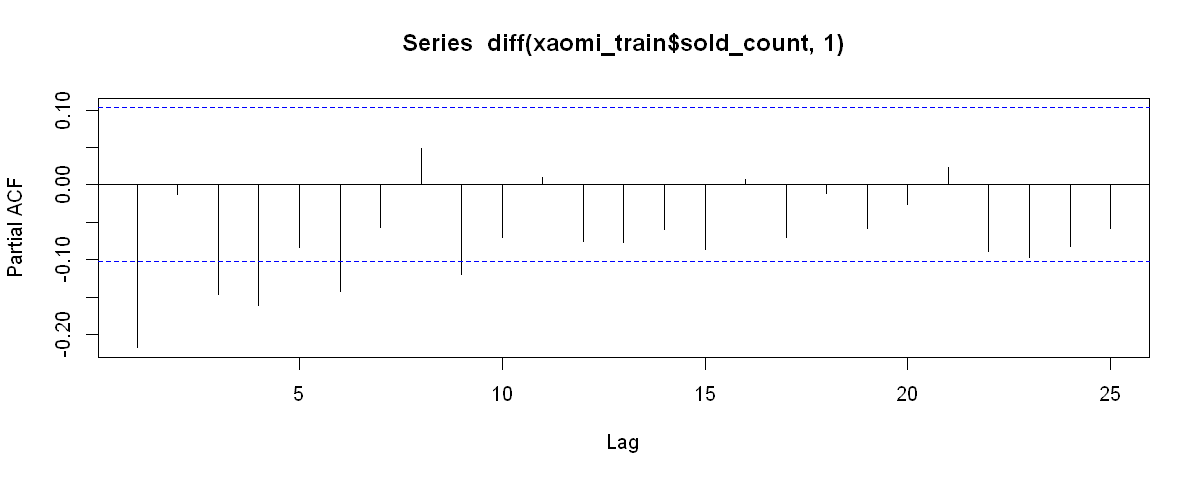

In [116]:
acf(diff(xaomi_train$sold_count,1))
pacf(diff(xaomi_train$sold_count,1))

At the decomposition step, it was said that the data has weekly seasonality. We could build a SARIMA model. ACF graphs has spikes at lag 1 and 3. Also, PACF graph has spikes at lag 1,3,4 and 9. We could try these parameters on a SARIMA model.

In [117]:
arima(xaomi_ts,order=c(1,1,1),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(1, 1, 1), seasonal = c(2, 0, 0))

Coefficients:
         ar1      ma1    sar1     sar2
      0.6791  -0.9756  0.0628  -0.0374
s.e.  0.0455   0.0165  0.0538   0.0541

sigma^2 estimated as 23631:  log likelihood = -2343.58,  aic = 4697.16

In [118]:
arima(xaomi_ts,order=c(3,1,1),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(3, 1, 1), seasonal = c(2, 0, 0))

Coefficients:
         ar1     ar2      ar3      ma1    sar1     sar2
      0.6345  0.1568  -0.1385  -0.9711  0.0810  -0.0486
s.e.  0.0542  0.0618   0.0541   0.0181  0.0543   0.0544

sigma^2 estimated as 23082:  log likelihood = -2339.32,  aic = 4692.65

In [119]:
arima(xaomi_ts,order=c(3,1,3),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(3, 1, 3), seasonal = c(2, 0, 0))

Coefficients:
          ar1      ar2     ar3      ma1      ma2      ma3    sar1     sar2
      -0.2324  -0.0459  0.4625  -0.0987  -0.0934  -0.7479  0.0774  -0.0406
s.e.   0.1809   0.1374  0.1127   0.1664   0.1510   0.1143  0.0603   0.0569

sigma^2 estimated as 22826:  log likelihood = -2337.37,  aic = 4692.73

In [120]:
arima(xaomi_ts,order=c(1,1,3),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(1, 1, 3), seasonal = c(2, 0, 0))

Coefficients:
         ar1      ma1     ma2      ma3    sar1     sar2
      0.5684  -0.9017  0.1300  -0.1931  0.0776  -0.0456
s.e.  0.1003   0.1082  0.0764   0.0684  0.0542   0.0541

sigma^2 estimated as 23074:  log likelihood = -2339.26,  aic = 4692.53

In [121]:
auto.arima(xaomi_ts)

Series: xaomi_ts 
ARIMA(3,0,0)(0,0,1)[7] with non-zero mean 

Coefficients:
         ar1     ar2      ar3    sma1      mean
      0.6558  0.1646  -0.1228  0.0979  396.5000
s.e.  0.0520  0.0621   0.0533  0.0554   28.6426

sigma^2 estimated as 23302:  log likelihood=-2344.63
AIC=4701.26   AICc=4701.5   BIC=4724.65

The best model is SARIMA(1,1,3)(2,0,0) with the AIC value of 4692.53


	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)(2,0,0)[7]
Q* = 7.9986, df = 8, p-value = 0.4336

Model df: 6.   Total lags used: 14



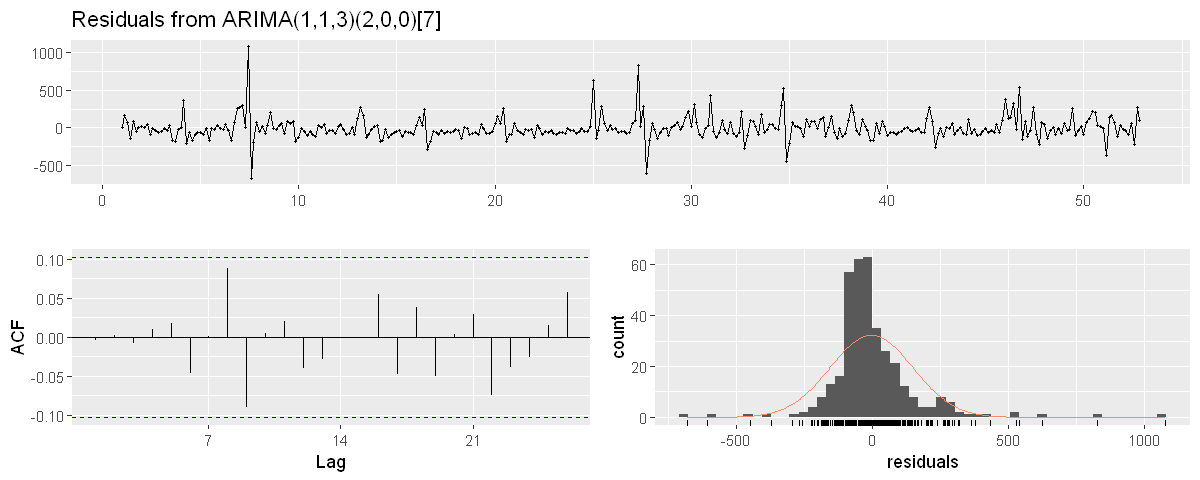

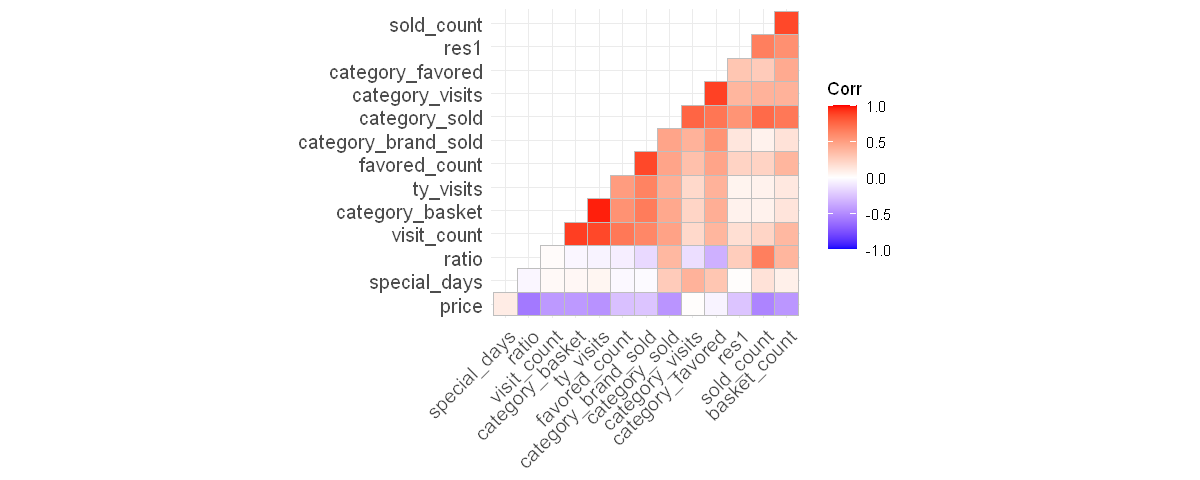

In [122]:
model_xaomi_sarima <- arima(xaomi_ts,order=c(1,1,3),seasonal=c(2,0,0))
checkresiduals(model_xaomi_sarima)
xaomi_train$res1 <- model_xaomi_sarima$residuals
corr <- cor(xaomi_train[!is.na(xaomi_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")


Residuals have a constant mean at 0. They are not correlated and they have nearly constant variance. Although the distribution seems normal, histogram is right skewed. Residuals are correlated with category_sold.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


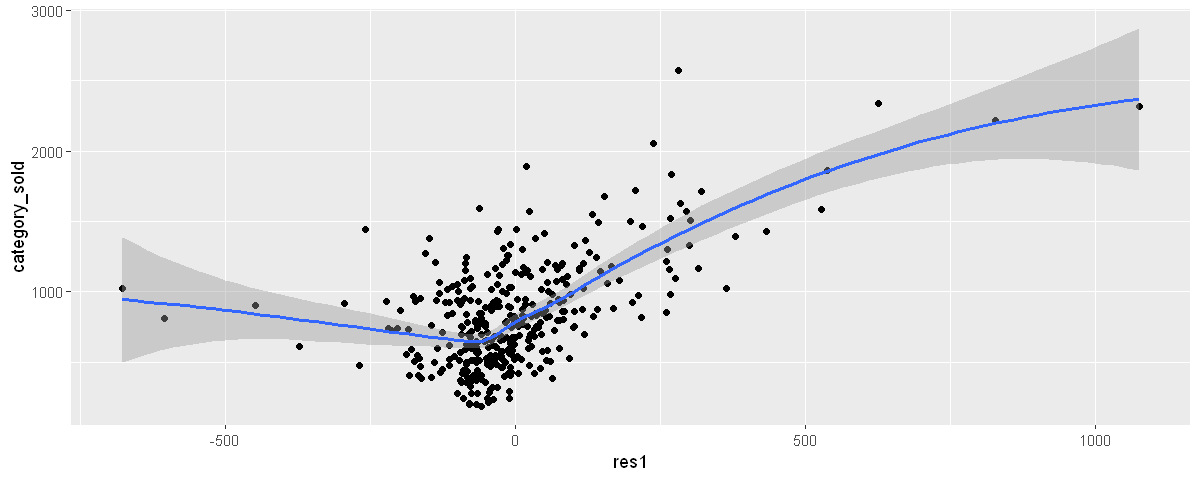

In [123]:
ggplot(xaomi_train,aes(x=res1,y=category_sold)) +  geom_point() + geom_smooth()

In [124]:
cor(xaomi_train$res1,xaomi_train$category_sold)

[1] 0.5549883

The correlation seems to be linear with 0.544, there is no need to transform the data. We could add it as a regressor.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)(2,0,0)[7]
Q* = 9.8668, df = 7, p-value = 0.1963

Model df: 7.   Total lags used: 14



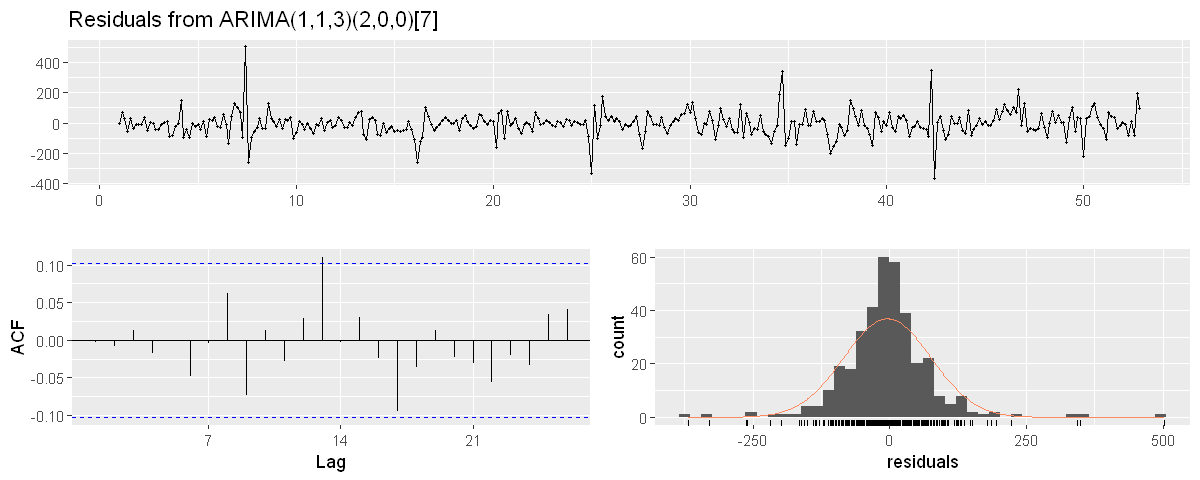

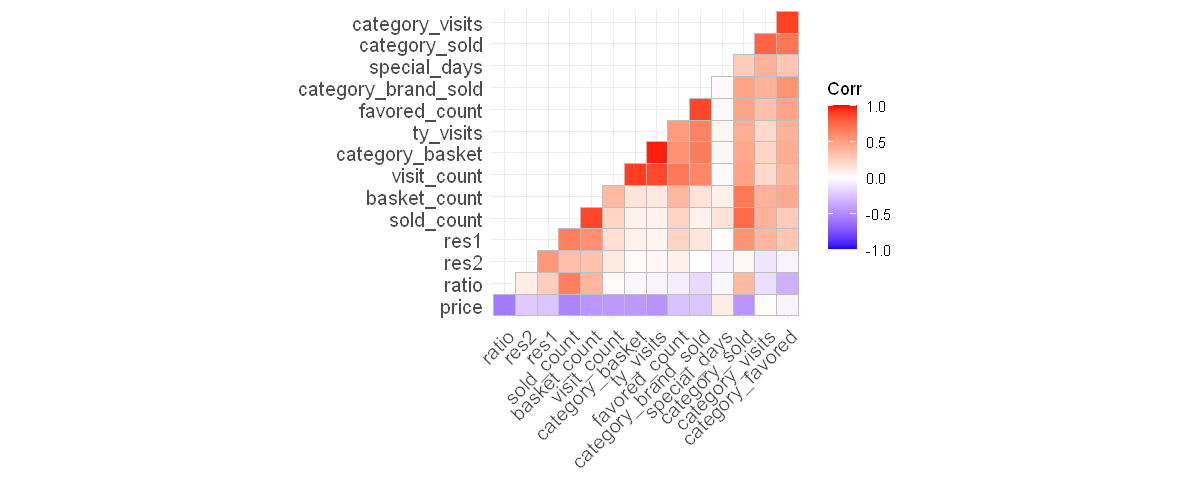

In [125]:
model_xaomi_sarimax <- arima(xaomi_ts,order=c(1,1,3),seasonal=c(2,0,0),xreg=xaomi_train$category_sold)
checkresiduals(model_xaomi_sarimax)
xaomi_train$res2 <- model_xaomi_sarimax$residuals
corr <- cor(xaomi_train[!is.na(xaomi_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals seems more stationart and also right skew of the histogram is gone. We could use this SARIMAX model in the forecasting.

In [126]:
forecast_data_xaomi <- data.table(event_date=xaomi[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=xaomi[event_date>=test_start&event_date<=test_end,]$sold_count)
sarima_fc <- numeric(0)
sarimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- xaomi[event_date<test_dates[i],]
  model_sarima <- Arima(train_dt$sold_count,order=c(1,1,3),seasonal=c(2,0,0))
  model_sarimax <- Arima(train_dt$sold_count,order=c(1,1,3),seasonal=c(2,0,0),xreg=train_dt$category_sold)
  newreg <- forecast(auto.arima(train_dt$category_sold),h=1)$mean[1]
  sarima_temp <- forecast(model_sarima)
  sarimax_temp <- forecast(model_sarimax,xreg=newreg)
  sarima_fc <- c(sarima_fc,sarima_temp$mean[1])
  sarimax_fc <- c(sarimax_fc,sarimax_temp$mean[1])
  
}
forecast_data_xaomi <- forecast_data_xaomi[,`:=`(sarima_p=sarima_fc,
                                                 sarimax_p=sarimax_fc)]
accu(forecast_data_xaomi$sold_count,forecast_data_xaomi$sarima_p)
accu(forecast_data_xaomi$sold_count,forecast_data_xaomi$sarimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,299.5,51.70797,0.1726477,-0.2007072,0.214099,86.30398,64.68239,0.2159679,0.2159679


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,299.5,51.70797,0.1726477,-0.2749762,0.2744649,95.3262,82.35537,0.2749762,0.2749762


Again, ARIMA model has better WMAPE value and is selected for the forecasting step.

## PROD4 | Tayt, TRENDYOLMILLA

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


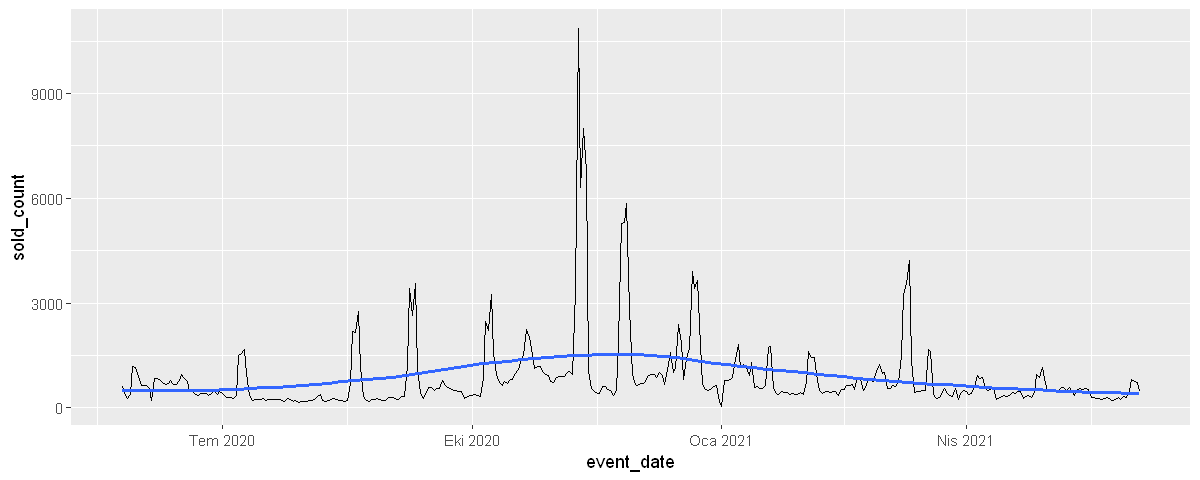

In [127]:
ggplot(prod4, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The blue line says that the mean is not constant. 
* It seems that there is no trend on the data. 
* The variance changes over time. 

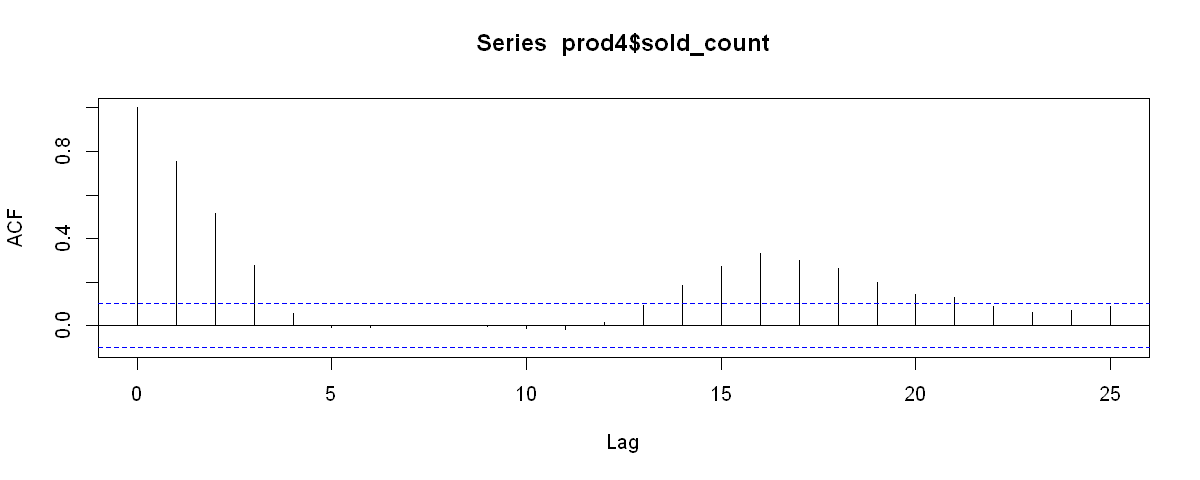

In [128]:
acf(prod4$sold_count) 

There is a little increase in the autocorrelation value at lag 16. 

### Weekly Decomposition

The variance does not increase over time, so additive decomposition will be used to decompose the data at weekly level. 

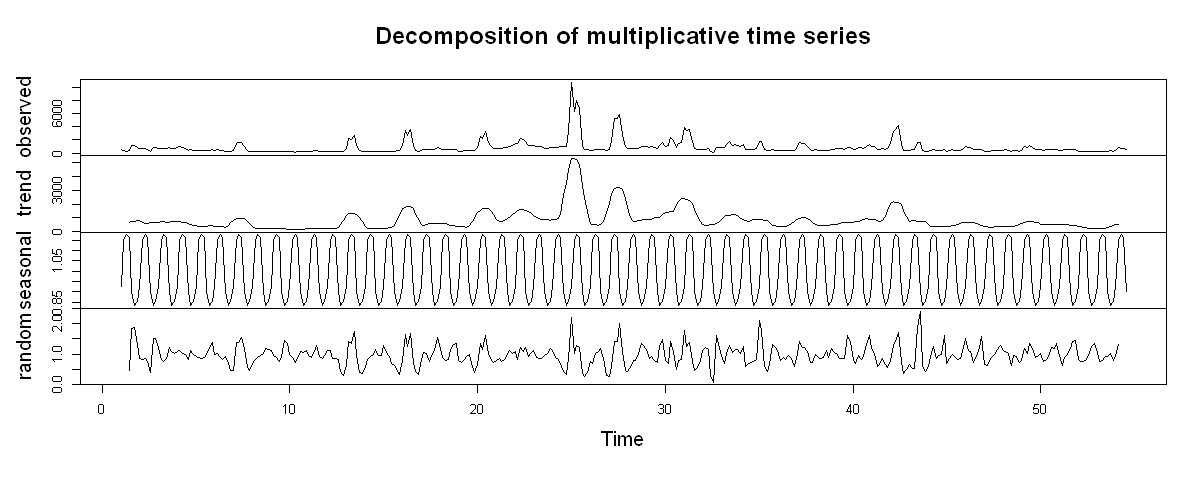

In [129]:
prod4_weekly_dec <- decompose(ts(prod4$sold_count, freq=7), type="multiplicative")
plot(prod4_weekly_dec)

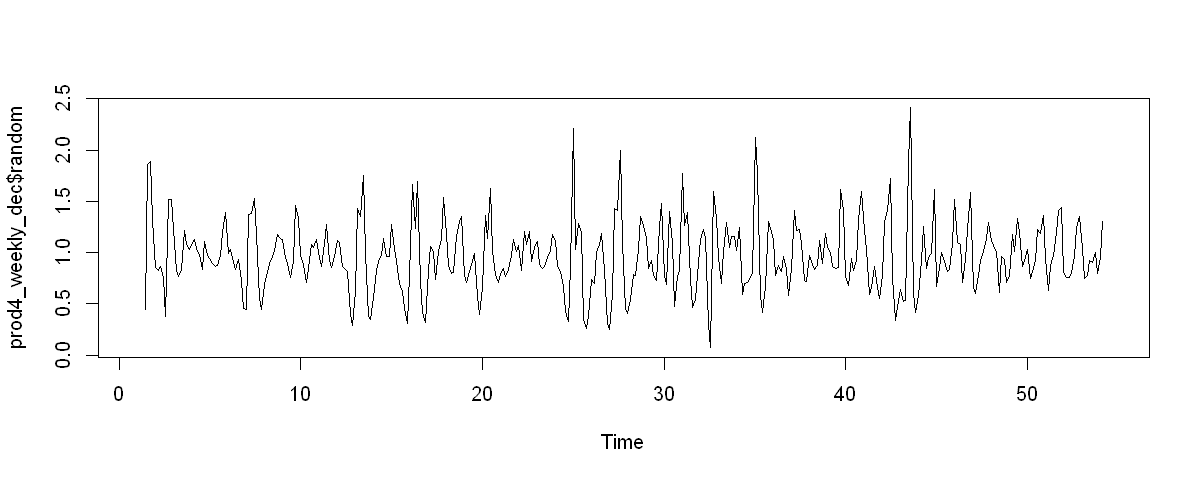

In [130]:
plot(prod4_weekly_dec$random)

* The variance seems to be constant. 
* The mean is also constant. 
* It can be said that the data is stationary. 

In [131]:
u_test <- ur.kpss(prod4_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1024 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The weekly decomposed data is stationary. 

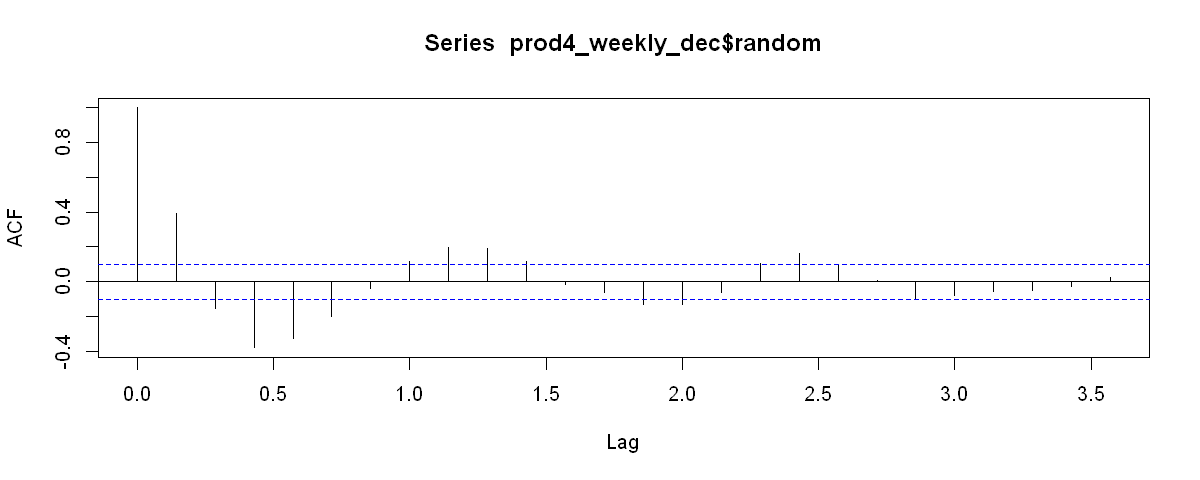

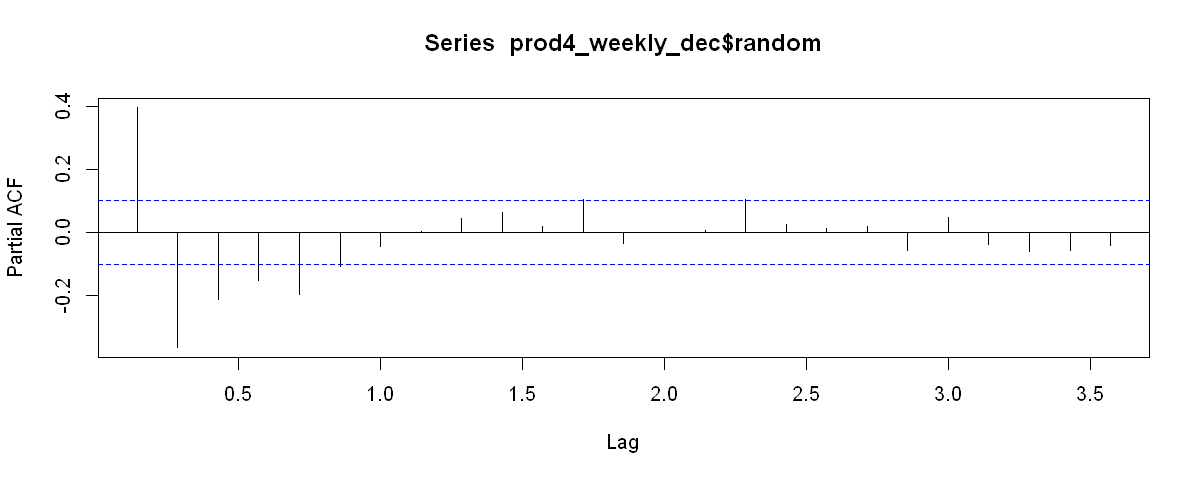

In [132]:
acf(prod4_weekly_dec$random, na.action=na.pass)
pacf(prod4_weekly_dec$random, na.action=na.pass)

ACF graph is like sinus shaped. First two lag have high correlation values. 

### Monthly Decomposition

month,sold_count
2020 May,4928
2020 Haz,17698
2020 Tem,12295
2020 Ağu,14991
2020 Eyl,22929
2020 Eki,35979
2020 Kas,70576
2020 Ara,38455
2021 Oca,23647
2021 Şub,20564


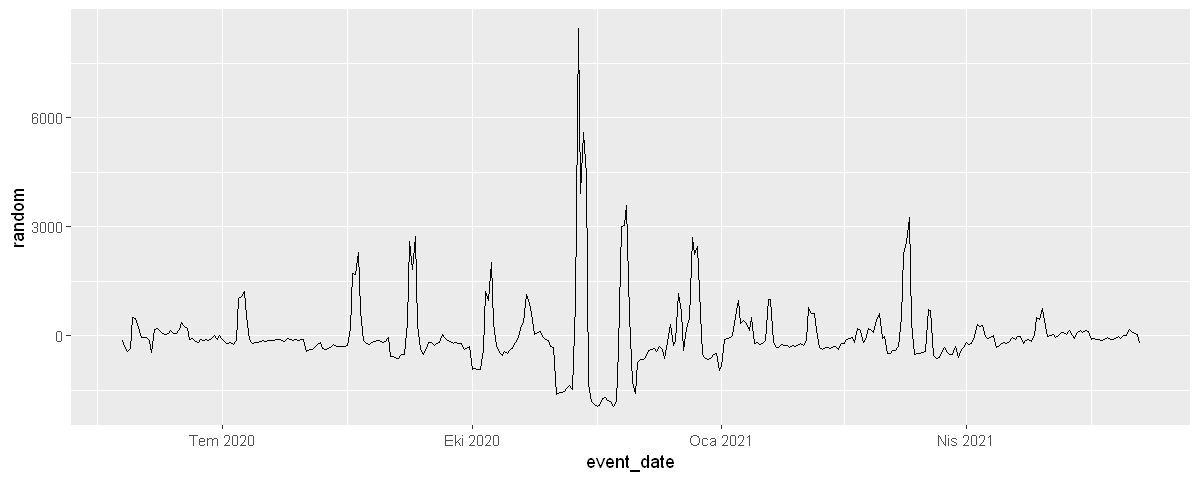

In [133]:
prod4_monthly <- prod4[, month:=yearmonth(event_date)]
prod4_monthly[, .(sold_count=sum(sold_count)), by=month]
prod4_monthly[, trend:=1:.N]

prod4_reg <- lm(sold_count~trend+as.factor(month), data=prod4_monthly)
prod4_monthly[, regOutput:=predict(prod4_reg, prod4_monthly)]

prod4_monthly[, random:=sold_count-regOutput]

ggplot(prod4_monthly, aes(x=event_date, y=random)) + geom_line()

* The variance is not constant. 
* The mean is constant. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [134]:
u_test <- ur.kpss(prod4_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0085 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the test above, the data is stationary. 

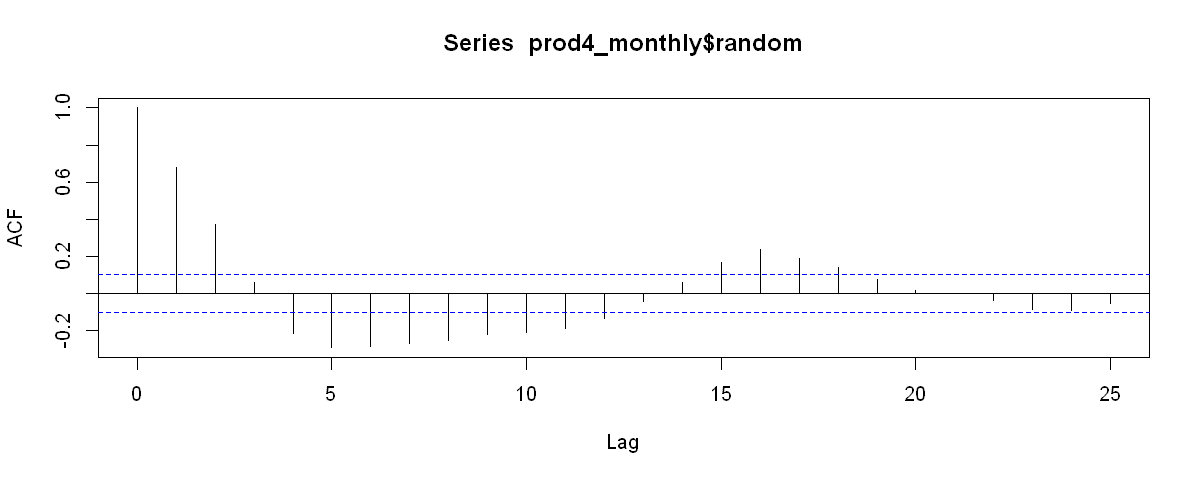

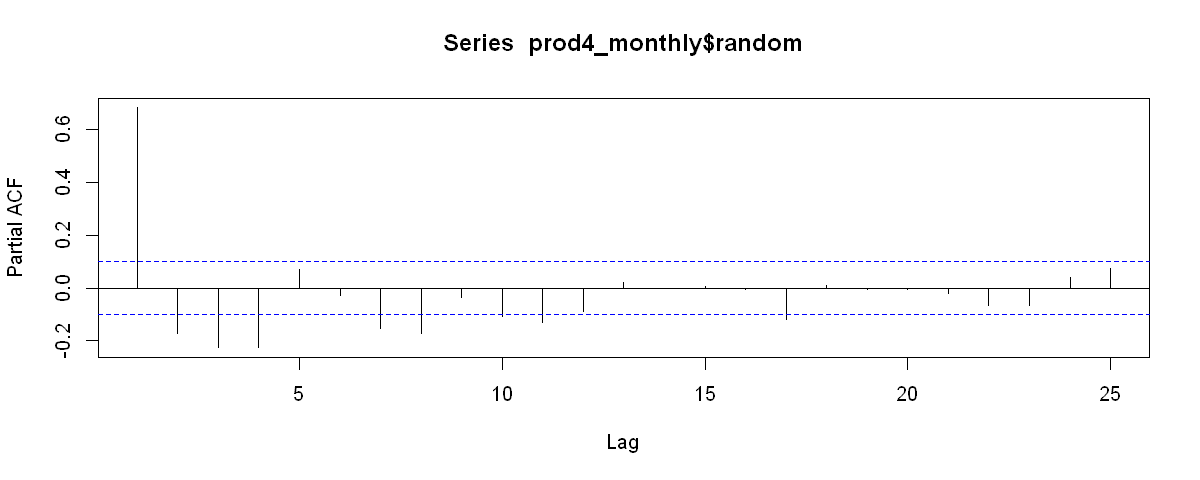

In [135]:
acf(prod4_monthly$random, na.action=na.pass)
pacf(prod4_monthly$random, na.action=na.pass)

The data is highly correlated with its first lag. Also, the ACF graph is like sinus wave. 

### Building an ARIMA Model

In [136]:
tayt <- data[product_content_id=="31515569",][order(event_date)]
tayt_train <- tayt[event_date<test_start,]
tayt_ts <- ts(tayt_train$sold_count)

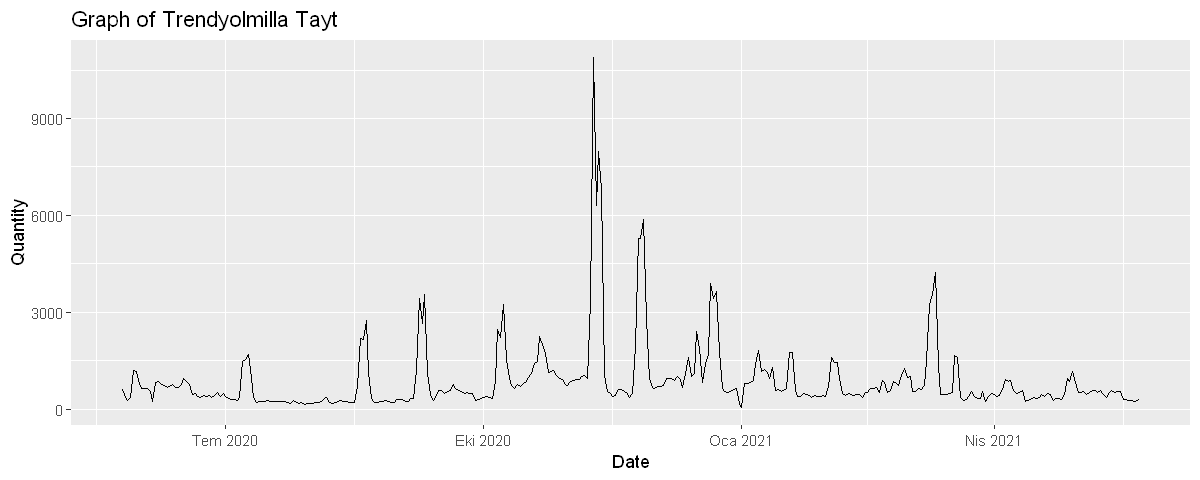

In [137]:
ggplot(tayt_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Trendyolmilla Tayt", x= "Date", y="Quantity")

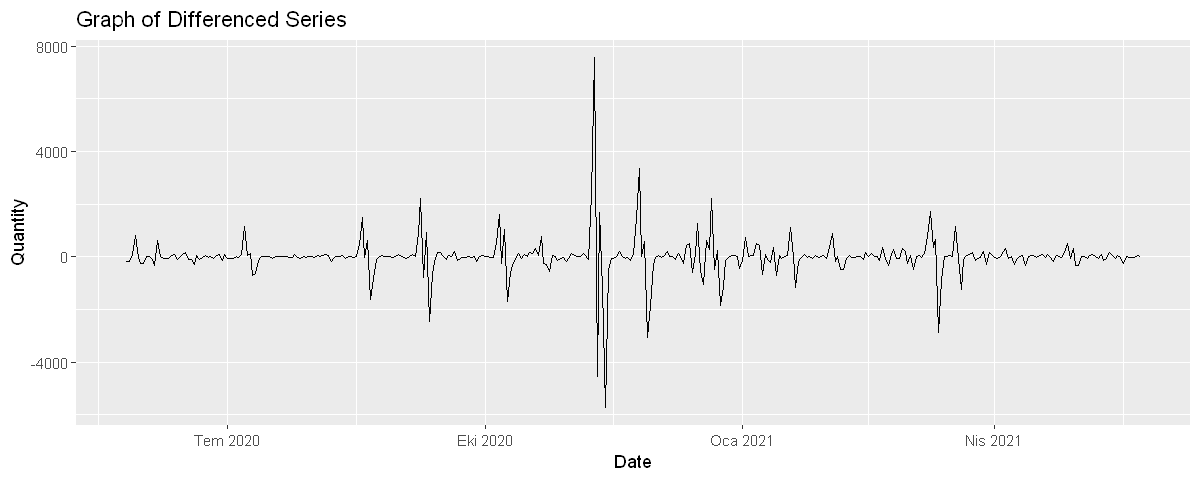

In [138]:
ggplot(tayt_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(tayt_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

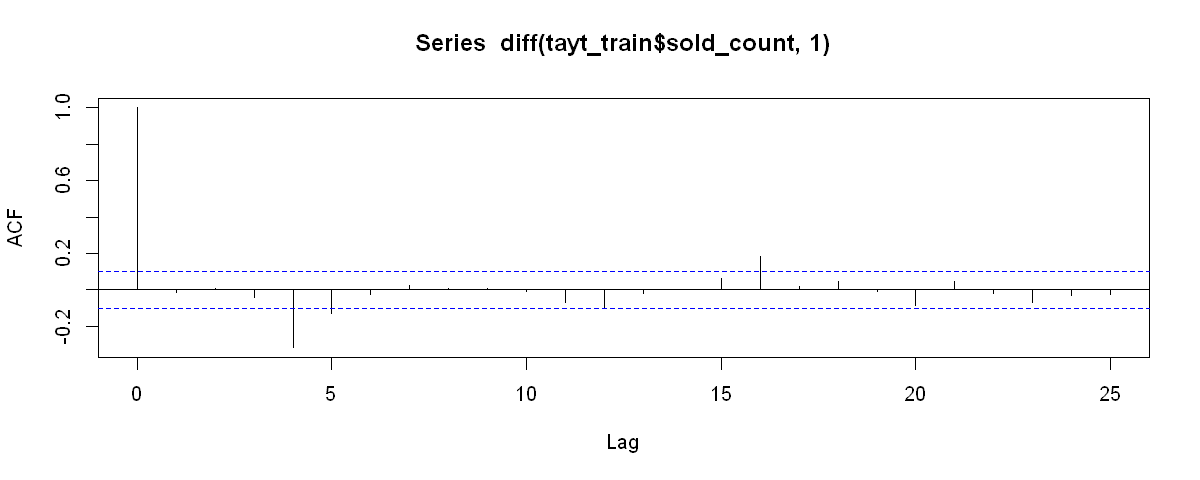

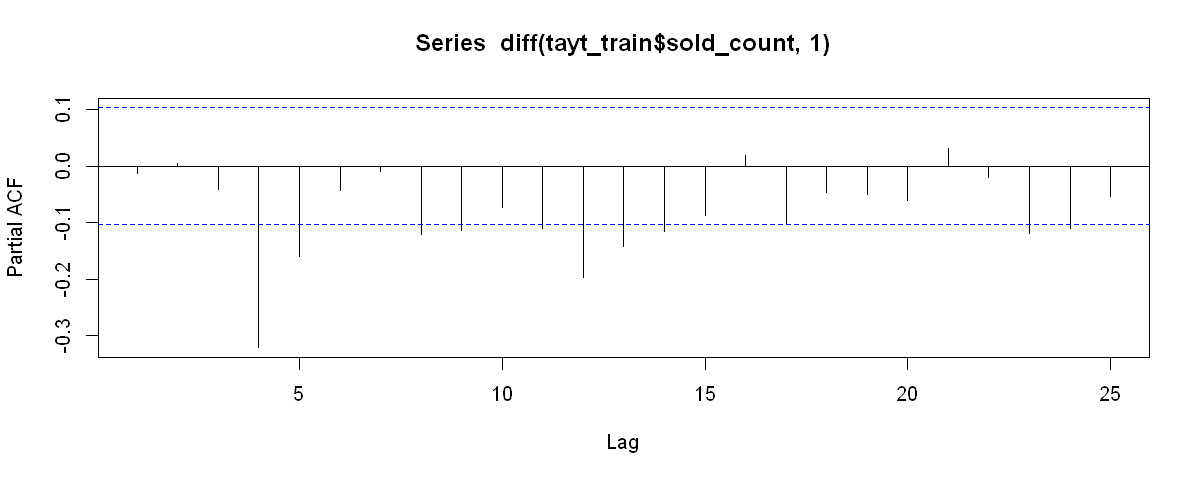

In [139]:
acf(diff(tayt_train$sold_count,1))
pacf(diff(tayt_train$sold_count,1))

After the differencing, there is spikes at ACF graph at lag 4 and at PACF graph lag 4. An ARIMA(4,1,4) model could be constructed.

In [140]:
arima(tayt_ts,order=c(4,1,4))


Call:
arima(x = tayt_ts, order = c(4, 1, 4))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3      ma4
      0.4578  -0.1599  0.0712  -0.1201  -0.6404  0.1549  -0.2001  -0.2455
s.e.  0.2722   0.3357  0.3095   0.1598   0.2736  0.3845   0.3551   0.2379

sigma^2 estimated as 471892:  log likelihood = -2887.28,  aic = 5792.55

In [141]:
auto.arima(tayt_ts)

Series: tayt_ts 
ARIMA(0,0,4) with non-zero mean 

Coefficients:
         ma1     ma2     ma3     ma4      mean
      0.8156  0.7182  0.5777  0.1509  870.6418
s.e.  0.0512  0.0586  0.0580  0.0523  117.1409

sigma^2 estimated as 479525:  log likelihood=-2895.28
AIC=5802.57   AICc=5802.8   BIC=5825.95

The best model is ARIMA(4,1,4) with lowest AIC 5792.55.


	Ljung-Box test

data:  Residuals from ARIMA(4,1,4)
Q* = 3.1848, df = 3, p-value = 0.364

Model df: 8.   Total lags used: 11



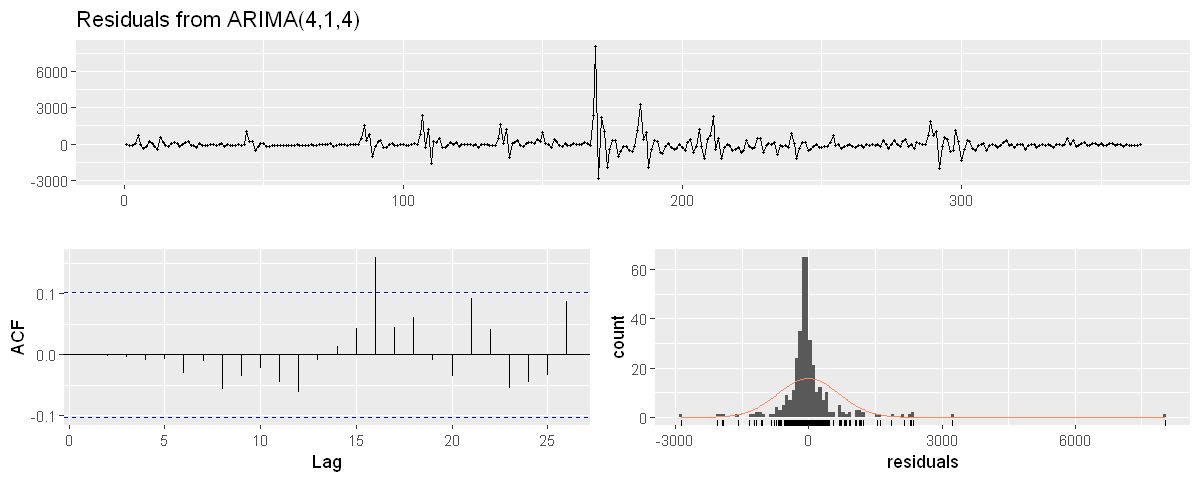

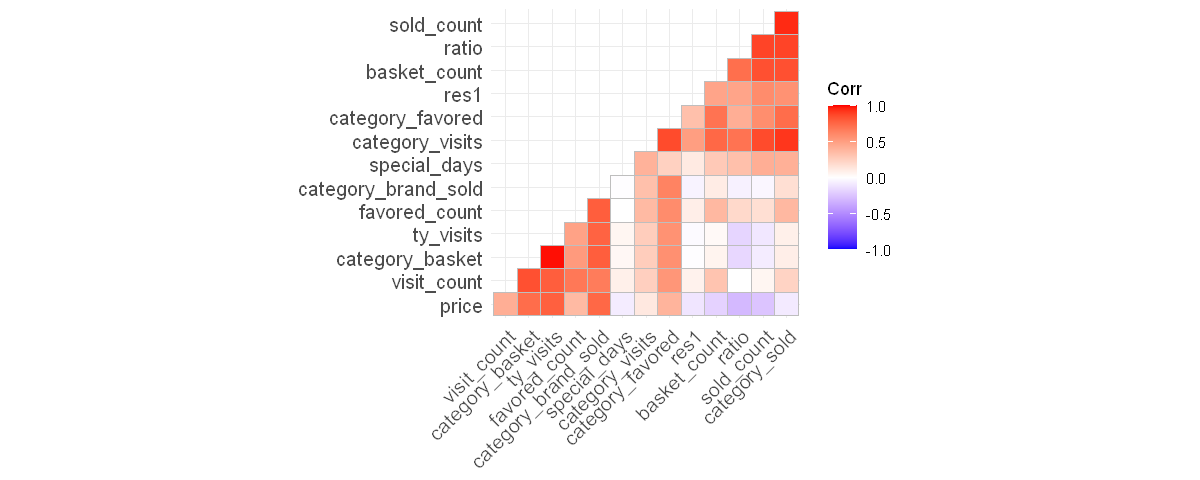

In [142]:
model_tayt_arima <- arima(tayt_ts,order=c(4,1,4))
checkresiduals(model_tayt_arima)
tayt_train$res1 <- model_tayt_arima$residuals
corr <- cor(tayt_train[!is.na(tayt_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have constant mean at 0 and constant variance. Also, distribution seems normal while there is no autocorrelation. Residuals are correlated with basket_count and  category_sold. First we could add the basket_count variable.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


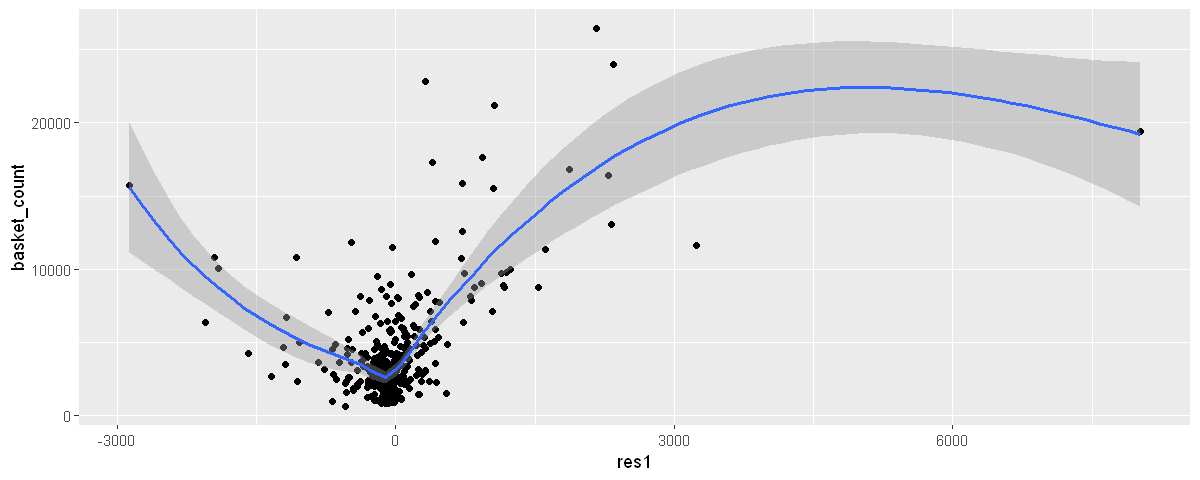

In [143]:
ggplot(tayt_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


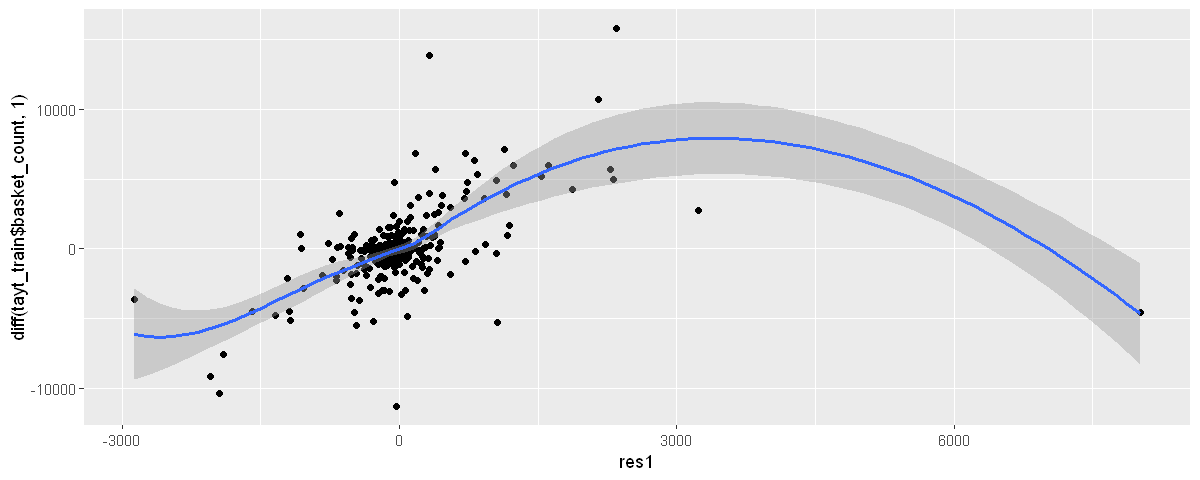

In [144]:
ggplot(tayt_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(tayt_train$basket_count,1))) + 
geom_smooth(aes(y=diff(tayt_train$basket_count,1)))

A more linear curve obtained with differencing.

In [145]:
cor(tayt_train[2:.N]$res1,diff(tayt_train$basket_count,1))
tayt_train$diff_basket <- c(NA,diff(tayt_train$basket_count,1))
tayt$diff_basket <- c(NA,diff(tayt$basket_count,1))

[1] 0.4433941

In [146]:
arima(tayt_ts,order=c(4,1,4),xreg=tayt_train$diff_basket)


Call:
arima(x = tayt_ts, order = c(4, 1, 4), xreg = tayt_train$diff_basket)

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3      ma4
      0.4504  -0.1341  0.0619  -0.1215  -0.6308  0.1225  -0.1774  -0.2457
s.e.  0.2466   0.3079  0.2870   0.1532   0.2473  0.3498   0.3259   0.2183
      tayt_train$diff_basket
                      0.0253
s.e.                  0.0110

sigma^2 estimated as 466190:  log likelihood = -2877.11,  aic = 5774.23


	Ljung-Box test

data:  Residuals from ARIMA(4,1,4)
Q* = 4.4918, df = 3, p-value = 0.213

Model df: 9.   Total lags used: 12



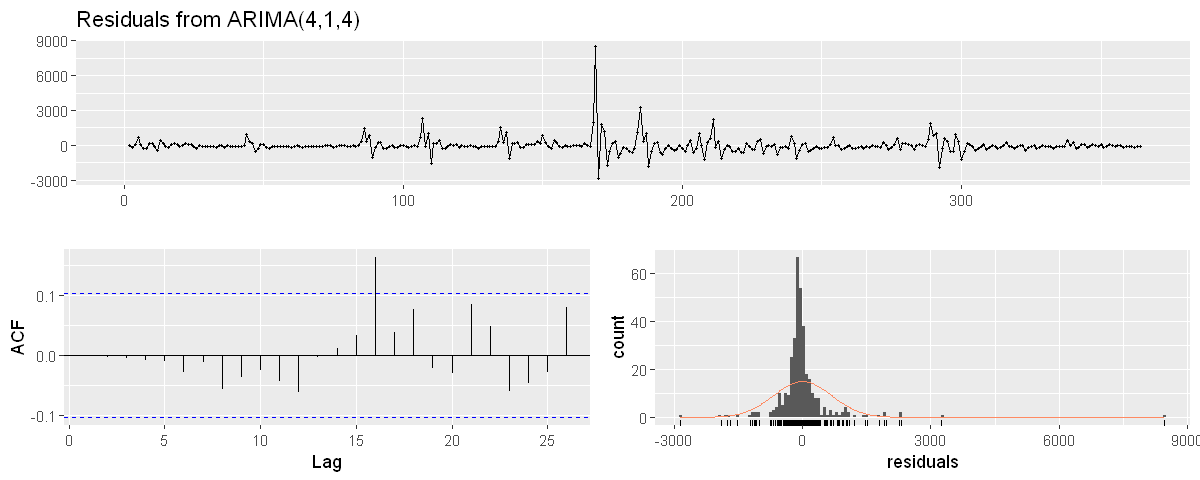

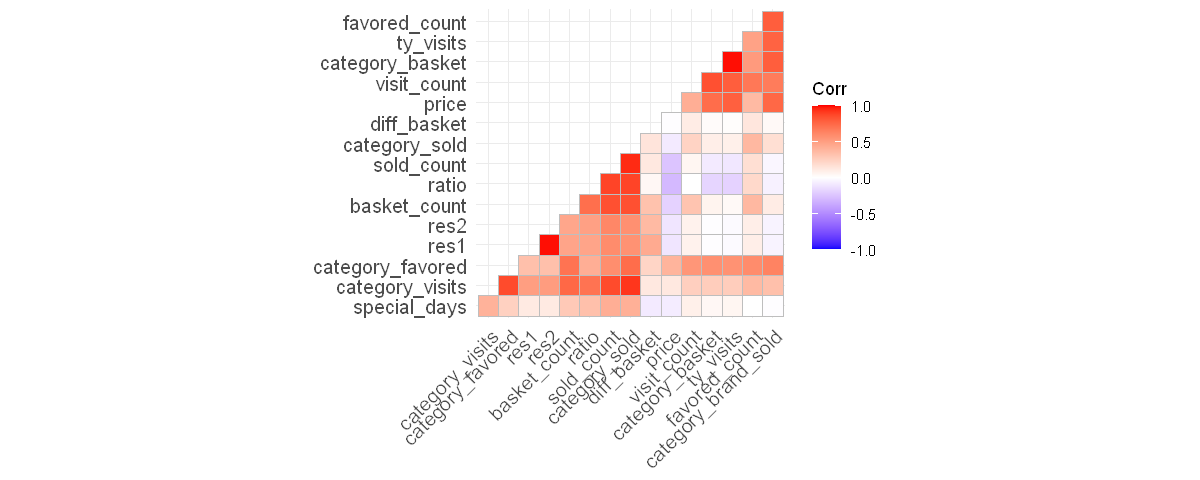

In [147]:
model_tayt_arimax <- arima(tayt_ts,order=c(4,1,4),xreg=tayt_train$diff_basket)
checkresiduals(model_tayt_arimax)
tayt_train$res2 <- model_tayt_arimax$residuals
corr <- cor(tayt_train[!is.na(tayt_train$price) & !is.na(tayt_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

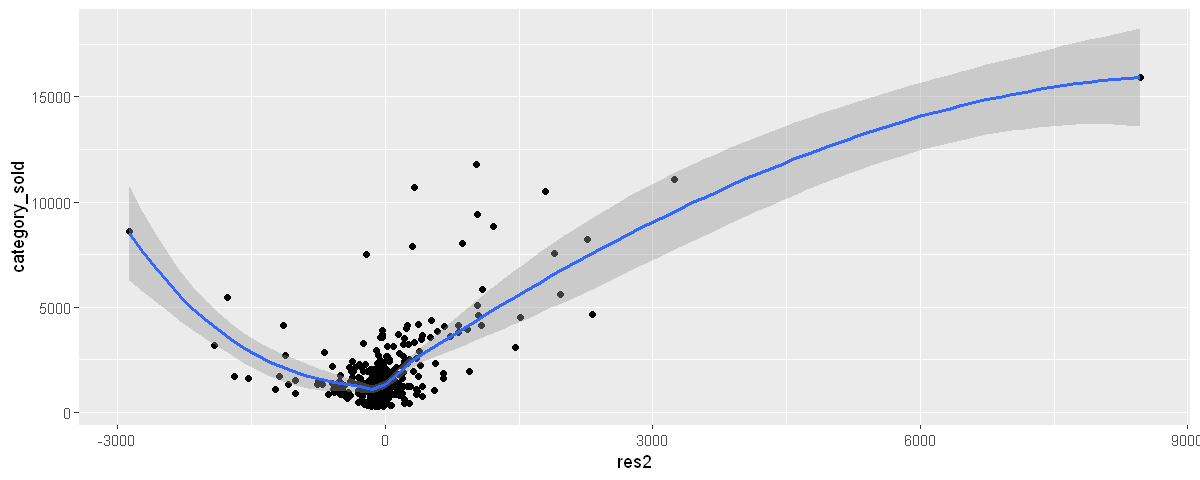

In [148]:
ggplot(tayt_train,aes(x=res2,y=category_sold)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


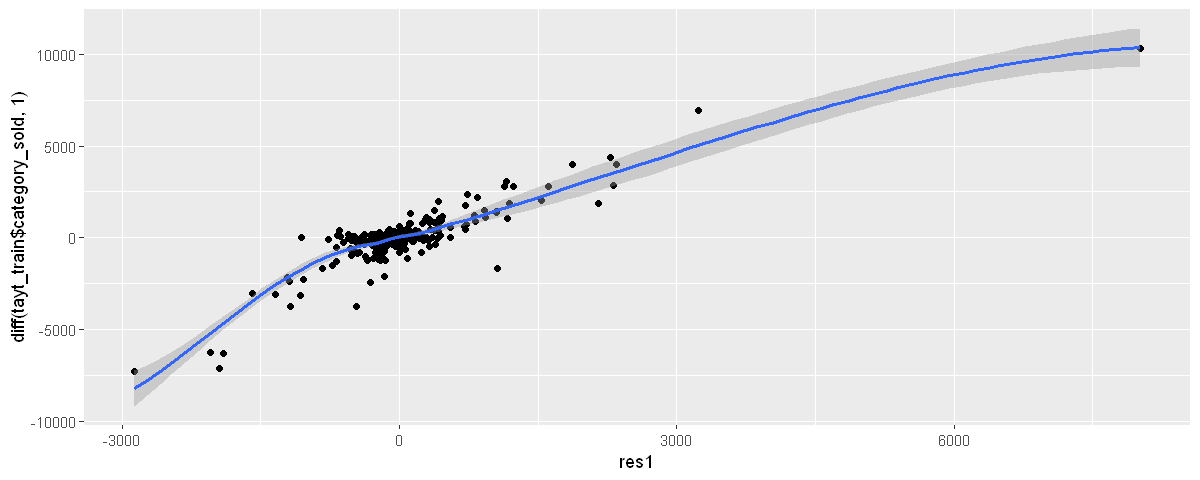

In [149]:
ggplot(tayt_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(tayt_train$category_sold,1))) + geom_smooth(aes(y=diff(tayt_train$category_sold,1)))

In [150]:
cor(tayt_train[2:.N]$res2,diff(tayt_train$category_sold,1))
tayt_train$diff_sold <- c(NA,diff(tayt_train$category_sold,1))
tayt$diff_sold <- c(NA,diff(tayt$category_sold,1))

[1] 0.846542

In [151]:
arima(tayt_ts,order=c(4,1,4),xreg=as.matrix(tayt_train$diff_basket,tayt_train$diff_sold))


Call:
arima(x = tayt_ts, order = c(4, 1, 4), xreg = as.matrix(tayt_train$diff_basket, 
    tayt_train$diff_sold))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3      ma4
      0.4504  -0.1341  0.0619  -0.1215  -0.6308  0.1225  -0.1774  -0.2457
s.e.  0.2466   0.3079  0.2870   0.1532   0.2473  0.3498   0.3259   0.2183
      as.matrix(tayt_train$diff_basket, tayt_train$diff_sold)
                                                       0.0253
s.e.                                                   0.0110

sigma^2 estimated as 466190:  log likelihood = -2877.11,  aic = 5774.23


	Ljung-Box test

data:  Residuals from ARIMA(4,1,4)
Q* = 4.4918, df = 3, p-value = 0.213

Model df: 9.   Total lags used: 12



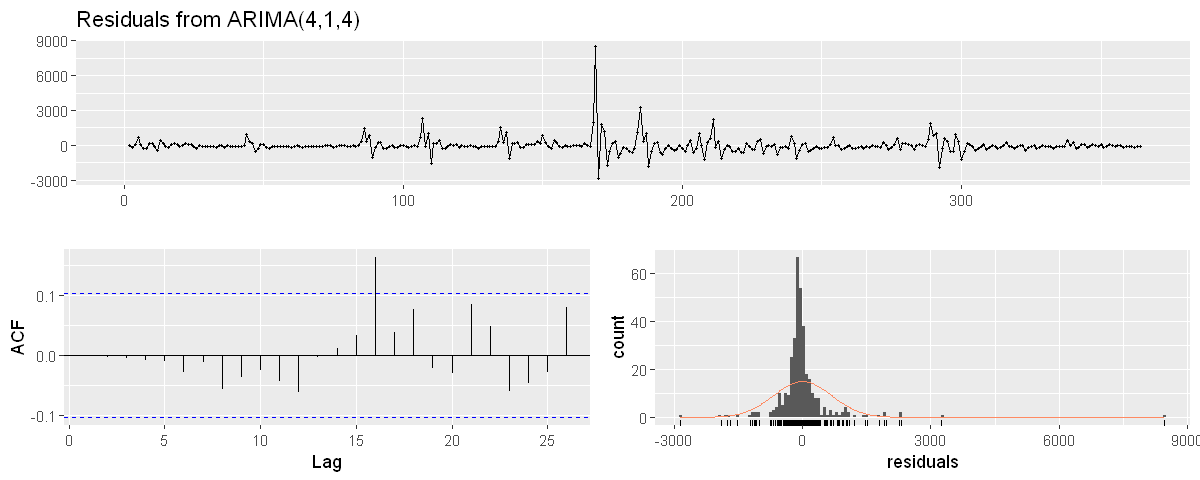

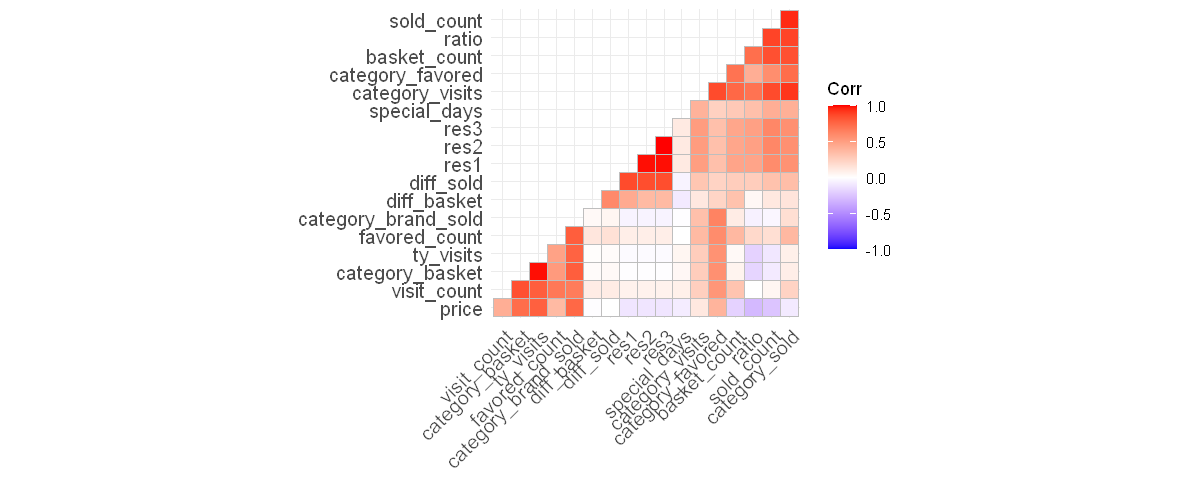

In [152]:
model_tayt_arimax <- arima(tayt_ts,order=c(4,1,4),xreg=as.matrix(tayt_train$diff_basket,tayt_train$diff_sold))
checkresiduals(model_tayt_arimax)
tayt_train$res3 <- model_tayt_arimax$residuals
corr <- cor(tayt_train[!is.na(tayt_train$price) & !is.na(tayt_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

The final model has basket_count and category_sold as regressors. And residuals seem better both in stationarity and distribution manners.

In [153]:
forecast_data_tayt <- data.table(event_date=tayt[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=tayt[event_date>=test_start&event_date<=test_end,]$sold_count)
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- tayt[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(4,1,4))
  model_arimax <- Arima(tayt_ts,order=c(4,1,4),xreg=as.matrix(tayt_train$diff_basket,tayt_train$diff_sold))
  newreg <- forecast(auto.arima(train_dt$diff_basket),h=1)$mean[1]
  newreg2 <- forecast(auto.arima(train_dt$diff_sold),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=as.matrix(newreg,newreg2))
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  
}
forecast_data_tayt <- forecast_data_tayt[,`:=`(arima_p=arima_fc,
                                     arimax_p=arimax_fc)]
accu(forecast_data_tayt$sold_count,forecast_data_tayt$arima_p)
accu(forecast_data_tayt$sold_count,forecast_data_tayt$arimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,286,76.66439,0.2680573,-0.2113092,0.3264882,94.67903,85.45907,0.2988079,0.2988079


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,286,76.66439,0.2680573,-0.3182763,0.4311711,116.9066,111.066,0.3883425,0.3883425


ARIMAX model has significantly worse results than the ARIMA model, therefore, ARIMA model is selected as a better model.

## PROD3 | Bikini Ustu 2, TRENDYOLMILLA

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


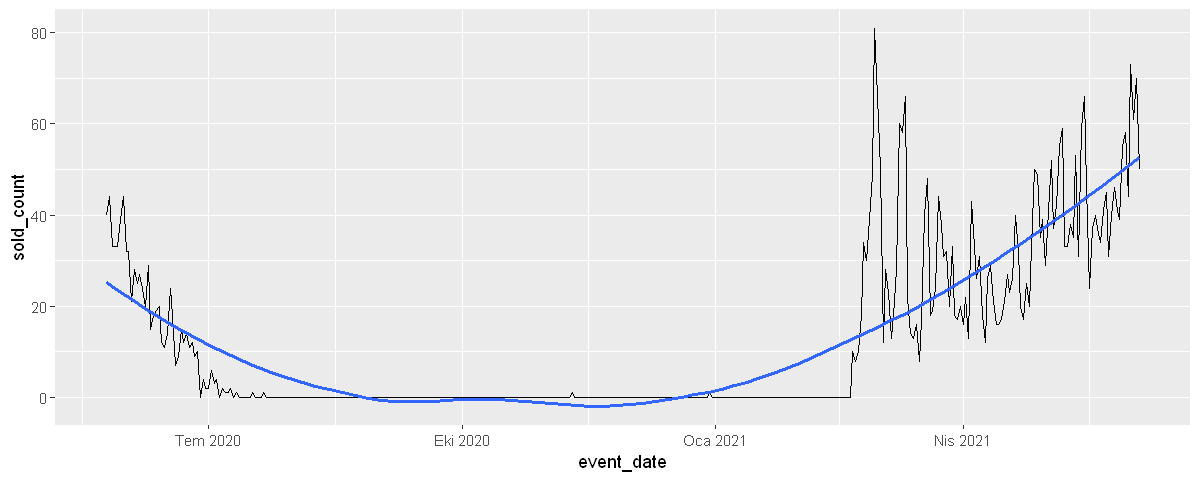

In [154]:
ggplot(prod3, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The data seems to be dirty. 
* From August 2020 to February 2021, somehow there are a lot of days with zero sales. 
* In the summer season, the sales increase. 
* The variance is definitely not constant. 
* The mean is also not constant over time.
* The data is not stationary at this point. 

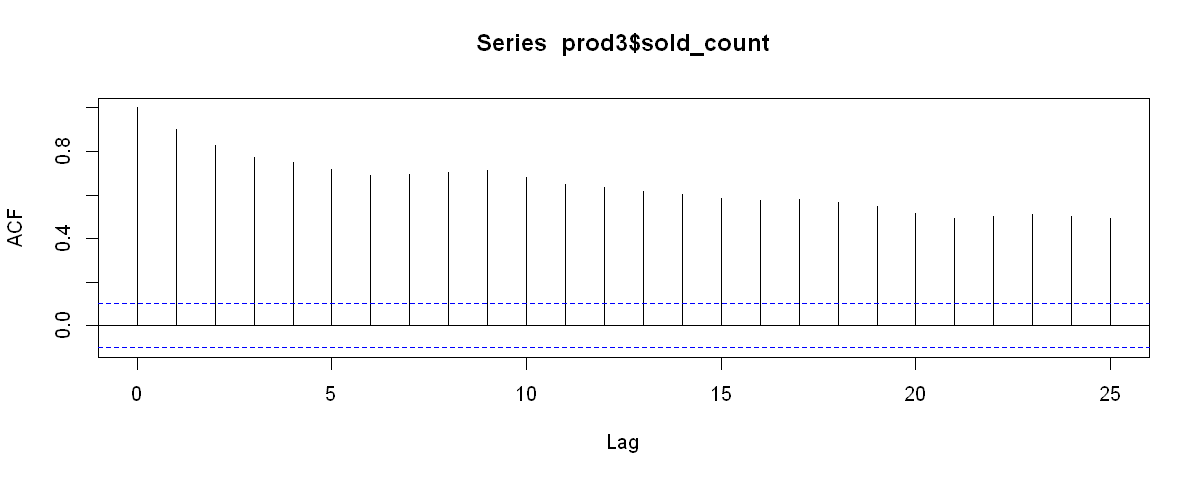

In [155]:
acf(prod3$sold_count) 

The autocorrelation values decrease. There is a peak value at lag 9. 

### Weekly Decomposition

Because the variance does not regulary increase, additive decomposition will be used. 

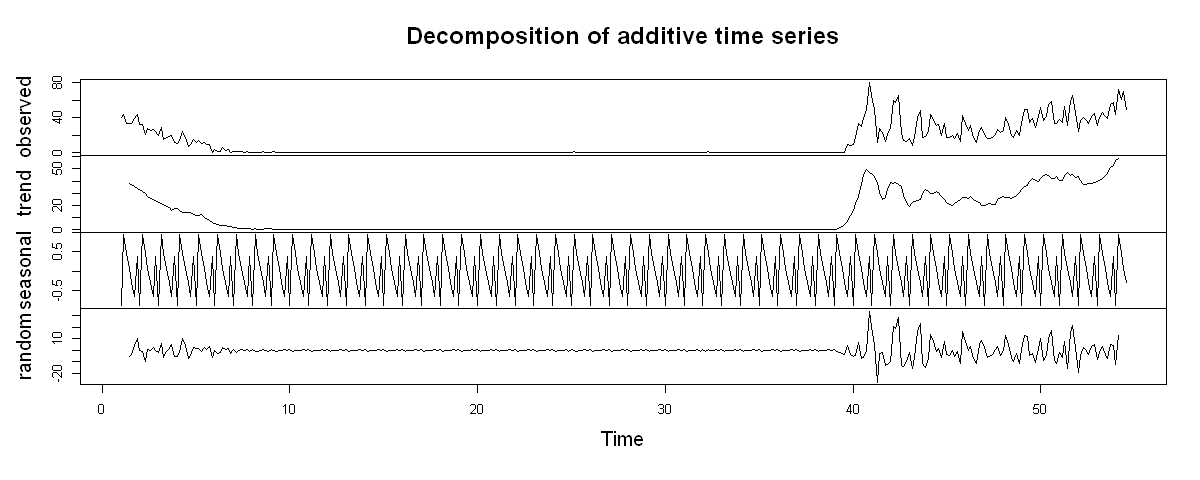

In [156]:
prod3_weekly_dec <- decompose(ts(prod3$sold_count, freq=7), type="additive")
plot(prod3_weekly_dec)

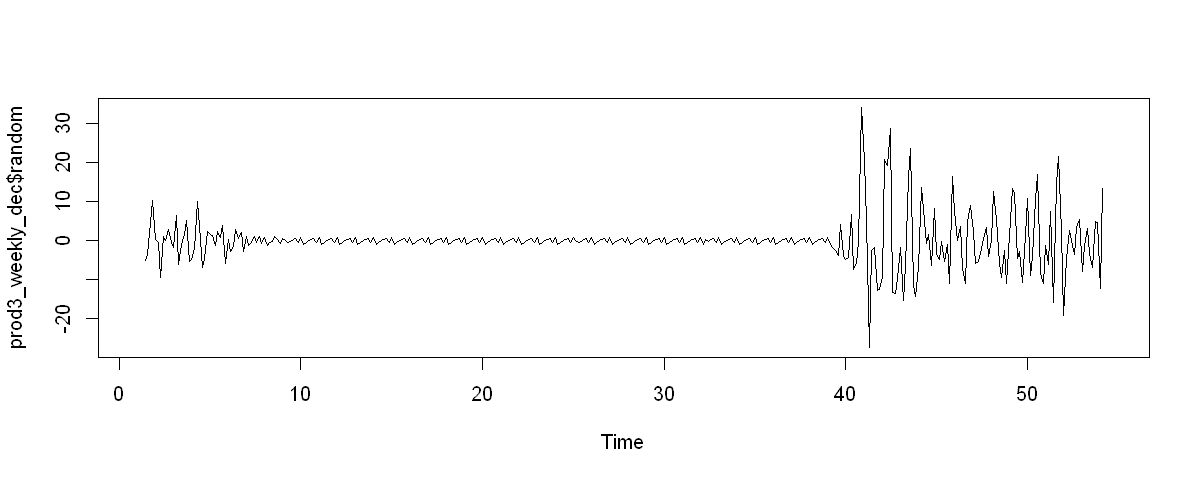

In [157]:
plot(prod3_weekly_dec$random)

* It seems that the decomposed data is not stationary. But, we should check the KPSS test result to determine whether it is stationary. 
* The mean is constant over time. 
* The variance changes. 

In [158]:
u_test <- ur.kpss(prod3_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0065 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Even though the variance changes over time, surprisingly, the test result says that the decomposed data is stationary. 

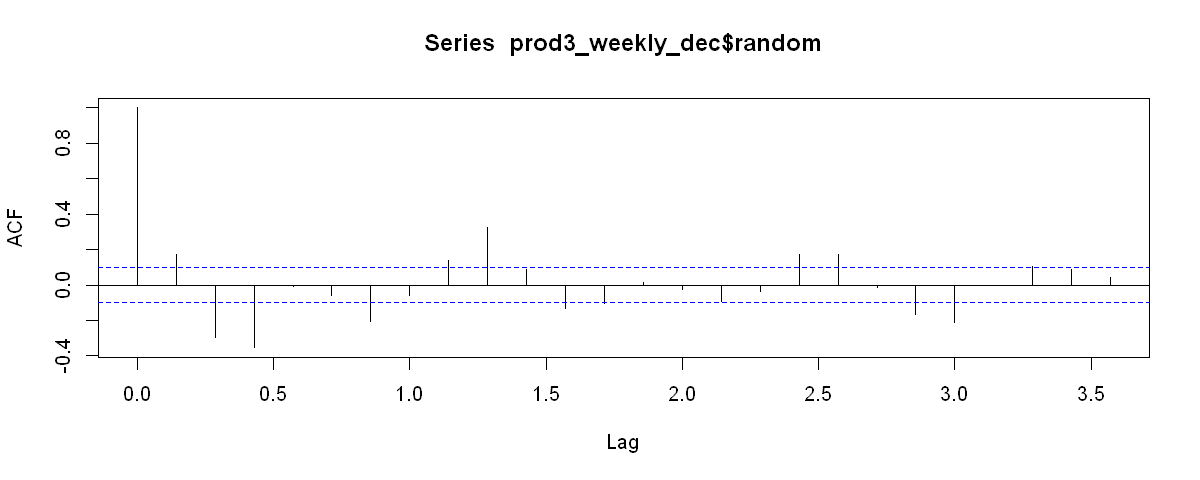

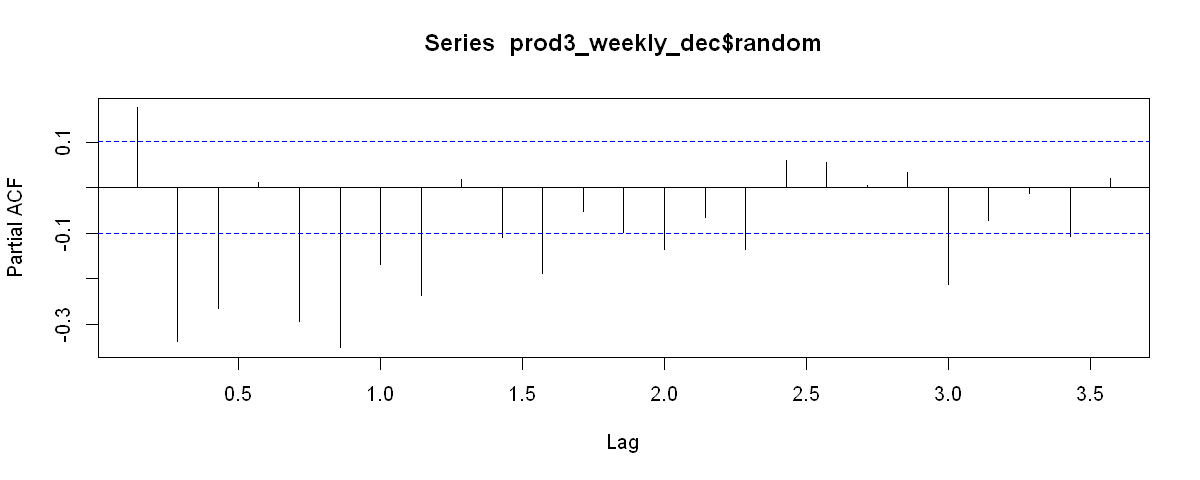

In [159]:
acf(prod3_weekly_dec$random, na.action=na.pass)
pacf(prod3_weekly_dec$random, na.action=na.pass)

At lag 2 and 6, there is relatively high correlations seen by the PACF graph. 

### Monthly Decomposition

month,sold_count
2020 May,266
2020 Haz,494
2020 Tem,24
2020 Ağu,0
2020 Eyl,0
2020 Eki,0
2020 Kas,1
2020 Ara,1
2021 Oca,0
2021 Şub,279


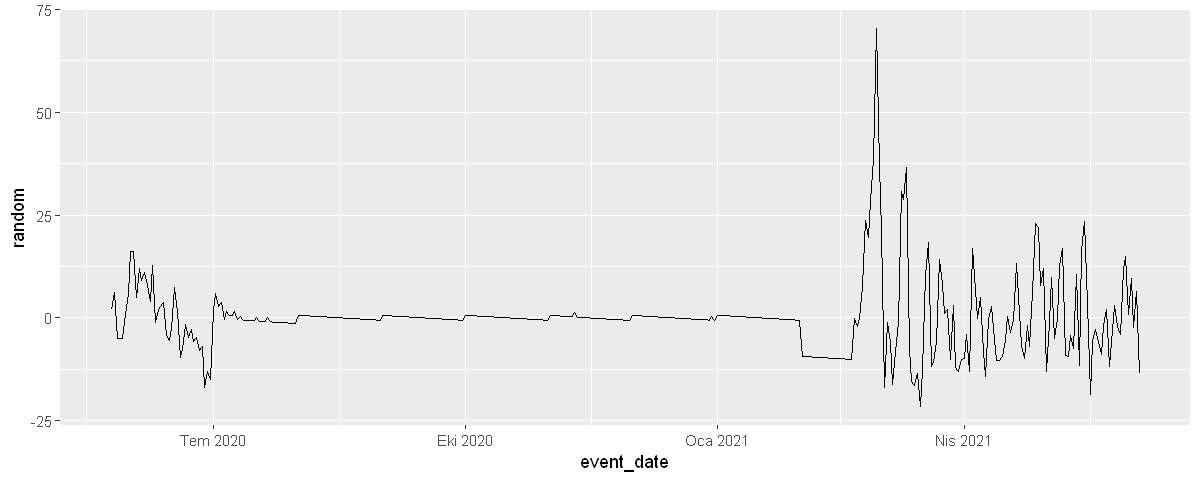

In [160]:
prod3_monthly <- prod3[, month:=yearmonth(event_date)]
prod3_monthly[, .(sold_count=sum(sold_count)), by=month]
prod3_monthly[, trend:=1:.N]

prod3_reg <- lm(sold_count~trend+as.factor(month), data=prod3_monthly)
prod3_monthly[, regOutput:=predict(prod3_reg, prod3_monthly)]

prod3_monthly[, random:=sold_count-regOutput]

ggplot(prod3_monthly, aes(x=event_date, y=random)) + geom_line()

* Again, the variance is not constant after decomposition. 
* The mean seems to be constant. 

In [161]:
u_test <- ur.kpss(prod3_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.027 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the test result, we cannot reject the null hyphothesis. The decomposed data is stationary. 

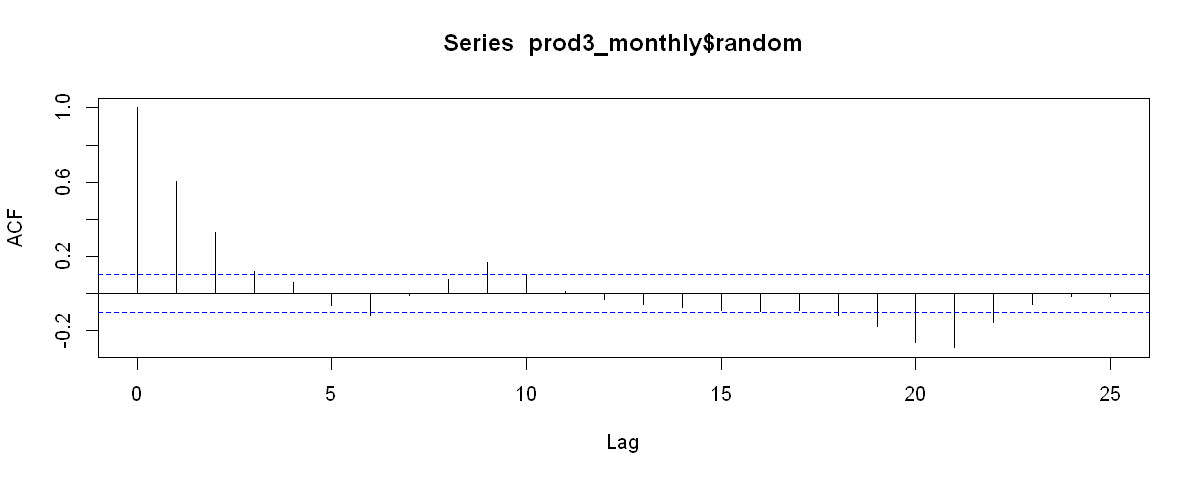

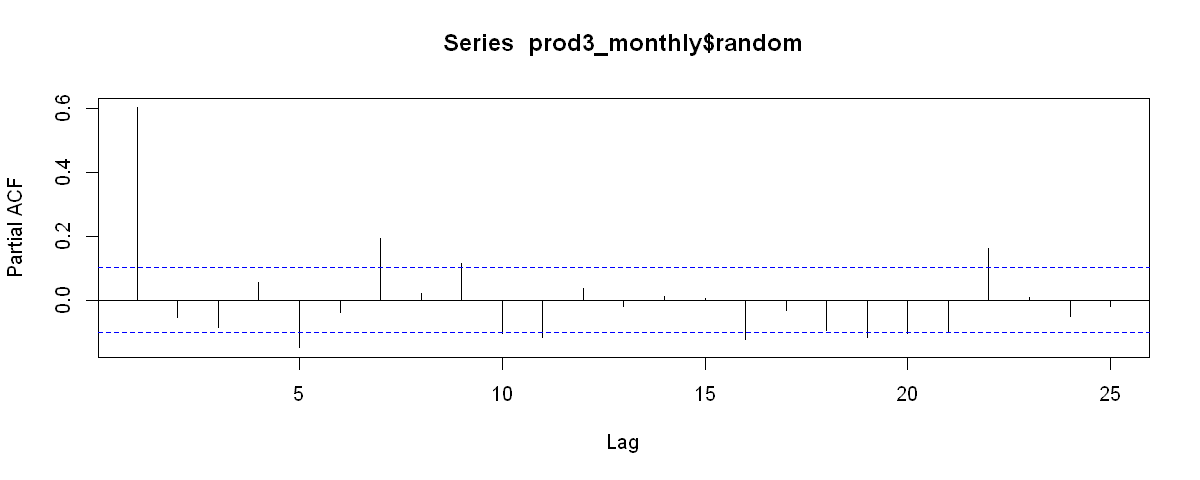

In [162]:
acf(prod3_monthly$random, na.action=na.pass)
pacf(prod3_monthly$random, na.action=na.pass)

From the graphs above, it can be said that the data is autocorrelated with its first lag. 

### Building an ARIMA Model

In [163]:
bikini2 <- data[product_content_id=="32737302",][order(event_date)]
bikini2$is_summer <- 0
bikini2[month(bikini2$event_date) %in% c(6,7,8),]$is_summer <- 1
bikini2_train <- bikini2[event_date<test_start,]
bikini2_ts <- ts(bikini2_train$sold_count,freq=9)

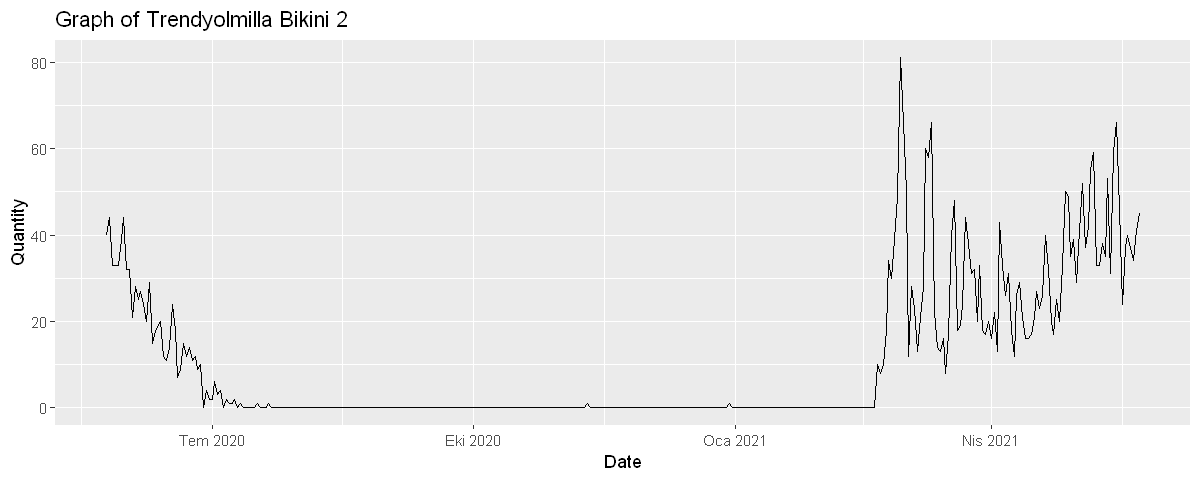

In [164]:
ggplot(bikini2_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Trendyolmilla Bikini 2", x= "Date", y="Quantity")

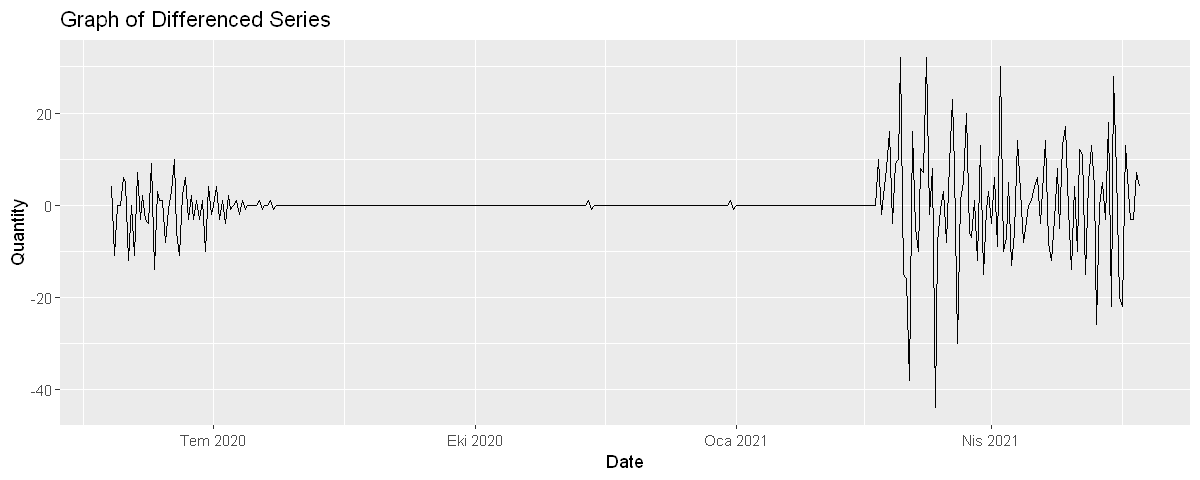

In [165]:
ggplot(bikini2_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(bikini2_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

After the differencing, series seem more stationary now. According to the decomposition, there is a seasonal cycle at every 9 data points.

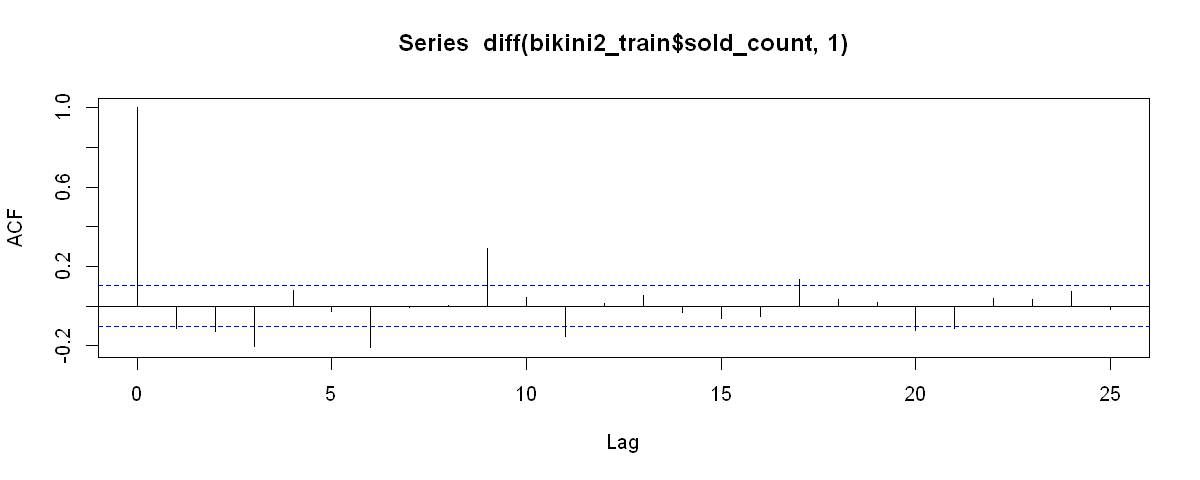

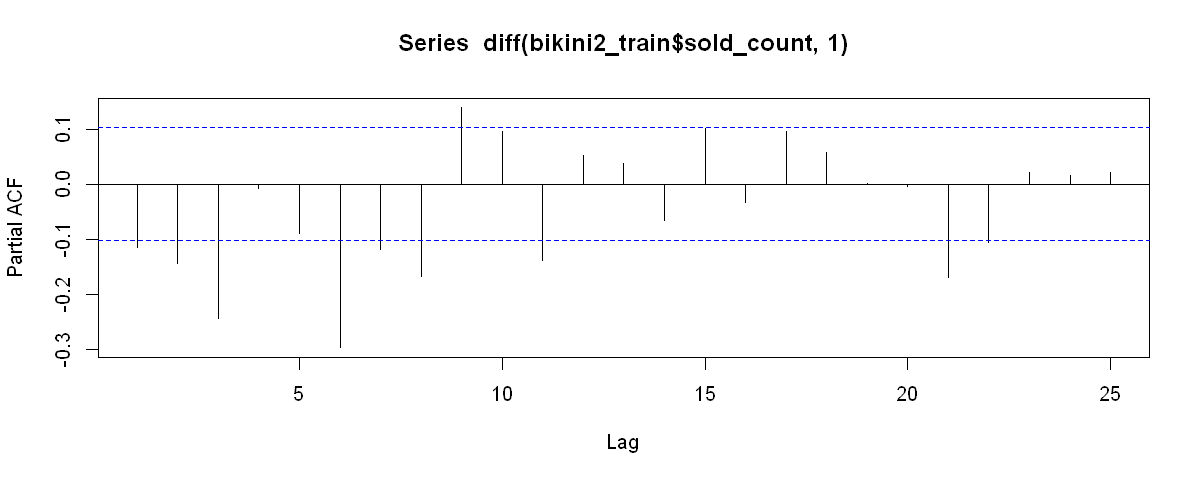

In [166]:
acf(diff(bikini2_train$sold_count,1))
pacf(diff(bikini2_train$sold_count,1))

After the analysis of ACF and PACF graphs, we could say that AR(1), AR(2), AR(3) and seasonal AR(1)-AR(2) could be tried. And also MA(2), MA(3) and seasonal MA(1)-MA(2) are strong candidates for a SARIMA model.

In [167]:
arima(bikini2_ts,order=c(1,1,2),seasonal=c(2,0,2))


Call:
arima(x = bikini2_ts, order = c(1, 1, 2), seasonal = c(2, 0, 2))

Coefficients:
         ar1      ma1      ma2    sar1     sar2     sma1     sma2
      0.5506  -0.8126  -0.0637  1.0568  -0.1474  -0.7218  -0.1810
s.e.  0.1059   0.1123   0.0773  0.2752   0.2070   0.2745   0.2258

sigma^2 estimated as 40.8:  log likelihood = -1188.94,  aic = 2393.87

In [168]:
arima(bikini2_ts,order=c(2,1,2),seasonal=c(2,0,2))


Call:
arima(x = bikini2_ts, order = c(2, 1, 2), seasonal = c(2, 0, 2))

Coefficients:
          ar1     ar2     ma1      ma2     sar1    sar2    sma1     sma2
      -0.3545  0.6187  0.0597  -0.8724  -0.1283  0.0899  0.4967  -0.0031
s.e.   0.0727  0.0643  0.0557   0.0487   0.8946  0.1594  0.8931   0.2924

sigma^2 estimated as 40.69:  log likelihood = -1188.49,  aic = 2394.97

In [169]:
arima(bikini2_ts,order=c(1,1,3),seasonal=c(2,0,2))

Warning message in arima(bikini2_ts, order = c(1, 1, 3), seasonal = c(2, 0, 2)):
"possible convergence problem: optim gave code = 1"


Call:
arima(x = bikini2_ts, order = c(1, 1, 3), seasonal = c(2, 0, 2))

Coefficients:
          ar1     ma1      ma2      ma3    sar1    sar2     sma1     sma2
      -0.2897  0.0664  -0.2486  -0.4093  0.9341  0.0205  -0.6119  -0.3536
s.e.   0.1209  0.1153   0.0492   0.0710  0.2239  0.2125   0.2231   0.2191

sigma^2 estimated as 39.4:  log likelihood = -1183,  aic = 2383.99

In [170]:
arima(bikini2_ts,order=c(3,1,3),seasonal=c(2,0,2))


Call:
arima(x = bikini2_ts, order = c(3, 1, 3), seasonal = c(2, 0, 2))

Coefficients:
          ar1      ar2     ar3     ma1      ma2      ma3     sar1    sar2
      -0.5967  -0.1284  0.3967  0.3948  -0.1596  -0.8572  -0.1397  0.0863
s.e.   0.0721   0.0909  0.0811  0.0453   0.0541   0.0528   0.8890  0.1550
        sma1     sma2
      0.4941  -0.0182
s.e.  0.8875   0.3244

sigma^2 estimated as 36.83:  log likelihood = -1171.43,  aic = 2364.85

In [171]:
arima(bikini2_ts,order=c(3,1,3),seasonal=c(1,0,1))


Call:
arima(x = bikini2_ts, order = c(3, 1, 3), seasonal = c(1, 0, 1))

Coefficients:
          ar1      ar2     ar3     ma1      ma2      ma3    sar1    sma1
      -0.5969  -0.1300  0.4022  0.3955  -0.1572  -0.8605  0.0243  0.3298
s.e.   0.0724   0.0891  0.0788  0.0458   0.0521   0.0499  0.1918  0.1809

sigma^2 estimated as 36.85:  log likelihood = -1171.58,  aic = 2361.16

In [172]:
auto.arima(bikini2_ts)

Series: bikini2_ts 
ARIMA(0,1,3)(0,0,1)[9] with drift 

Coefficients:
          ma1      ma2      ma3    sma1   drift
      -0.2151  -0.1920  -0.2952  0.3293  0.0050
s.e.   0.0542   0.0457   0.0568  0.0537  0.1324

sigma^2 estimated as 40.47:  log likelihood=-1184.98
AIC=2381.95   AICc=2382.19   BIC=2405.32

The best model is SARIMA(3,1,3)(1,0,1) with AIC value 2361.16.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)(1,0,1)[9]
Q* = 15.753, df = 10, p-value = 0.1069

Model df: 8.   Total lags used: 18



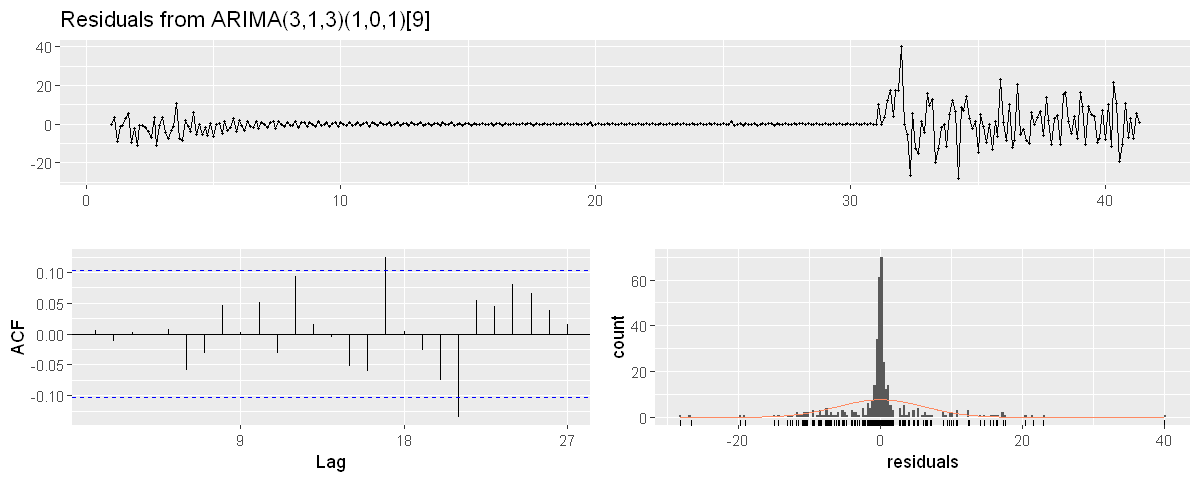

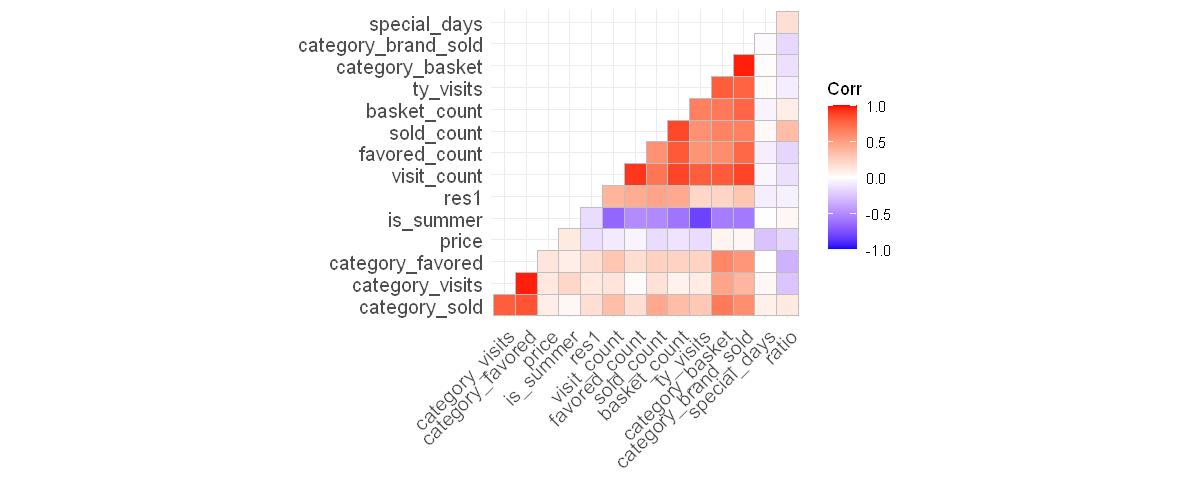

In [173]:
model_bikini2_sarima <- arima(bikini2_ts,order=c(3,1,3),seasonal=c(1,0,1))
checkresiduals(model_bikini2_sarima)
bikini2_train$res1 <- model_bikini2_sarima$residuals
corr <- cor(bikini2_train[!is.na(bikini2_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have constant mean at 0 and constant variance. Distribution seems normal. Due to the correlation with residuals, basket_count could be added as a regressor.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


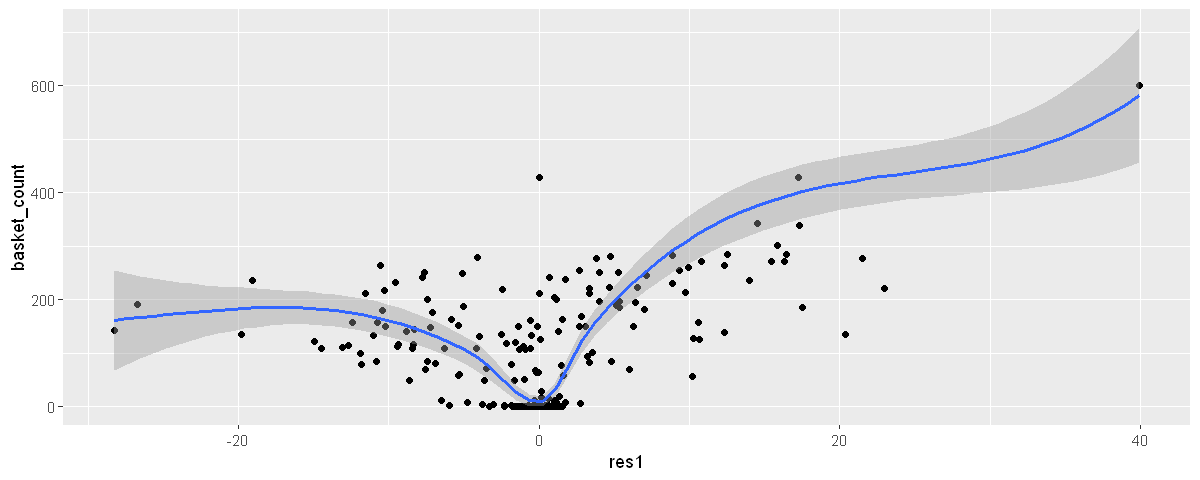

In [174]:
ggplot(bikini2_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


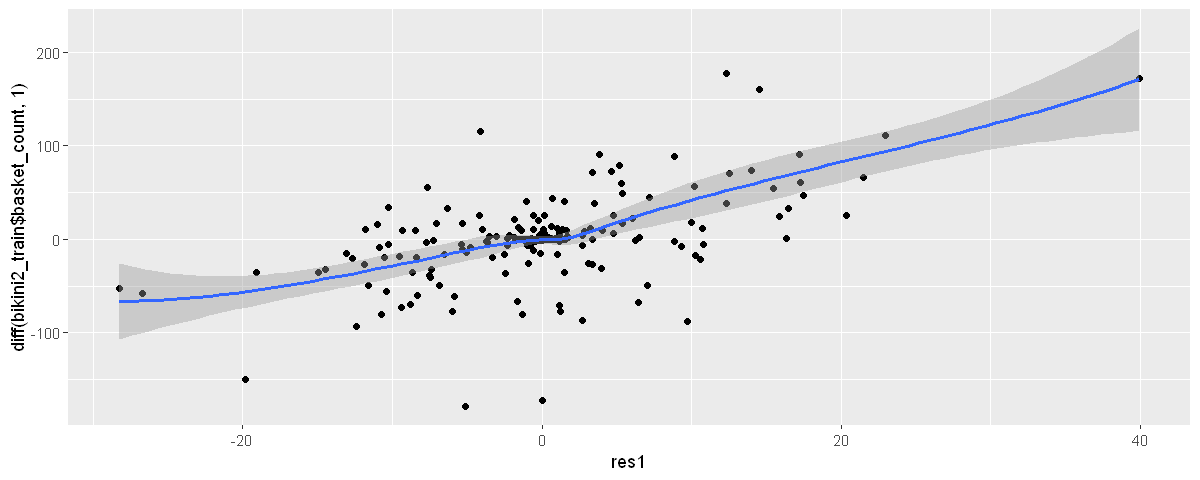

In [175]:
ggplot(bikini2_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(bikini2_train$basket_count,1))) + 
geom_smooth(aes(y=diff(bikini2_train$basket_count,1)))

In [176]:
cor(bikini2_train[2:.N]$res1,diff(bikini2_train$basket_count,1))
bikini2_train$diff_basket <- c(NA,diff(bikini2_train$basket_count,1))
bikini2$diff_basket <- c(NA,diff(bikini2$basket_count,1))

[1] 0.5496749


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)(1,0,1)[9]
Q* = 21.539, df = 9, p-value = 0.01046

Model df: 9.   Total lags used: 18



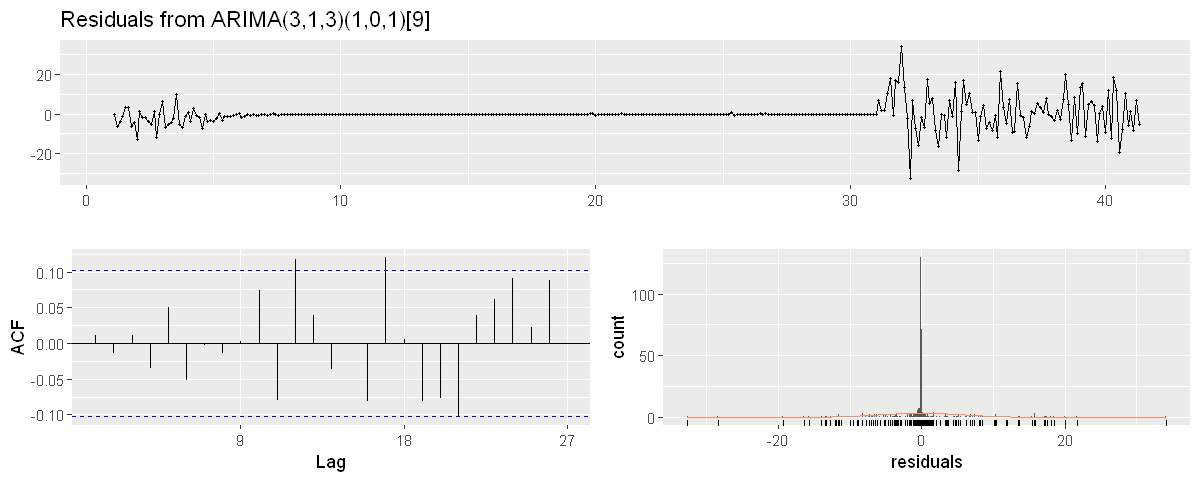

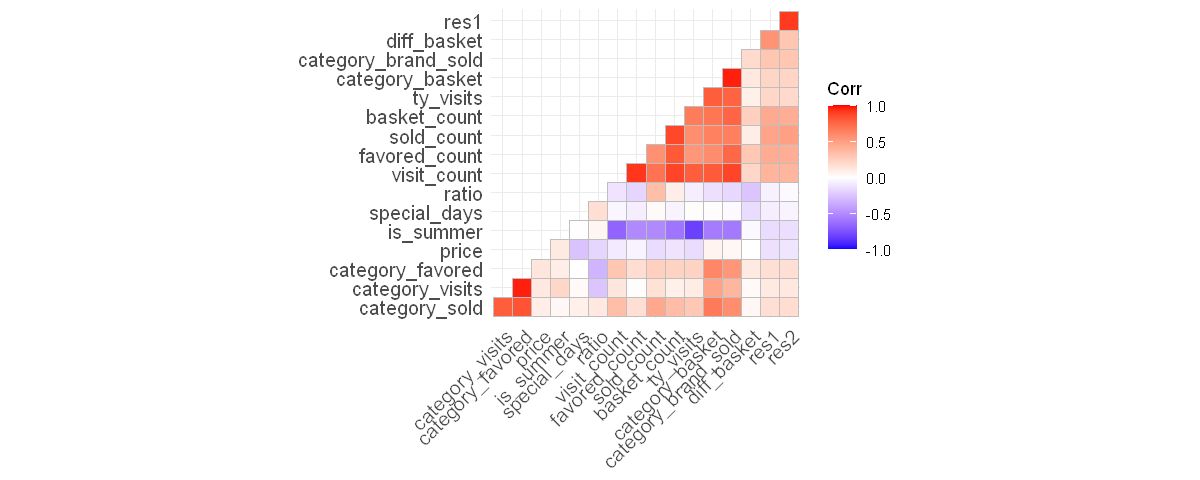

In [177]:
model_bikini2_arimax <- arima(bikini2_ts,order=c(3,1,3),seasonal=c(1,0,1),xreg=bikini2_train$diff_basket)
checkresiduals(model_bikini2_arimax)
bikini2_train$res2 <- model_bikini2_arimax$residuals
corr <- cor(bikini2_train[!is.na(bikini2_train$price) & !is.na(bikini2_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

In [178]:
forecast_data_bikini2 <- data.table(event_date=bikini2[event_date>=test_start&event_date<=test_end,]$event_date,
                                 sold_count=bikini2[event_date>=test_start&event_date<=test_end,]$sold_count)
sarima_fc <- numeric(0)
sarimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- bikini2[event_date<test_dates[i],]
  model_sarima <- Arima(train_dt$sold_count,order=c(3,1,3),seasonal=c(1,0,1))
  model_sarimax <- Arima(train_dt$sold_count,order=c(3,1,3),seasonal=c(1,0,1),xreg=train_dt$diff_basket)
  newreg <- forecast(auto.arima(train_dt$diff_basket),h=1)$mean[1]
  sarima_temp <- forecast(model_sarima)
  sarimax_temp <- forecast(model_sarimax,xreg=newreg)
  sarima_fc <- c(sarima_fc,sarima_temp$mean[1])
  sarimax_fc <- c(sarimax_fc,sarimax_temp$mean[1])
  
}
forecast_data_bikini2 <- forecast_data_bikini2[,`:=`(sarima_p=sarima_fc,
                                               sarimax_p=sarimax_fc)]
accu(forecast_data_bikini2$sold_count,forecast_data_bikini2$sarima_p)
accu(forecast_data_bikini2$sold_count,forecast_data_bikini2$sarimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,44.25,8.779033,0.1983962,0.01580656,0.2195914,9.710651,9.19389,0.2077715,0.2077715


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,44.25,8.779033,0.1983962,0.04027499,0.2833625,13.37043,12.10378,0.2735316,0.2735316


While ARIMAX model has a WMAPE value of 0.274, ARIMA model has WMAPE value of 0.208, so, ARIMA model is selected as the final model.

## PROD2 | Bikini Ustu 1, TRENDYOLMILLA

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


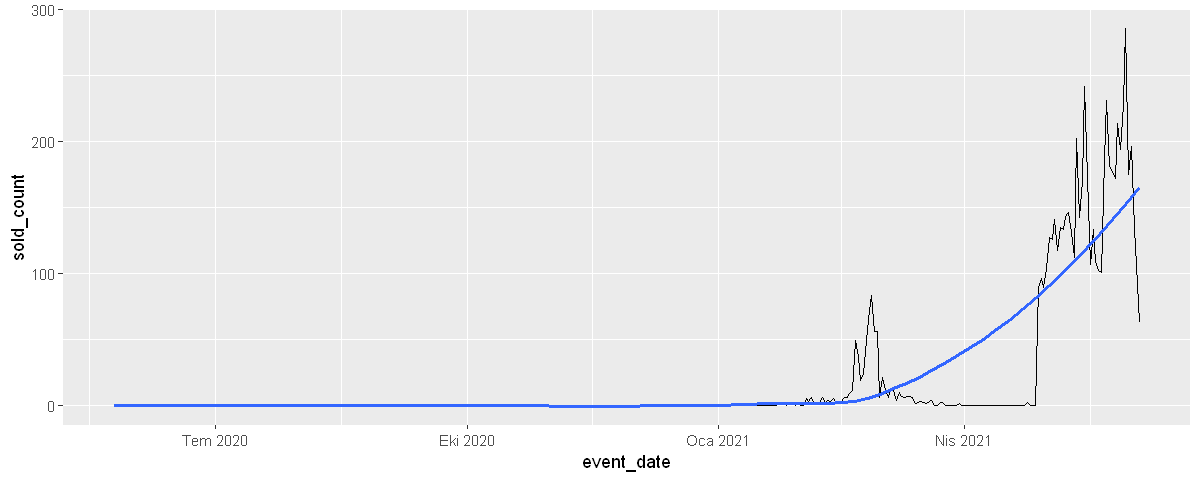

In [179]:
ggplot(prod2, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* Until February 2021, there is no sales. The product may be introduced in February 2021. 
* The mean and variance are not constant over time. 

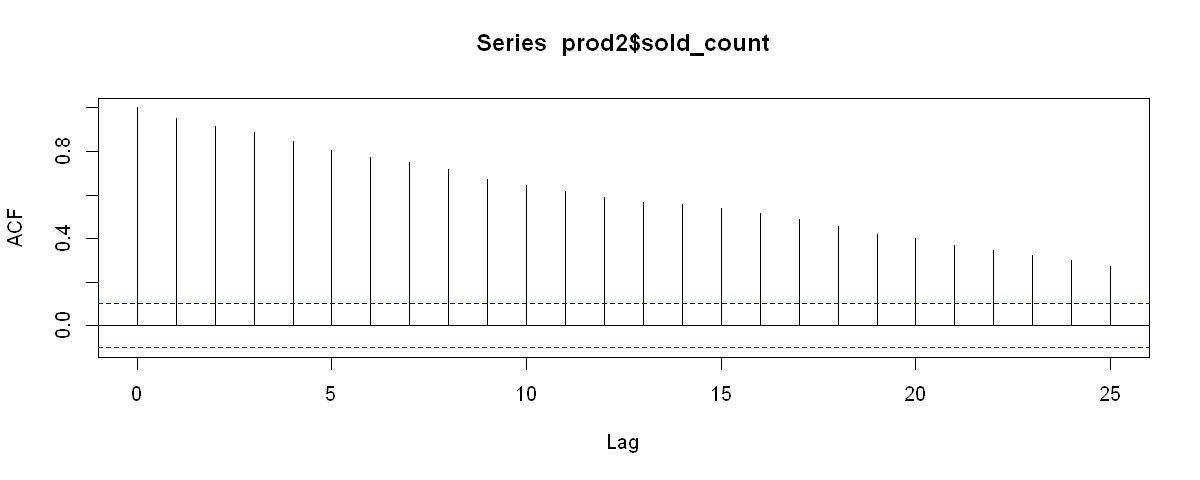

In [180]:
acf(prod2$sold_count) 

There is decrease in ACF graph which may mean that there is a trend on the data. 

### Weekly Decomposition

Additive decomposition will be used because the variance does not increase. 

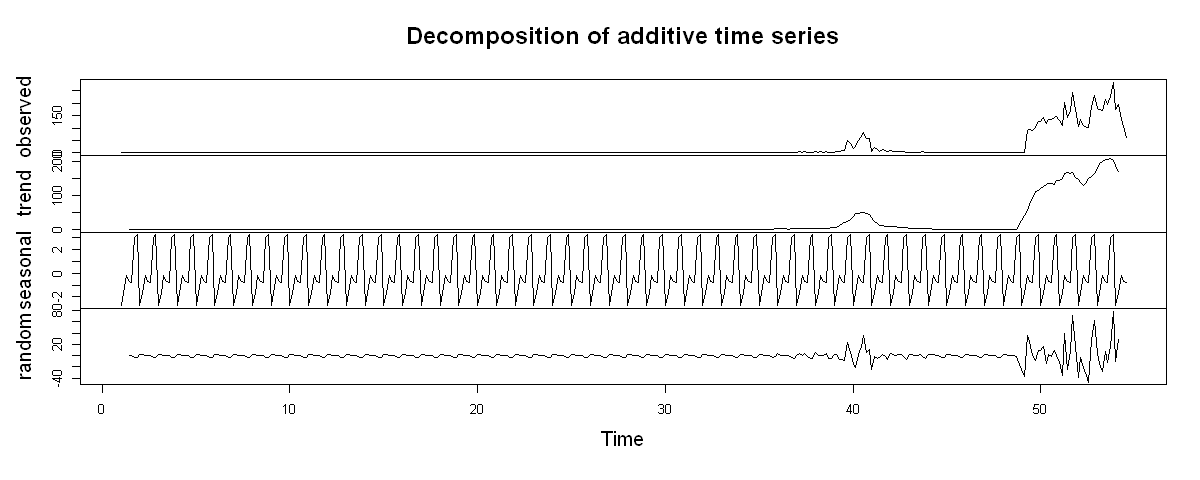

In [181]:
prod2_weekly_dec <- decompose(ts(prod2$sold_count, freq=7), type="additive")
plot(prod2_weekly_dec)

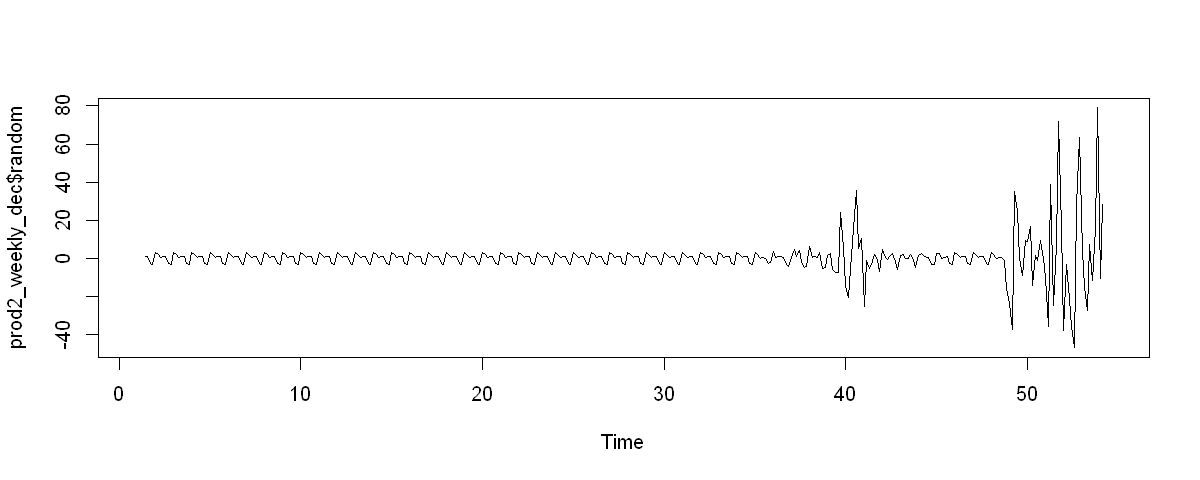

In [182]:
plot(prod2_weekly_dec$random)

* The mean is constant. 
* The variance is changing over time. It is higher at the last part of the data. 

In [183]:
u_test <- ur.kpss(prod2_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1049 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS test above, the data is stationary. 

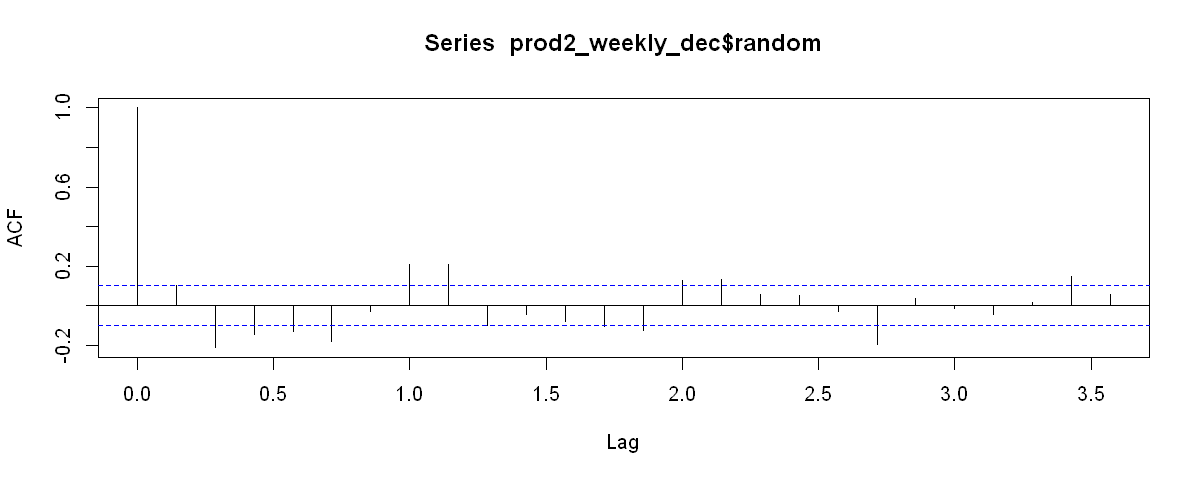

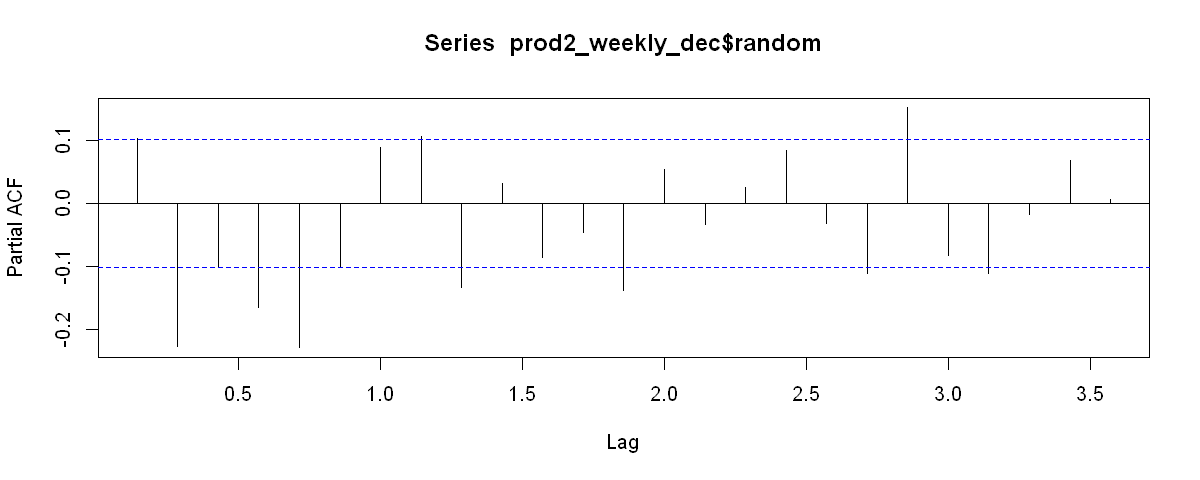

In [184]:
acf(prod2_weekly_dec$random, na.action=na.pass)
pacf(prod2_weekly_dec$random, na.action=na.pass)

There are a little correlation at lag 2 and lag 5. We can see them on the PACF graph. 

### Monthly Decomposition

month,sold_count
2020 May,0
2020 Haz,0
2020 Tem,0
2020 Ağu,0
2020 Eyl,0
2020 Eki,0
2020 Kas,0
2020 Ara,0
2021 Oca,9
2021 Şub,514


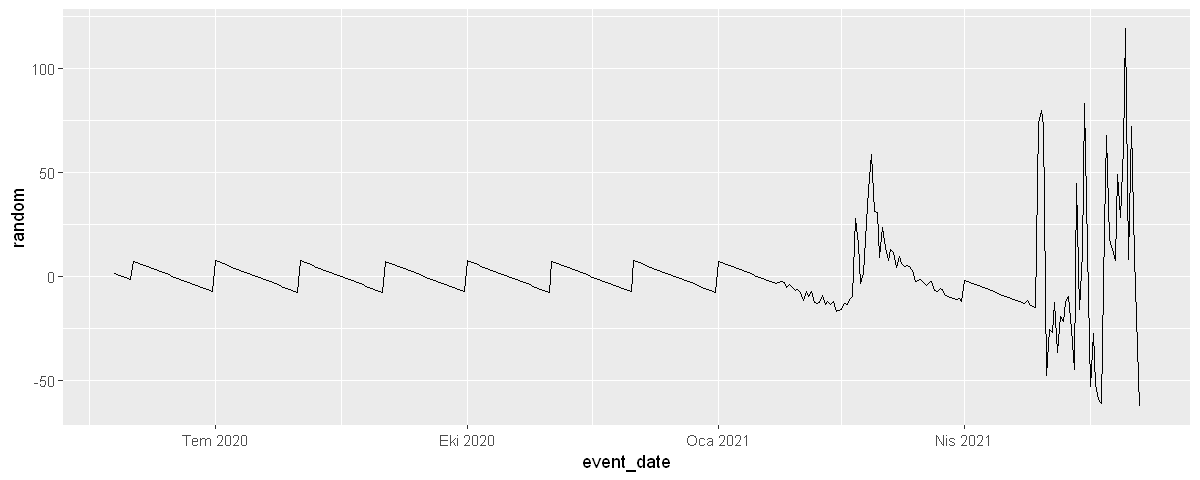

In [185]:
prod2_monthly <- prod2[, month:=yearmonth(event_date)]
prod2_monthly[, .(sold_count=sum(sold_count)), by=month]
prod2_monthly[, trend:=1:.N]

prod2_reg <- lm(sold_count~trend+as.factor(month), data=prod2_monthly)
prod2_monthly[, regOutput:=predict(prod2_reg, prod2_monthly)]

prod2_monthly[, random:=sold_count-regOutput]

ggplot(prod2_monthly, aes(x=event_date, y=random)) + geom_line()

* The variance is changing at the last part. 
* It is seen that the mean is constant over time.

In [186]:
u_test <- ur.kpss(prod2_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0336 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the unit test, the data is stationary. 

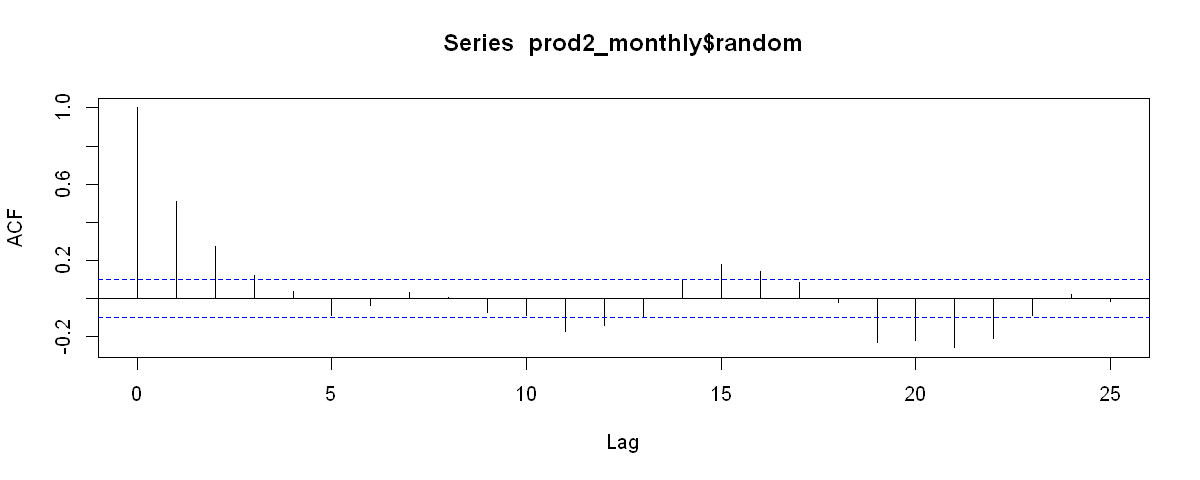

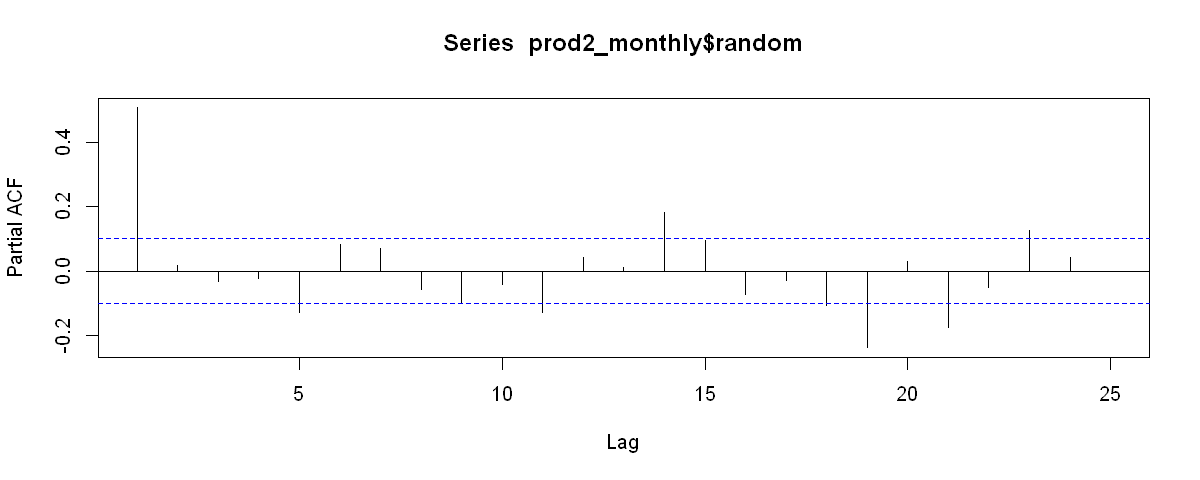

In [187]:
acf(prod2_monthly$random, na.action=na.pass)
pacf(prod2_monthly$random, na.action=na.pass)

The first lag has a high correlation value. 

### Building an ARIMA Model 

In [188]:
bikini1 <- data[product_content_id=="73318567",][order(event_date)]
bikini1_train <- bikini1[event_date<test_start,]
bikini1_ts <- ts(bikini1_train$sold_count)

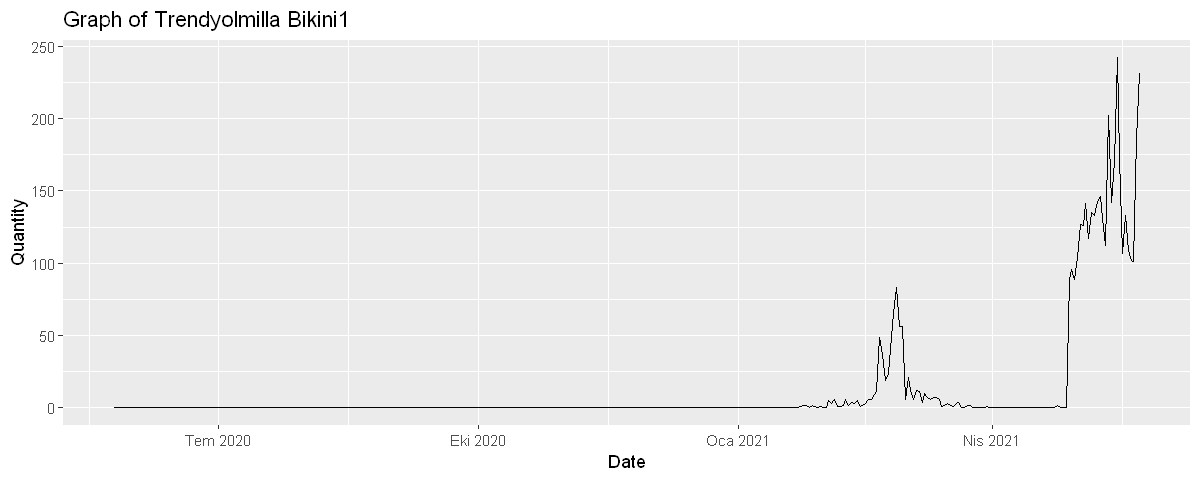

In [189]:
ggplot(bikini1_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Trendyolmilla Bikini1", x= "Date", y="Quantity")

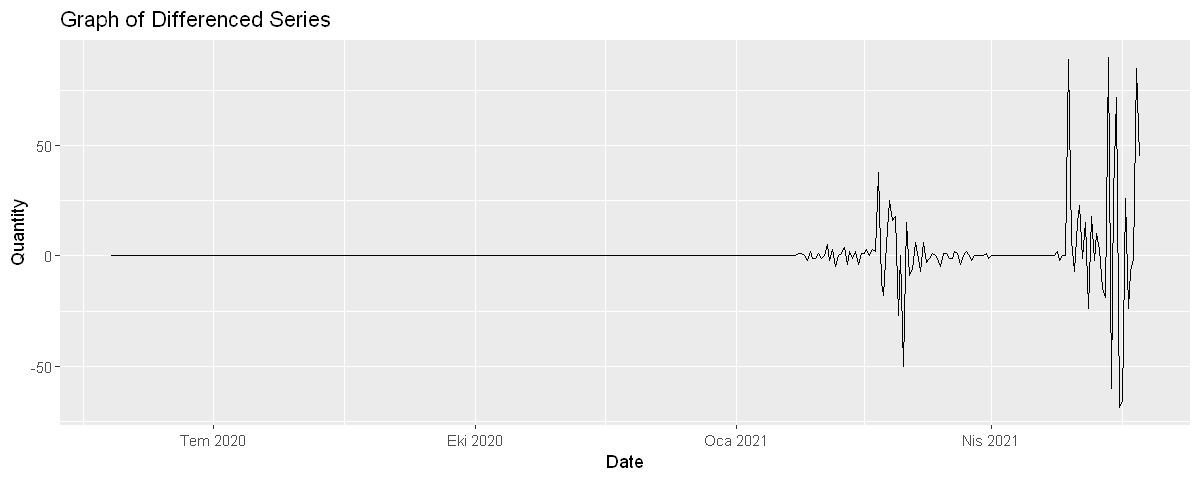

In [190]:
ggplot(bikini1_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(bikini1_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

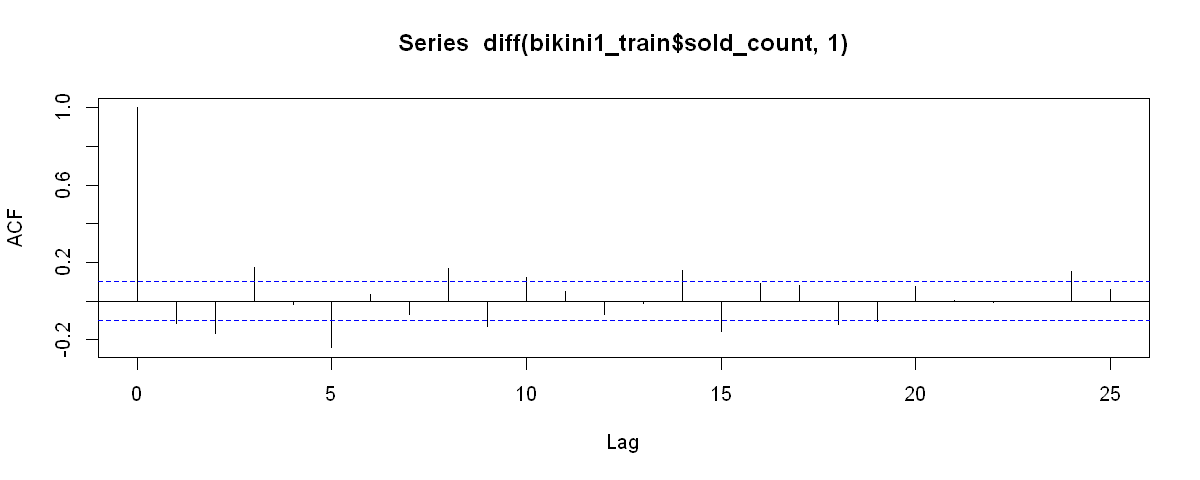

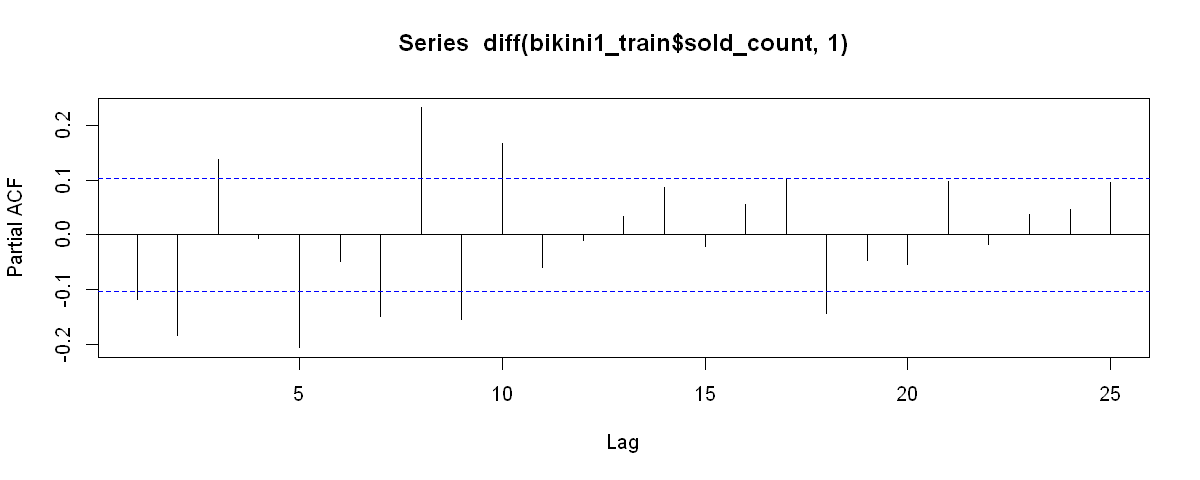

In [191]:
acf(diff(bikini1_train$sold_count,1))
pacf(diff(bikini1_train$sold_count,1))

According to the ACF and PACF graphs, AR(2), AR(3) and MA(2), MA(3) are good candidates for an ARIMA model.

In [192]:
arima(bikini1_ts,order=c(3,1,2))


Call:
arima(x = bikini1_ts, order = c(3, 1, 2))

Coefficients:
          ar1      ar2     ar3      ma1     ma2
      -0.0028  -0.7417  0.1256  -0.1451  0.6743
s.e.   0.1409   0.1238  0.0737   0.1341  0.1596

sigma^2 estimated as 136:  log likelihood = -1407.05,  aic = 2826.1

In [193]:
arima(bikini1_ts,order=c(2,1,3))


Call:
arima(x = bikini1_ts, order = c(2, 1, 3))

Coefficients:
          ar1      ar2     ma1     ma2     ma3
      -0.1486  -0.7396  0.0175  0.6446  0.1442
s.e.   0.1149   0.1058  0.1201  0.1262  0.0658

sigma^2 estimated as 135.6:  log likelihood = -1406.5,  aic = 2825

In [194]:
auto.arima(bikini1_ts)

Series: bikini1_ts 
ARIMA(5,1,1) with drift 

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1   drift
      0.2489  -0.0993  0.1647  -0.1087  -0.2573  -0.3963  0.5352
s.e.  0.1333   0.0601  0.0629   0.0587   0.0591   0.1299  0.3477

sigma^2 estimated as 134:  log likelihood=-1400.83
AIC=2817.66   AICc=2818.06   BIC=2848.81

The lowest AIC value is 2825 on the ARIMA(2,1,3)


	Ljung-Box test

data:  Residuals from ARIMA(2,1,1)
Q* = 63.143, df = 7, p-value = 3.548e-11

Model df: 3.   Total lags used: 10



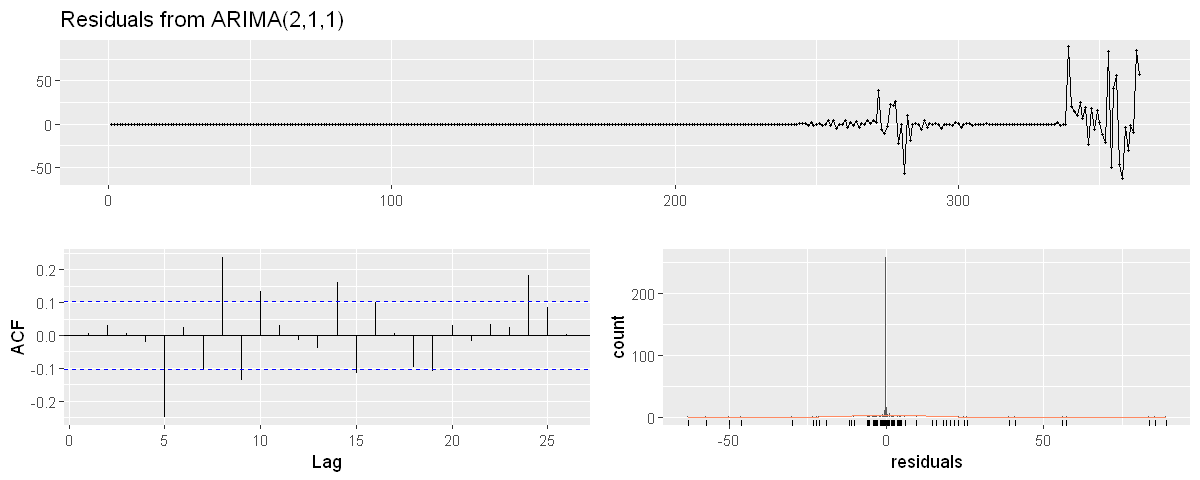

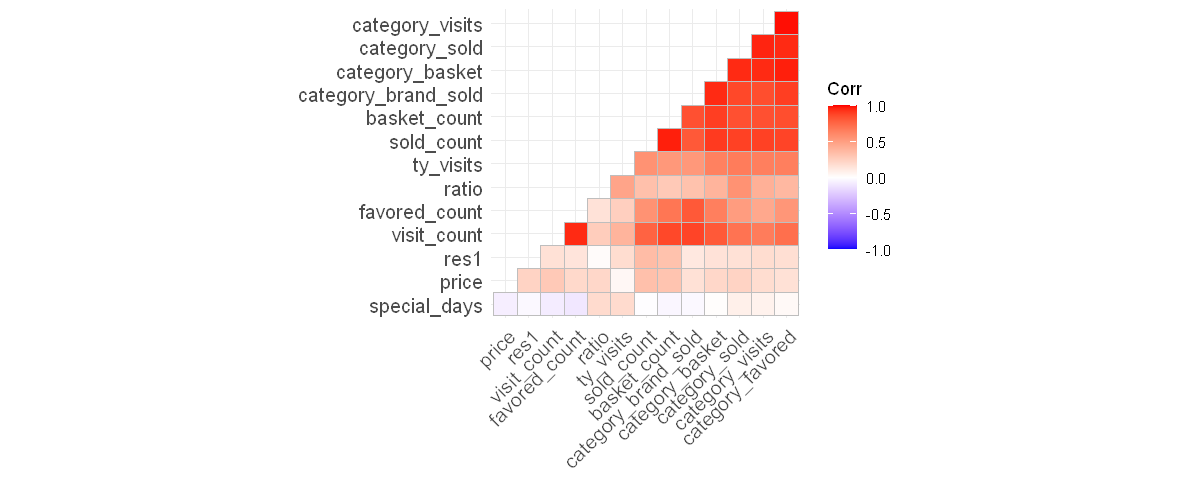

In [195]:
model_bikini1_arima <- arima(bikini1_ts,order=c(2,1,1))
checkresiduals(model_bikini1_arima)
bikini1_train$res1 <- model_bikini1_arima$residuals
corr <- cor(bikini1_train[!is.na(bikini1_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

There is no significant correlation between residuals and other variables because the nature of the data.

In [196]:
forecast_data_bikini1 <- data.table(event_date=bikini1[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=bikini1[event_date>=test_start&event_date<=test_end,]$sold_count)
arima_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- bikini1[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(3,1,4))
  arima_temp <- forecast(model_arima)
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  
}
forecast_data_bikini1 <- forecast_data_bikini1[,`:=`(arima_p=arima_fc)]
accu(forecast_data_bikini1$sold_count,forecast_data_bikini1$arima_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,203.375,38.95029,0.1915196,-0.0007349937,0.189865,48.06776,37.87385,0.1862267,0.1862267


For the "Trendoylmilla Bikini 1 " product, only an ARIMA model has been built.

# PROD1 | Mont, ALTINYILDIZ CLASSICS

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


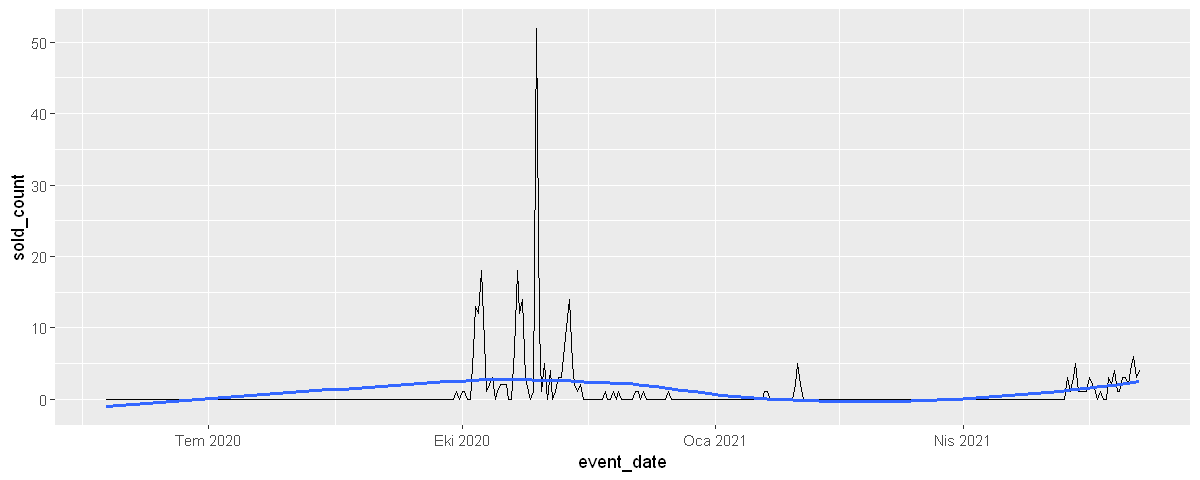

In [197]:
ggplot(prod1, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* By the blue line, it seems that the mean is not constant. It is wavy. 
* Variance changes over time. 
* There are days with zero sale.  
* It appears that the data is not stationary. 

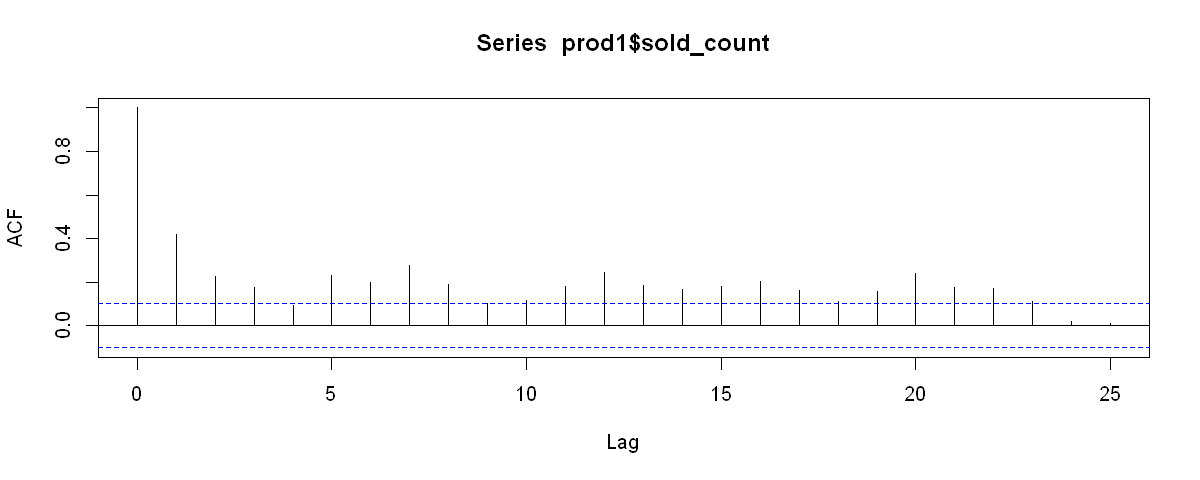

In [198]:
acf(prod1$sold_count) 

There is a relatively high autocorrelation with lag 1. 

### Weekly Decomposition

Additive decomposition will be used because the variance does not increase. 

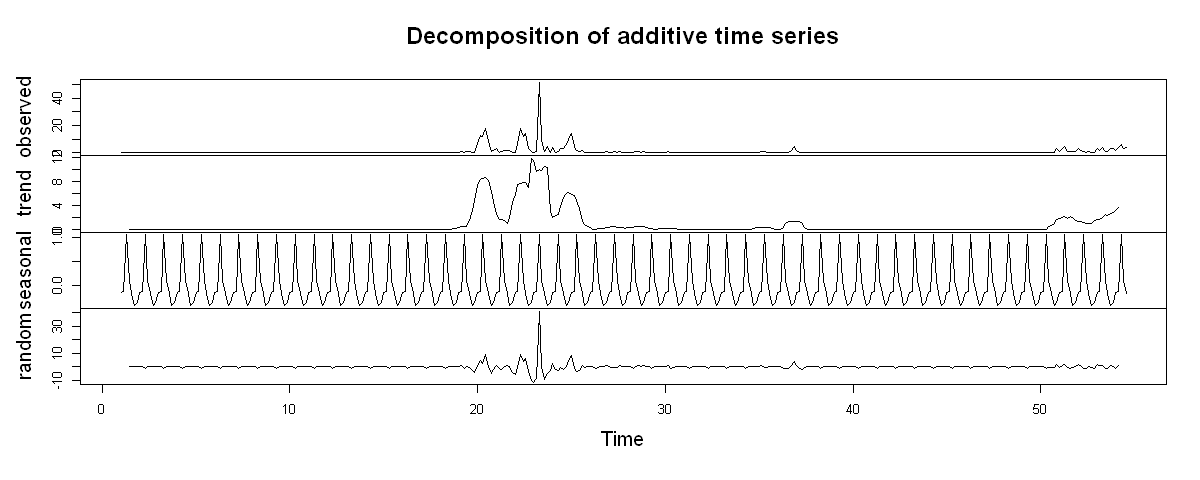

In [199]:
prod1_weekly_dec <- decompose(ts(prod1$sold_count, freq=7), type="additive")
plot(prod1_weekly_dec)

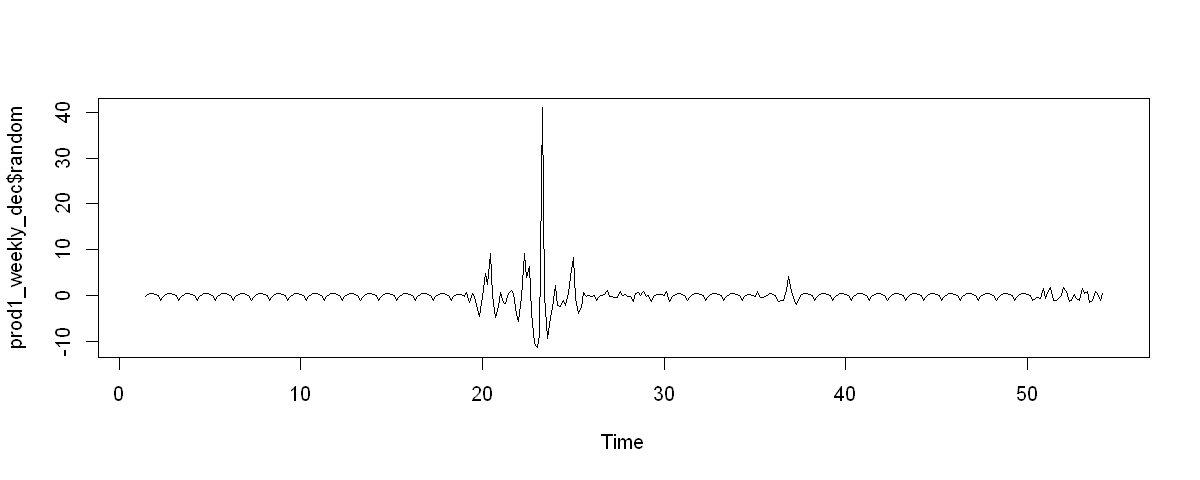

In [200]:
plot(prod1_weekly_dec$random)

* The variance is higher in the midde points of the graph. 
* The mean seems to be constant. 
 
Now, let's check whether the weekly detrended and deseasonalized data is stationary. 

In [201]:
u_test <- ur.kpss(prod1_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0093 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


We dont have enough evidence to reject the null hyphothesis. The data is now stationary. 

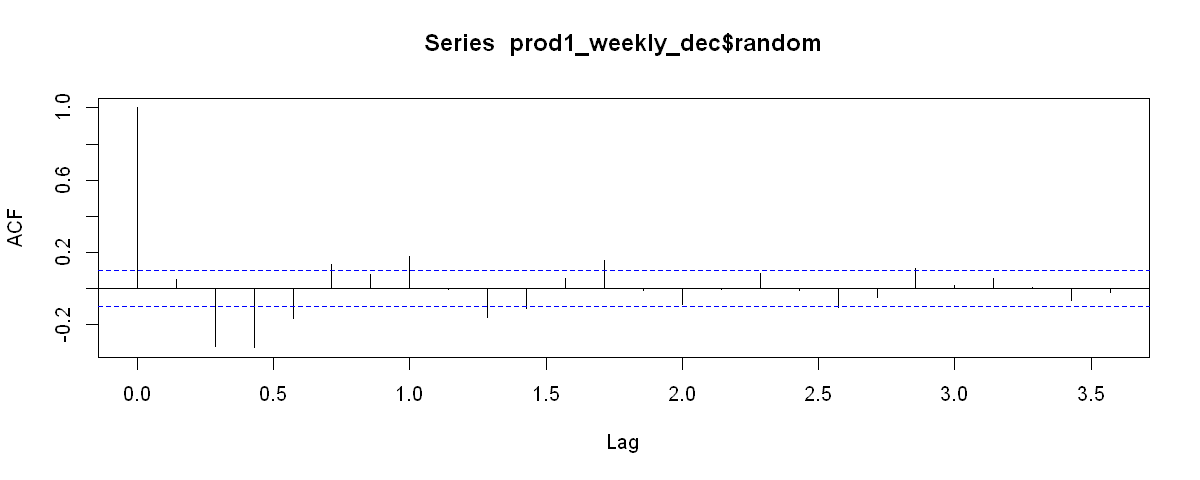

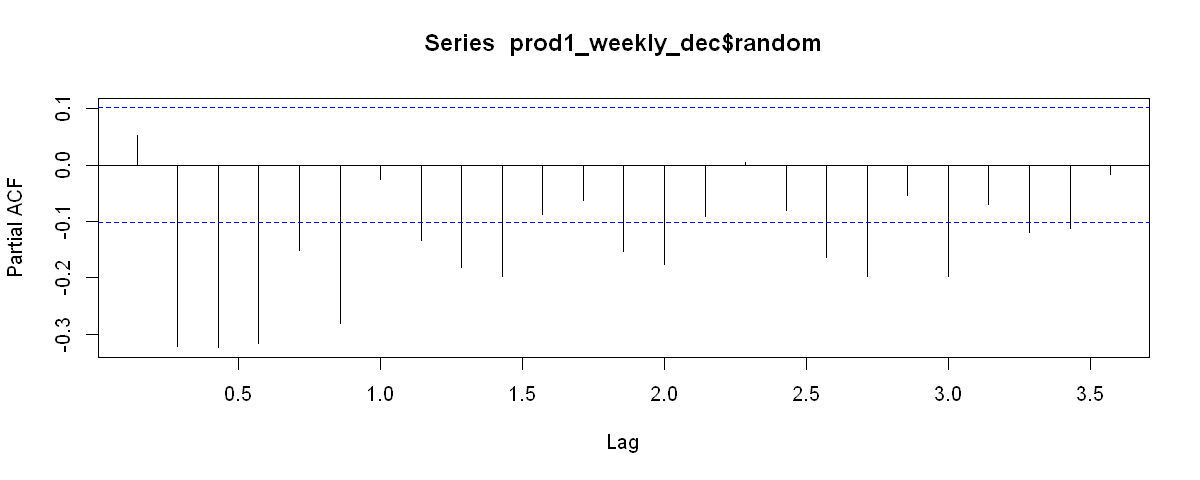

In [202]:
acf(prod1_weekly_dec$random, na.action=na.pass)
pacf(prod1_weekly_dec$random, na.action=na.pass)

From the PACF graph above, the data is correlated with its first lags. 

### Monthly Decomposition

month,sold_count
2020 May,0
2020 Haz,0
2020 Tem,0
2020 Ağu,0
2020 Eyl,1
2020 Eki,197
2020 Kas,54
2020 Ara,4
2021 Oca,9
2021 Şub,2


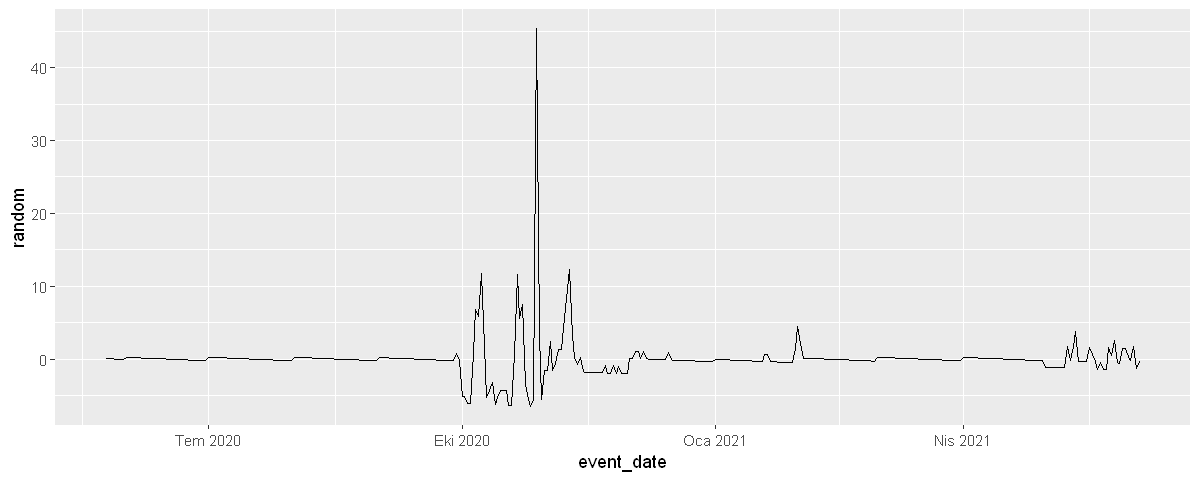

In [203]:
prod1_monthly <- prod1[, month:=yearmonth(event_date)]
prod1_monthly[, .(sold_count=sum(sold_count)), by=month]
prod1_monthly[, trend:=1:.N]

prod1_reg <- lm(sold_count~trend+as.factor(month), data=prod1_monthly)
prod1_monthly[, regOutput:=predict(prod1_reg, prod1_monthly)]

prod1_monthly[, random:=sold_count-regOutput]

ggplot(prod1_monthly, aes(x=event_date, y=random)) + geom_line()

* The graph is similar to its weekly decomposed graph. 
* The variance is high in the middle points. 
* The mean seems to be constant. 

In [204]:
u_test <- ur.kpss(prod1_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0196 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the test above, the data is stationary. 

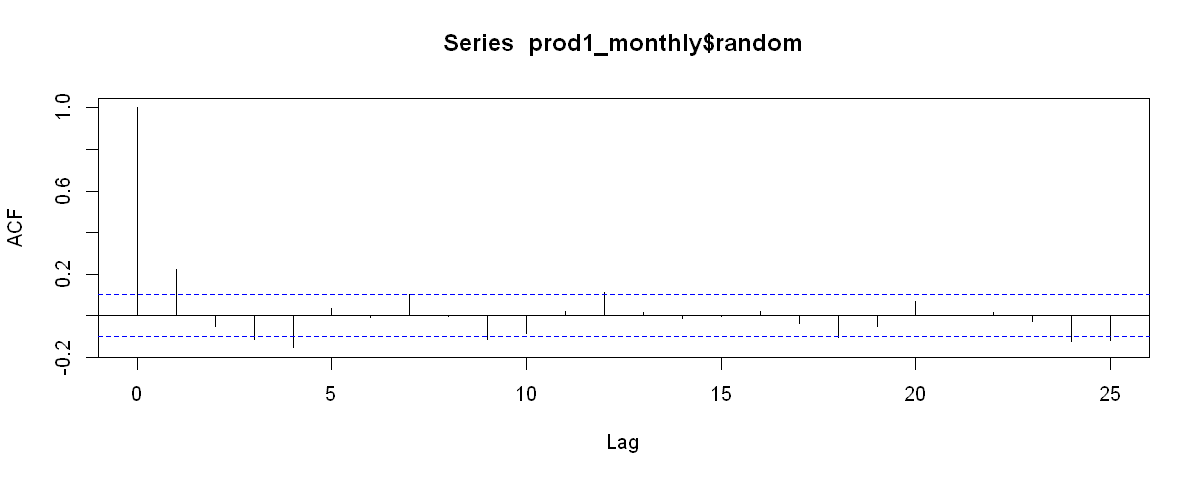

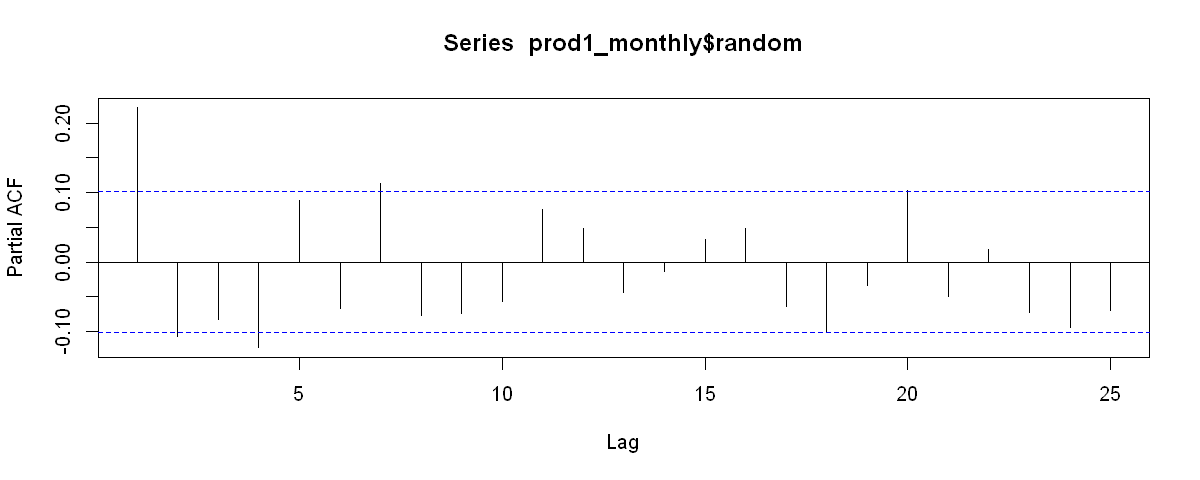

In [205]:
acf(prod1_monthly$random, na.action=na.pass)
pacf(prod1_monthly$random, na.action=na.pass)

There is not a high autocorrelation but we can say that there is a little correlation with lag 1. 

### Building an ARIMA Model

In [206]:
mont <- data[product_content_id=="48740784",][order(event_date)]
mont$is_winter <- 0
mont[month(mont$event_date) %in% c(9,10,11,12,1),]$is_winter <- 1
mont_train <- mont[event_date<test_start,]
mont_ts <- ts(mont_train$sold_count)

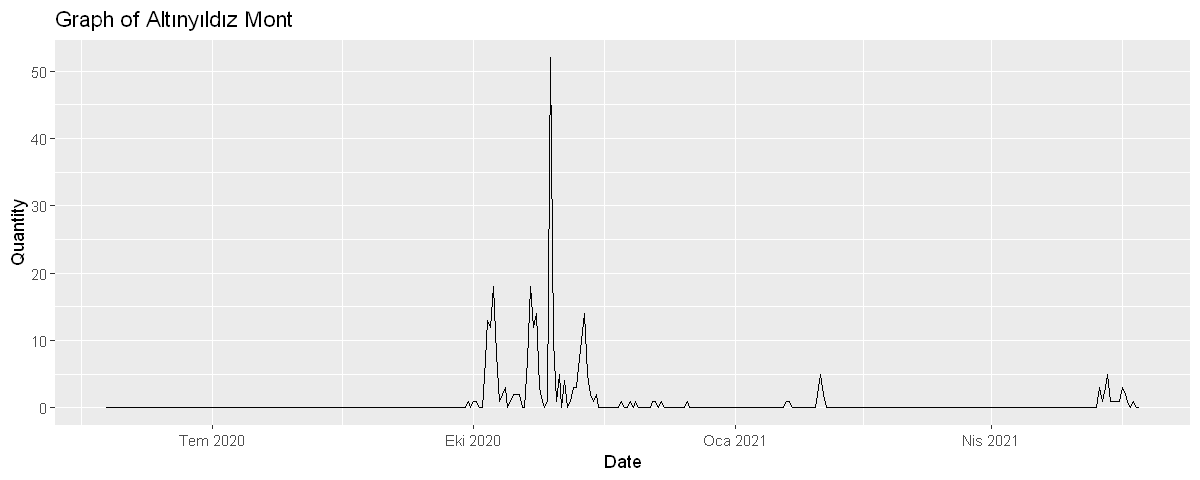

In [207]:
ggplot(mont_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Altınyıldız Mont", x= "Date", y="Quantity")

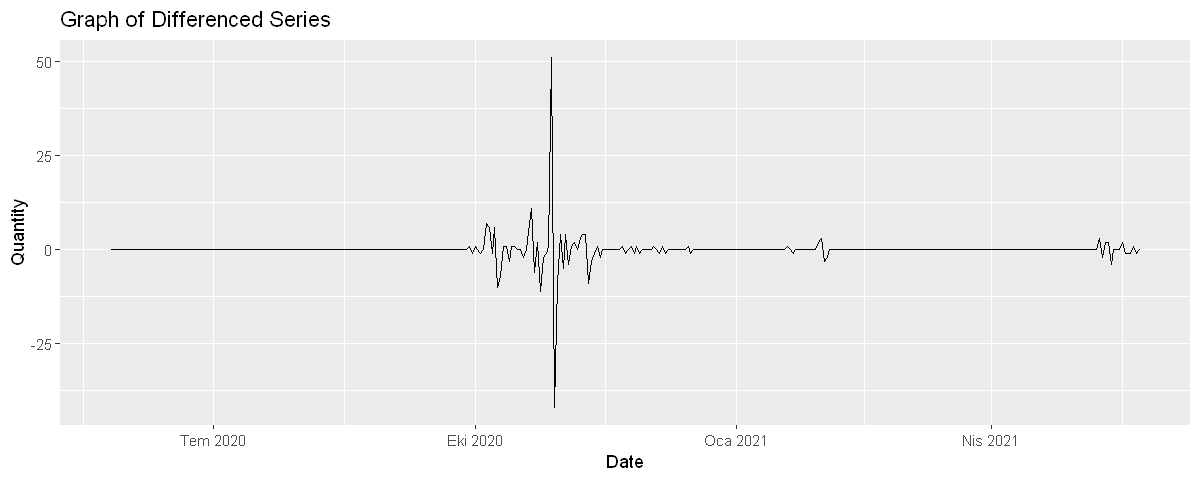

In [208]:
ggplot(mont_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(mont_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

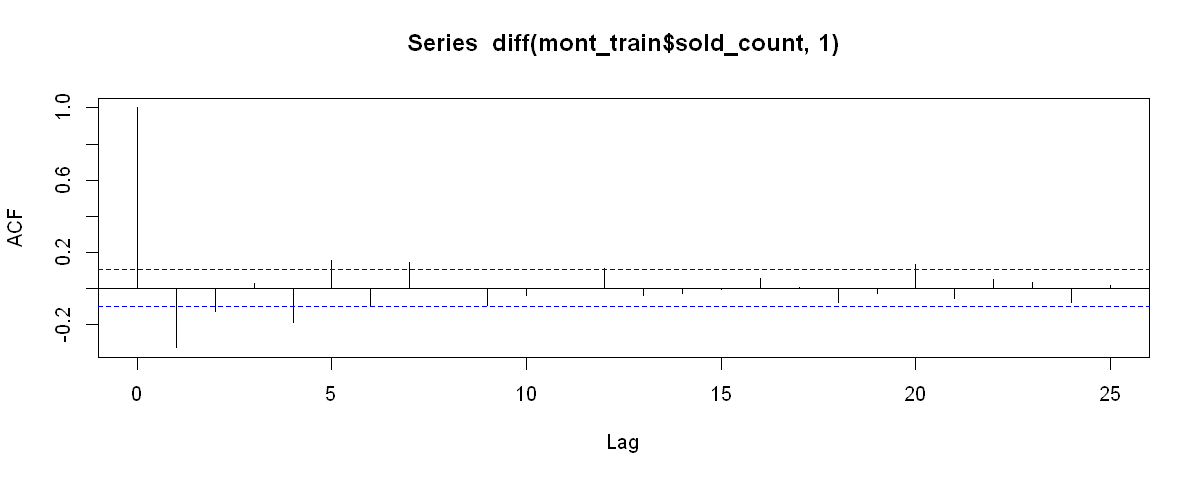

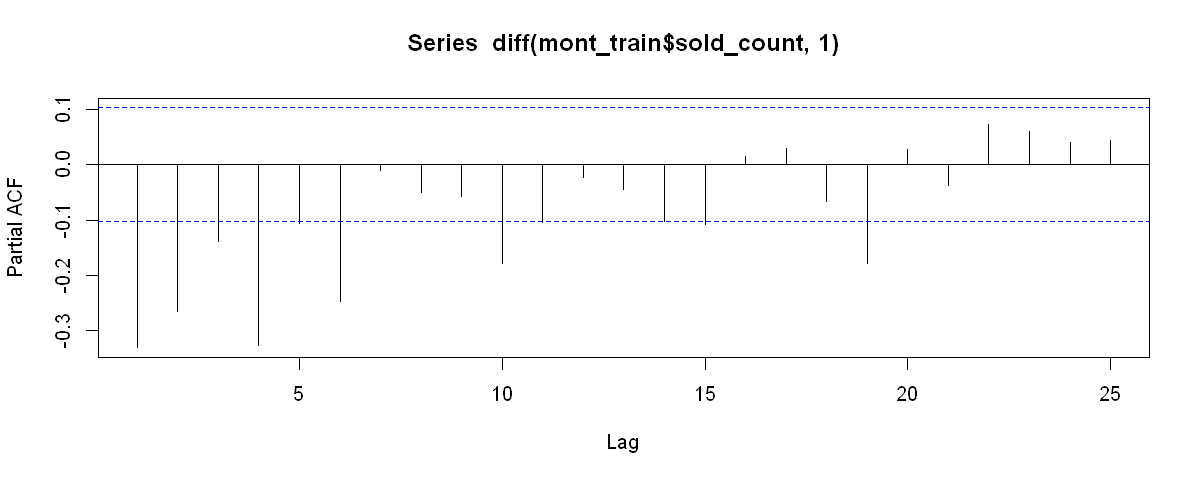

In [209]:
acf(diff(mont_train$sold_count,1))
pacf(diff(mont_train$sold_count,1))

There are spikes at the ACF graph at lags 1 and 4. There are also spikes at the PACF graph at lags 1,2,4. These paramters could be tried on a ARIMA model.

In [210]:
arima(mont_ts,order=c(1,1,1))


Call:
arima(x = mont_ts, order = c(1, 1, 1))

Coefficients:
         ar1      ma1
      0.2707  -0.9211
s.e.  0.0577   0.0231

sigma^2 estimated as 10.15:  log likelihood = -936.39,  aic = 1878.78

In [211]:
arima(mont_ts,order=c(1,1,2))


Call:
arima(x = mont_ts, order = c(1, 1, 2))

Coefficients:
          ar1      ma1      ma2
      -0.5704  -0.0908  -0.7126
s.e.   0.0958   0.0751   0.0603

sigma^2 estimated as 10.02:  log likelihood = -934.12,  aic = 1876.23

In [212]:
arima(mont_ts,order=c(1,1,4))


Call:
arima(x = mont_ts, order = c(1, 1, 4))

Coefficients:
          ar1    ma1      ma2      ma3      ma4
      -0.6187  0.025  -0.6236  -0.1037  -0.1251
s.e.   0.1233  0.125   0.0892   0.0696   0.0584

sigma^2 estimated as 9.817:  log likelihood = -930.39,  aic = 1872.78

In [213]:
arima(mont_ts,order=c(4,1,1))


Call:
arima(x = mont_ts, order = c(4, 1, 1))

Coefficients:
         ar1      ar2      ar3      ar4      ma1
      0.2120  -0.0872  -0.0311  -0.1665  -0.8560
s.e.  0.0636   0.0572   0.0563   0.0569   0.0421

sigma^2 estimated as 9.878:  log likelihood = -931.51,  aic = 1875.02

In [214]:
arima(mont_ts,order=c(4,1,2))


Call:
arima(x = mont_ts, order = c(4, 1, 2))

Coefficients:
          ar1     ar2      ar3      ar4      ma1      ma2
      -0.4658  0.0950  -0.0630  -0.1948  -0.1423  -0.6481
s.e.   0.0974  0.0739   0.0658   0.0579   0.0891   0.0845

sigma^2 estimated as 9.605:  log likelihood = -926.5,  aic = 1866.99

In [215]:
arima(mont_ts,order=c(4,1,4))


Call:
arima(x = mont_ts, order = c(4, 1, 4))

Coefficients:
          ar1     ar2     ar3      ar4      ma1      ma2      ma3     ma4
      -0.5717  0.2418  0.0843  -0.2258  -0.0312  -0.8675  -0.0919  0.1821
s.e.   0.3016  0.4242  0.2119   0.0758   0.3073   0.3568   0.2419  0.2878

sigma^2 estimated as 9.589:  log likelihood = -926.2,  aic = 1870.41

The best model is ARIMA(4,1,2) with lowest AIC value of 1866.99.


	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)
Q* = 7.161, df = 4, p-value = 0.1276

Model df: 6.   Total lags used: 10



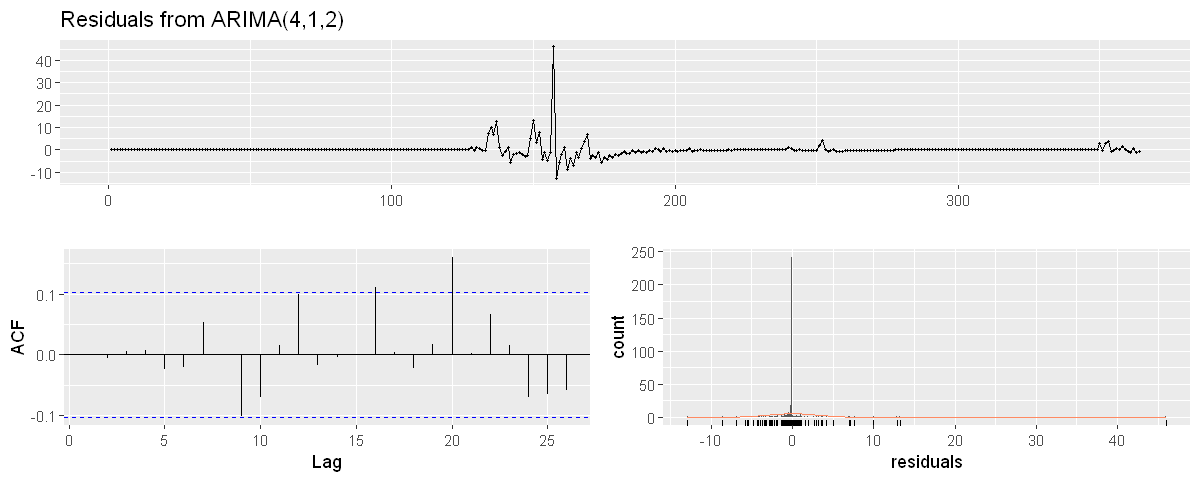

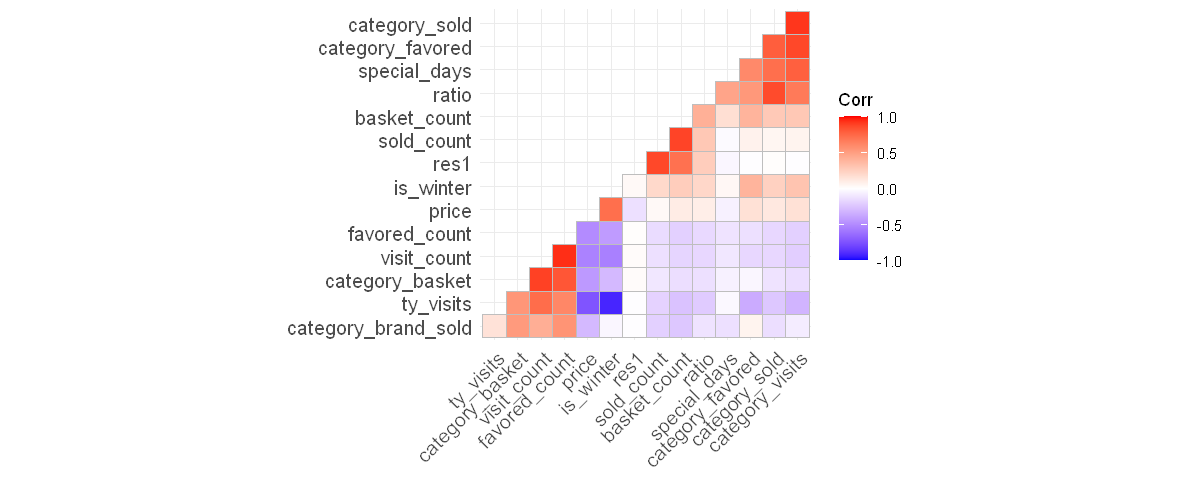

In [216]:
model_mont_arima <- arima(mont_ts,order=c(4,1,2))
checkresiduals(model_mont_arima)
mont_train$res1 <- model_mont_arima$residuals
corr <- cor(mont_train[!is.na(mont_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Resdiuals looks statioanry with 0 mean and constant variance. Basket_count could be added as a regressor.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


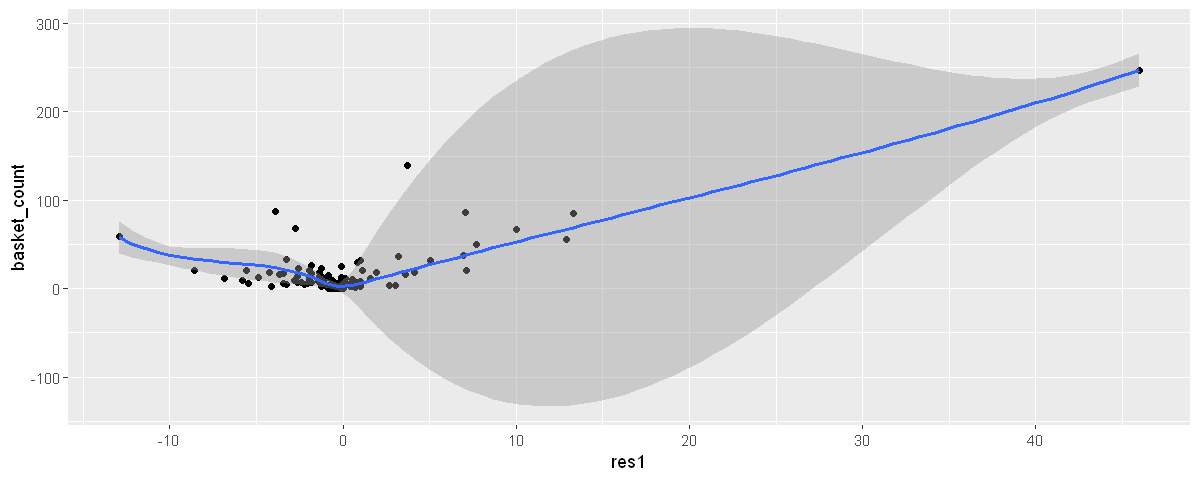

In [217]:
ggplot(mont_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


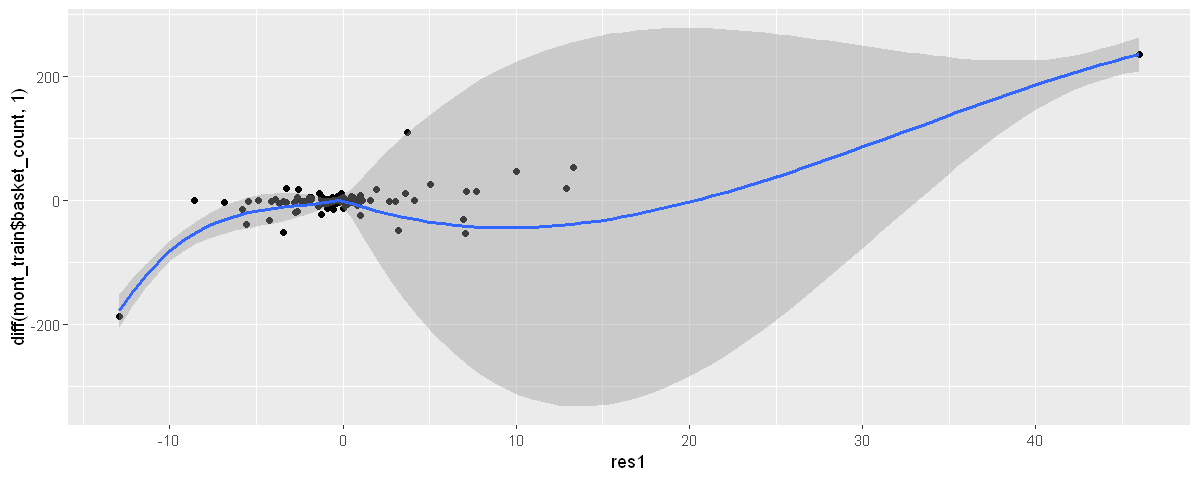

In [218]:
ggplot(mont_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(mont_train$basket_count,1))) +
  geom_smooth(aes(y=diff(mont_train$basket_count,1)))

In [219]:
cor(mont_train$res1,mont_train$basket_count)

[1] 0.6473446

In [220]:
arima(mont_ts,order=c(4,1,2),xreg=mont_train$basket_count)


Call:
arima(x = mont_ts, order = c(4, 1, 2), xreg = mont_train$basket_count)

Coefficients:
          ar1     ar2     ar3      ar4      ma1      ma2
      -0.4076  0.4715  0.3132  -0.0682  -0.3176  -0.6824
s.e.   0.1455  0.0641  0.0650   0.0634   0.1386   0.1383
      mont_train$basket_count
                       0.1879
s.e.                   0.0049

sigma^2 estimated as 1.833:  log likelihood = -627.37,  aic = 1270.73

AIC value is decreased when the regressor added.


	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)
Q* = 13.174, df = 3, p-value = 0.004275

Model df: 7.   Total lags used: 10



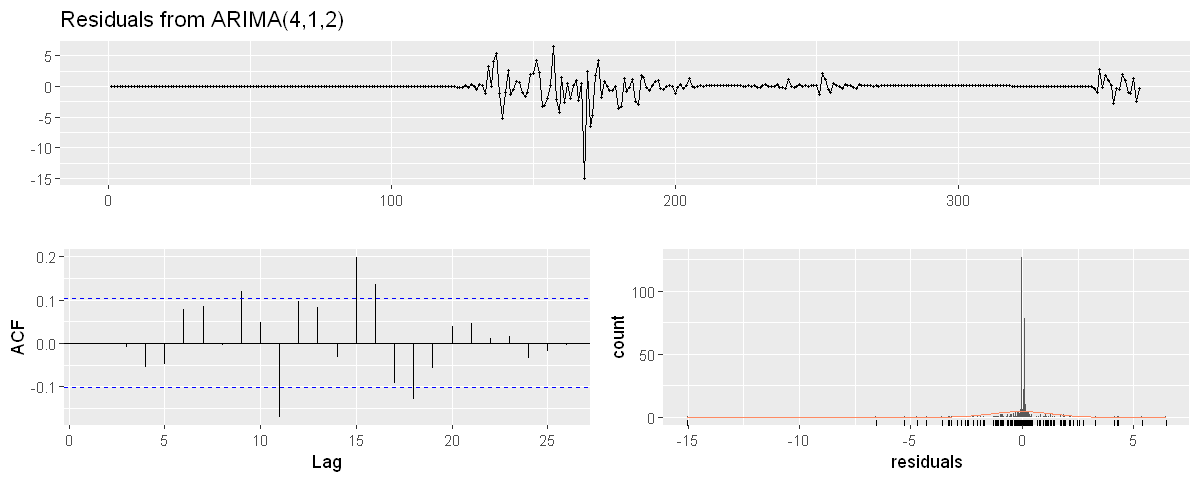

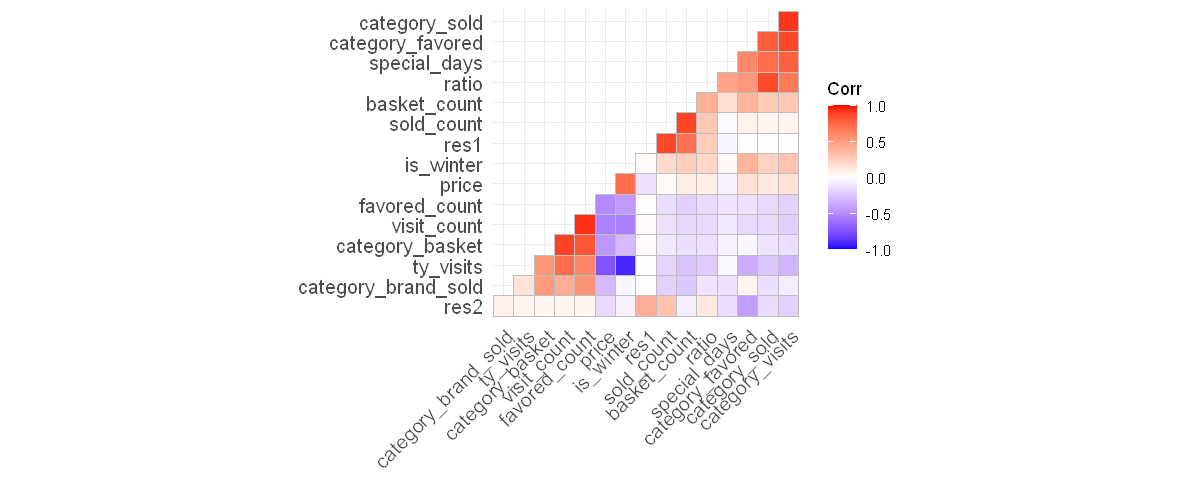

In [221]:
model_mont_arimax <- arima(mont_ts,order=c(4,1,2),xreg=mont_train$basket_count)
checkresiduals(model_mont_arimax)
mont_train$res2 <- model_mont_arimax$residuals
corr <- cor(mont_train[!is.na(mont_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

In [222]:
forecast_data_mont <- data.table(event_date=mont[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=mont[event_date>=test_start&event_date<=test_end,]$sold_count)
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- mont[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(4,1,2))
  model_arimax <- Arima(train_dt$sold_count,order=c(4,1,2),xreg=train_dt$basket_count)
  newreg <- forecast(auto.arima(train_dt$basket_count),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  
}
forecast_data_mont <- forecast_data_mont[,`:=`(arima_p=arima_fc,
                                     arimax_p=arimax_fc)]
accu(forecast_data_mont$sold_count,forecast_data_mont$arima_p)
accu(forecast_data_mont$sold_count,forecast_data_mont$arimax_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,2.375,1.06066,0.4465938,0.319666,0.5304111,1.415184,1.223664,0.5152268,0.5152268


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
8,2.375,1.06066,0.4465938,0.3466773,0.6768505,1.624869,1.479535,0.6229621,0.6229621


Although the both models give high error values, ARIMA model is better. However, for the "Altınyıldız Mont" product, it is better to forecast a value between 0 and 5, because it is not sold in summers.